# Notebook for replicating the analyses in "Arkansas business and individual income tax reform in 2025"
### Richard W. Evans, December 2025
This notebook replicates the analyses by [Richard W. Evans](https://sites.google.com/site/rickecon) (@rickecon) in the December 2025 article, "[Arkansas business and individual income tax reform in 2025]()".

A GitHub repository with all the data, images, and code from these analyses, with a corresponding Jupyter notebook ([`AR_IndivBusTax25.ipynb`](https://github.com/OpenSourceEcon/AR-IndivBusTax25/blob/main/AR_IndivBusTax25.ipynb)) that can be run from your local machine, is available here (https://github.com/OpenSourceEcon/AR-IndivBusTax25).

A Google Colab version of this notebook that can be run from your browser in the cloud is available at [this link]().

## 1. Introduction
Before opening and running this notebook, make sure that you have downloaded or cloned the [`AR-IndivBusTax25`](https://github.com/OpenSourceEcon/AR-IndivBusTax25) repository (https://github.com/OpenSourceEcon/AR-IndivBusTax25) and created and activated the associated conda environment `ar-indivbustax25-dev` in the `environment.yml` file. You can also run this notebook easily in the cloud by going to this [Google Colab version]() of this notebook.

In [48]:
# import packages
import pandas as pd
import numpy as np
import os
import geopandas as gpd
from bokeh.io import output_file, output_notebook
from bokeh.plotting import figure, show
from bokeh.models import (
    ColumnDataSource, Title, Label, LabelSet, Legend, LegendItem,
    CategoricalColorMapper, ColorBar, HoverTool, NumeralTickFormatter,
    GeoJSONDataSource, FactorRange, FixedTicker
)
from bokeh.models.tickers import SingleIntervalTicker
from bokeh.transform import factor_cmap
from bokeh.sampledata.us_states import data as states
from bokeh.transform import cumsum
from bokeh.palettes import Category20c

import ccc
import requests
import random
import json

import plotly.express as px

from policyengine_us.model_api import *
from policyengine_us import Simulation
from policyengine_core.reforms import Reform
from policyengine_core.periods import instant

## 2. Create Figures 1 and 2

### 2.1. Create Figure 1, US State Employment Income Tax Systems as of July 2025

In [49]:
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'data')
image_dir = os.path.join(cur_dir, 'images')

Create the data for state tax type.

In [38]:
# Create a DataFrame of states and their tax types as of July, 2025. For
# a summary of current tax brackets and rates see Andrey Yushkov and Katherine
# Loughead, "State Individual Income Tax Rates and Brackets, 2025", Tax
# Foundation, Feb. 18, 2025.
# https://taxfoundation.org/data/all/state/state-income-tax-rates/
# 0 = No state income tax
# 1 = Flat state income tax rate
# 2 = Nearly flat state income tax rates (top tax bracket starts at <= $20,000
#     for married filing jointly)
# 3 = Progressive state income tax rates
state_taxtype_list = [
    ["Alabama", "AL", 2, "5.00%", "$6k"],  # top income bracket starts at $6k
    ["Alaska", "AK", 0, "0.00%", "$0"],
    ["Arizona", "AZ", 1, "2.50%", "$0"],
    ["Arkansas", "AR", 3, "3.90%", "$25.7k"],  # top income bracket starts at $25.7k
    ["California", "CA", 3, "13.30%", "$1.4m"],  # top income bracket starts at $1.4m
    ["Colorado", "CO", 1, "4.40%", "$0"],
    ["Connecticut", "CT", 3, "6.99%", "$1m"],  # top income bracket starts at $1m
    ["Delaware", "DE", 3, "6.60%", "$60k"],  # top income bracket starts at $60k
    ["District of Columbia", "DC", 3, "10.75%", "$1m"],  # top income bracket starts at $1m
    ["Florida", "FL", 0, "0.00%", "$0"],
    ["Georgia", "GA", 1, "5.39%", "$0"],
    ["Hawaii", "HI", 3, "11.00%", "$650k"],  # top income bracket starts at $650k
    ["Idaho", "ID", 2, "5.695%", "$9,346"],  # top income bracket starts at $9,346
    ["Illinois", "IL", 1, "4.95%", "$0"],
    ["Indiana", "IN", 1, "3.00%", "$0"],
    ["Iowa", "IA", 1, "3.80%", "$0"],
    ["Kansas", "KS", 3, "5.58%", "$46k"],  # top income bracket starts at $46k
    ["Kentucky", "KY", 1, "4.00%", "$0"],
    ["Louisiana", "LA", 1, "3.00%", "$0"],
    ["Maine", "ME", 3, "7.15%", "$126.9k"],  # top income bracket starts at $126,900
    ["Maryland", "MD", 3, "5.75%", "$300k"],  # top income bracket starts at $300k
    ["Massachusetts", "MA", 3, "9.00%", "$1.1m"],  # top income bracket starts at $1.1m
    ["Michigan", "MI", 1, "4.25%", "$0"],
    ["Minnesota", "MN", 3, "9.85%", "$330,410"],  # top income bracket starts at $330,410
    ["Mississippi", "MS", 2, "4.40%", "$10k"],  # top income bracket starts at $10k
    ["Missouri", "MO", 3, "4.70%", "$40,691"],  # top income bracket starts at $40,691
    ["Montana", "MT", 3, "5.90%", "$42.2k"],  # top income bracket starts at $42.2k
    ["Nebraska", "NE", 3, "5.84%", "$77,730"],  # top income bracket starts at $77,730
    ["Nevada", "NV", 0, "0.00%", "$0"],
    ["New Hampshire", "NH", 0, "0.00%", "$0"],
    ["New Jersey", "NJ", 3, "10.75%", "$1m"],  # top income bracket starts at $1m
    ["New Mexico", "NM", 3, "5.90%", "$315k"],  # top income bracket starts at $315k
    ["New York", "NY", 3, "10.90%", "$25m"],  # top income bracket starts at $25m
    ["North Carolina", "NC", 1, "4.25%", "$0"],
    ["North Dakota", "ND", 3, "2.50%", "$298,075"],  # top income bracket starts at $298,075
    ["Ohio", "OH", 3, "3.50%", "$100k"],  # top income bracket starts at $100k
    ["Oklahoma", "OK", 2, "4.75%", "$14.4k"],  # top income bracket starts at $14.4k
    ["Oregon", "OR", 3, "9.90%", "$250k"],  # top income bracket starts at $250k
    ["Pennsylvania", "PA", 1, "3.07%", "$0"],
    ["Rhode Island", "RI", 3, "5.99%", "$181,650"],  # top income bracket starts at $181,650
    ["South Carolina", "SC", 3, "6.00%", "$46,530"],  # top income bracket starts at $46,530
    ["South Dakota", "SD", 0, "0.00%", "$0"],
    ["Tennessee", "TN", 0, "0.00%", "$0"],
    ["Texas", "TX", 0, "0.00%", "$0"],
    ["Utah", "UT", 1, "4.55%", "$0"],
    ["Vermont", "VT", 3, "8.75%", "$294.6k"],  # top income bracket starts at $294.6k
    ["Virginia", "VA", 2, "5.75%", "$17k"],  # top income bracket starts at $17k
    ["Washington", "WA", 0, "0.00%", "$0"],
    ["West Virginia", "WV", 3, "4.82%", "$60k"],  # top income bracket starts at $60k
    ["Wisconsin", "WI", 3, "7.65%", "$431,060"],  # top income bracket starts at $431,060
    ["Wyoming", "WY", 0, "0.00%", "$0"],
]
state_taxtype_df = pd.DataFrame(
    state_taxtype_list, columns=[
        "State", "Abbrev", "TaxType", "TopRate", "TopBracketStart"
    ]
)
state_taxtype_df["TaxType_str"] = ""
state_taxtype_df["TaxType_str"][state_taxtype_df["TaxType"]==0] = \
    "No state labor income tax"
state_taxtype_df["TaxType_str"][state_taxtype_df["TaxType"]==1] = \
    "Flat state income tax rate"
state_taxtype_df["TaxType_str"][state_taxtype_df["TaxType"]==2] = \
    "Nearly flat state income tax rates"
state_taxtype_df["TaxType_str"][state_taxtype_df["TaxType"]==3] = \
    "Progressive state income tax rates"
state_taxtype_df["TaxType_str_short"] = ""
state_taxtype_df["TaxType_str_short"][state_taxtype_df["TaxType"]==0] = \
    "No income tax"
state_taxtype_df["TaxType_str_short"][state_taxtype_df["TaxType"]==1] = \
    "Flat income tax rate"
state_taxtype_df["TaxType_str_short"][state_taxtype_df["TaxType"]==2] = \
    "Nearly flat income tax rates"
state_taxtype_df["TaxType_str_short"][state_taxtype_df["TaxType"]==3] = \
    "Progressive income tax rates"
state_taxtype_df["fill_color"] = ""
state_taxtype_df["fill_color"][state_taxtype_df["TaxType"]==0] = "#D8D3D3"
state_taxtype_df["fill_color"][state_taxtype_df["TaxType"]==1] = "red"
state_taxtype_df["fill_color"][state_taxtype_df["TaxType"]==2] = "purple"
state_taxtype_df["fill_color"][state_taxtype_df["TaxType"]==3] = "blue"
state_taxtype_df["label_color"] = "black"
state_taxtype_df["label_color"][state_taxtype_df["TaxType"]==3] = "white"

# Sort alphabetically by full state name
state_taxtype_df.sort_values("State", inplace=True, ignore_index=True)

# Create sub-DataFrames for each tax type
no_tax_states_df = \
    state_taxtype_df[state_taxtype_df["TaxType"]==0].reset_index(drop=True)
flat_tax_states_df = \
    state_taxtype_df[state_taxtype_df["TaxType"]==1].reset_index(drop=True)
nflat_tax_states_df = \
    state_taxtype_df[state_taxtype_df["TaxType"]==2].reset_index(drop=True)
prog_tax_states_df = \
    state_taxtype_df[state_taxtype_df["TaxType"]==3].reset_index(drop=True)
print(state_taxtype_df.groupby("TaxType").count())

# Save state_taxtype_df as .csv
state_taxtype_df.to_csv('./data/fig1_state_taxtype_2025.csv', index=False)
# Print state_taxtype_df sorted by TopRate descending
state_taxtype_df.sort_values("TopRate", ascending=False)

         State  Abbrev  TopRate  TopBracketStart  TaxType_str  \
TaxType                                                         
0            9       9        9                9            9   
1           12      12       12               12           12   
2            5       5        5                5            5   
3           25      25       25               25           25   

         TaxType_str_short  fill_color  label_color  
TaxType                                              
0                        9           9            9  
1                       12          12           12  
2                        5           5            5  
3                       25          25           25  


State Abbrev  TaxType TopRate TopBracketStart  \
37                Oregon     OR        3   9.90%           $250k   
23             Minnesota     MN        3   9.85%        $330,410   
21         Massachusetts     MA        3   9.00%           $1.1m   
45               Vermont     VT        3   8.75%         $294.6k   
49             Wisconsin     WI        3   7.65%        $431,060   
19                 Maine     ME        3   7.15%         $126.9k   
6            Connecticut     CT        3   6.99%             $1m   
7               Delaware     DE        3   6.60%            $60k   
40        South Carolina     SC        3   6.00%         $46,530   
39          Rhode Island     RI        3   5.99%        $181,650   
26               Montana     MT        3   5.90%          $42.2k   
31            New Mexico     NM        3   5.90%           $315k   
27              Nebraska     NE        3   5.84%         $77,730   
46              Virginia     VA        2   5.75%            $17k   
20              Maryland     MD        3   5.75%           $300k   
12                 Idaho     ID        2  5.695%          $9,346   
16                Kansas     KS        3   5.58%            $46k   
10               Georgia     GA        1   5.39%              $0   
0                Alabama     AL        2   5.00%             $6k   
13              Illinois     IL        1   4.95%              $0   
48         West Virginia     WV        3   4.82%            $60k   
36              Oklahoma     OK        2   4.75%          $14.4k   
25              Missouri     MO        3   4.70%         $40,691   
44                  Utah     UT        1   4.55%              $0   
5               Colorado     CO        1   4.40%              $0   
24           Mississippi     MS        2   4.40%            $10k   
22              Michigan     MI        1   4.25%              $0   
33        North Carolina     NC        1   4.25%              $0   
17              Kentucky     KY        1   4.00%              $0   
3               Arkansas     AR        3   3.90%          $25.7k   
15                  Iowa     IA        1   3.80%              $0   
35                  Ohio     OH        3   3.50%           $100k   
38          Pennsylvania     PA        1   3.07%              $0   
18             Louisiana     LA        1   3.00%              $0   
14               Indiana     IN        1   3.00%              $0   
2                Arizona     AZ        1   2.50%              $0   
34          North Dakota     ND        3   2.50%        $298,075   
4             California     CA        3  13.30%           $1.4m   
11                Hawaii     HI        3  11.00%           $650k   
32              New York     NY        3  10.90%            $25m   
8   District of Columbia     DC        3  10.75%             $1m   
30            New Jersey     NJ        3  10.75%             $1m   
9                Florida     FL        0   0.00%              $0   
41          South Dakota     SD        0   0.00%              $0   
42             Tennessee     TN        0   0.00%              $0   
43                 Texas     TX        0   0.00%              $0   
29         New Hampshire     NH        0   0.00%              $0   
47            Washington     WA        0   0.00%              $0   
28                Nevada     NV        0   0.00%              $0   
1                 Alaska     AK        0   0.00%              $0   
50               Wyoming     WY        0   0.00%              $0   

                           TaxType_str             TaxType_str_short  \
37  Progressive state income tax rates  Progressive income tax rates   
23  Progressive state income tax rates  Progressive income tax rates   
21  Progressive state income tax rates  Progressive income tax rates   
45  Progressive state income tax rates  Progressive income tax rates   
49  Progressive state income tax rates  Progressive income tax rates   
19  Progressive state income tax rates  Progressiv

In [39]:
# Print the no tax states
no_tax_states_df

State Abbrev  TaxType TopRate TopBracketStart  \
0         Alaska     AK        0   0.00%              $0   
1        Florida     FL        0   0.00%              $0   
2         Nevada     NV        0   0.00%              $0   
3  New Hampshire     NH        0   0.00%              $0   
4   South Dakota     SD        0   0.00%              $0   
5      Tennessee     TN        0   0.00%              $0   
6          Texas     TX        0   0.00%              $0   
7     Washington     WA        0   0.00%              $0   
8        Wyoming     WY        0   0.00%              $0   

                 TaxType_str TaxType_str_short fill_color label_color  
0  No state labor income tax     No income tax    #D8D3D3       black  
1  No state labor income tax     No income tax    #D8D3D3       black  
2  No state labor income tax     No income tax    #D8D3D3       black  
3  No state labor income tax     No income tax    #D8D3D3       black  
4  No state labor income tax     No income tax    #D8D3D3       black  
5  No state labor income tax     No income tax    #D8D3D3       black  
6  No state labor income tax     No income tax    #D8D3D3       black  
7  No state labor income tax     No income tax    #D8D3D3       black  
8  No state labor income tax     No income tax    #D8D3D3       black

In [40]:
# Print the flat tax states
flat_tax_states_df

State Abbrev  TaxType TopRate TopBracketStart  \
0          Arizona     AZ        1   2.50%              $0   
1         Colorado     CO        1   4.40%              $0   
2          Georgia     GA        1   5.39%              $0   
3         Illinois     IL        1   4.95%              $0   
4          Indiana     IN        1   3.00%              $0   
5             Iowa     IA        1   3.80%              $0   
6         Kentucky     KY        1   4.00%              $0   
7        Louisiana     LA        1   3.00%              $0   
8         Michigan     MI        1   4.25%              $0   
9   North Carolina     NC        1   4.25%              $0   
10    Pennsylvania     PA        1   3.07%              $0   
11            Utah     UT        1   4.55%              $0   

                   TaxType_str     TaxType_str_short fill_color label_color  
0   Flat state income tax rate  Flat income tax rate        red       black  
1   Flat state income tax rate  Flat income tax rate        red       black  
2   Flat state income tax rate  Flat income tax rate        red       black  
3   Flat state income tax rate  Flat income tax rate        red       black  
4   Flat state income tax rate  Flat income tax rate        red       black  
5   Flat state income tax rate  Flat income tax rate        red       black  
6   Flat state income tax rate  Flat income tax rate        red       black  
7   Flat state income tax rate  Flat income tax rate        red       black  
8   Flat state income tax rate  Flat income tax rate        red       black  
9   Flat state income tax rate  Flat income tax rate        red       black  
10  Flat state income tax rate  Flat income tax rate        red       black  
11  Flat state income tax rate  Flat income tax rate        red       black

In [41]:
# Print the nearly flat tax states
nflat_tax_states_df

State Abbrev  TaxType TopRate TopBracketStart  \
0      Alabama     AL        2   5.00%             $6k   
1        Idaho     ID        2  5.695%          $9,346   
2  Mississippi     MS        2   4.40%            $10k   
3     Oklahoma     OK        2   4.75%          $14.4k   
4     Virginia     VA        2   5.75%            $17k   

                          TaxType_str             TaxType_str_short  \
0  Nearly flat state income tax rates  Nearly flat income tax rates   
1  Nearly flat state income tax rates  Nearly flat income tax rates   
2  Nearly flat state income tax rates  Nearly flat income tax rates   
3  Nearly flat state income tax rates  Nearly flat income tax rates   
4  Nearly flat state income tax rates  Nearly flat income tax rates   

  fill_color label_color  
0     purple       black  
1     purple       black  
2     purple       black  
3     purple       black  
4     purple       black

In [42]:
# Print the progressive tax states
prog_tax_states_df

State Abbrev  TaxType TopRate TopBracketStart  \
0               Arkansas     AR        3   3.90%          $25.7k   
1             California     CA        3  13.30%           $1.4m   
2            Connecticut     CT        3   6.99%             $1m   
3               Delaware     DE        3   6.60%            $60k   
4   District of Columbia     DC        3  10.75%             $1m   
5                 Hawaii     HI        3  11.00%           $650k   
6                 Kansas     KS        3   5.58%            $46k   
7                  Maine     ME        3   7.15%         $126.9k   
8               Maryland     MD        3   5.75%           $300k   
9          Massachusetts     MA        3   9.00%           $1.1m   
10             Minnesota     MN        3   9.85%        $330,410   
11              Missouri     MO        3   4.70%         $40,691   
12               Montana     MT        3   5.90%          $42.2k   
13              Nebraska     NE        3   5.84%         $77,730   
14            New Jersey     NJ        3  10.75%             $1m   
15            New Mexico     NM        3   5.90%           $315k   
16              New York     NY        3  10.90%            $25m   
17          North Dakota     ND        3   2.50%        $298,075   
18                  Ohio     OH        3   3.50%           $100k   
19                Oregon     OR        3   9.90%           $250k   
20          Rhode Island     RI        3   5.99%        $181,650   
21        South Carolina     SC        3   6.00%         $46,530   
22               Vermont     VT        3   8.75%         $294.6k   
23         West Virginia     WV        3   4.82%            $60k   
24             Wisconsin     WI        3   7.65%        $431,060   

                           TaxType_str             TaxType_str_short  \
0   Progressive state income tax rates  Progressive income tax rates   
1   Progressive state income tax rates  Progressive income tax rates   
2   Progressive state income tax rates  Progressive income tax rates   
3   Progressive state income tax rates  Progressive income tax rates   
4   Progressive state income tax rates  Progressive income tax rates   
5   Progressive state income tax rates  Progressive income tax rates   
6   Progressive state income tax rates  Progressive income tax rates   
7   Progressive state income tax rates  Progressive income tax rates   
8   Progressive state income tax rates  Progressive income tax rates   
9   Progressive state income tax rates  Progressive income tax rates   
10  Progressive state income tax rates  Progressive income tax rates   
11  Progressive state income tax rates  Progressive income tax rates   
12  Progressive state income tax rates  Progressive income tax rates   
13  Progressive state income tax rates  Progressive income tax rates   
14  Progressive state income tax rates  Progressive income tax rates   
15  Progressive state income tax rates  Progressive income tax rates   
16  Progressive state income tax rates  Progressive income tax rates   
17  Progressive state income tax rates  Progressive income tax rates   
18  Progressive state income tax rates  Progressive income tax rates   
19  Progressive state income tax rates  Progressive income tax rates   
20  Progressive state income tax rates  Progressive income tax rates   
21  Progressive state income tax rates  Progressive income tax rates   
22  Progressive state income tax rates  Progressive income tax rates   
23  Progressive state income tax rates  Progressive income tax rates   
24  Progressive state income tax rates  Progressive income tax rates   

   fill_color label_color  
0        blue       white  
1        blue       white  
2        blue       white  
3        blue       white  
4        blue       white  
5        blue       white  
6        blue       white  
7        blue       white  
8        blue       white  
9        blue       white  
10       blue       white  
11       blue       white  
12       blue

Create the Bokeh state map figure

In [43]:
fig1_title = "Figure 1. US State Employment Income Tax Systems as of July 2025"
# fig1_title = ""
output_file(
    "./images/fig1_state_taxtype_2025.html", title=fig1_title, mode='inline'
)
output_notebook()

# Download U.S. states shape files from US Census Bureau
# https://www.census.gov/geographies/mapping-files/2018/geo/carto-boundary-file.html
us_shapefile_path = (
    "https://github.com/OpenSourceEcon/AR-IndivBusTax25/raw/main/data/" +
    "cb_2018_us_state_20m/cb_2018_us_state_20m.shp"
)
gdf = gpd.GeoDataFrame.from_file(us_shapefile_path)
gdf_json = gdf.to_json()
gjson = json.loads(gdf_json)

# Remove Puerto Rico from data
del(gjson["features"][7])

# Alaska
# Fix positive longitudes
min_lat_ak = 180  # initial value that will be adjusted
min_abs_lon_ak = 180  # initial value that will be adjusted
coords_list = gjson["features"][24]["geometry"]["coordinates"]
for ind_isl, island in enumerate(coords_list):
    for ind_pnt, point in enumerate(island[0]):
        min_lat_ak = np.minimum(min_lat_ak, point[1])
        if point[0] > 0:
            gjson["features"][24]["geometry"][
                "coordinates"
            ][ind_isl][0][ind_pnt][0] = -180 - (180 - point[0])
        else:
            min_abs_lon_ak = np.minimum(min_abs_lon_ak, -point[0])

# Shrink the size of Alaska relative to its southestern most minimum lattitude
# and longitude
shrink_pct_ak = 0.65
coords_list_ak = gjson["features"][24]["geometry"]["coordinates"]
for ind_isl, island in enumerate(coords_list_ak):
    for ind_pnt, point in enumerate(island[0]):
        gjson["features"][24]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][0] = point[0] - shrink_pct_ak * (point[0] +
                                                                min_abs_lon_ak)
        gjson["features"][24]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][1] = point[1] - shrink_pct_ak * (point[1] -
                                                                min_lat_ak)

# Move Alaska closer to the mainland such that the minimum minimum absolute
# longitude and lattitude are (-127, 44)
min_lat_ak_new = 44
min_abs_lon_ak_new = 127
for ind_isl, island in enumerate(coords_list):
    for ind_pnt, point in enumerate(island[0]):
        gjson["features"][24]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][0] = point[0] + (min_abs_lon_ak -
                                                min_abs_lon_ak_new)
        gjson["features"][24]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][1] = point[1] - (min_lat_ak - min_lat_ak_new)

# Hawaii
list_ind_hi = 47
# Get minimum lattitude and minimum absolute longitude for Hawaii
min_lat_hi = 180  # initial value that will be adjusted
min_abs_lon_hi = 180  # initial value that will be adjusted
coords_list = gjson["features"][list_ind_hi]["geometry"]["coordinates"]
for ind_isl, island in enumerate(coords_list):
    for ind_pnt, point in enumerate(island[0]):
        min_lat_hi = np.minimum(min_lat_hi, point[1])
        min_abs_lon_hi = np.minimum(min_abs_lon_hi, -point[0])
# print("Minimum lattitude for Hawaii is", min_lat_hi)
# print("Minimum absolute longitude for Hawaii is", min_abs_lon_hi)

# Increase the size of Hawaii
incr_pct_hi = 0.4
coords_list_hi = gjson["features"][list_ind_hi]["geometry"]["coordinates"]
for ind_isl, island in enumerate(coords_list_hi):
    for ind_pnt, point in enumerate(island[0]):
        gjson["features"][list_ind_hi]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][0] = point[0] + incr_pct_hi * (point[0] +
                                                              min_abs_lon_hi)
        gjson["features"][list_ind_hi]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][1] = point[1] + incr_pct_hi * (point[1] -
                                                              min_lat_hi)

# Move Hawaii closer to the mainland such that the minimum minimum absolute
# longitude and lattitude are (-125, 27)
min_lat_hi_new = 27.5
min_abs_lon_hi_new = 124.5
for ind_isl, island in enumerate(coords_list):
    for ind_pnt, point in enumerate(island[0]):
        gjson["features"][list_ind_hi]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][0] = point[0] + (min_abs_lon_hi -
                                                min_abs_lon_hi_new)
        gjson["features"][list_ind_hi]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][1] = point[1] - (min_lat_hi - min_lat_hi_new)

# Add a state box around Delaware abbreviation DE
st_list_num = 2
de_coord_list = [gjson["features"][st_list_num]["geometry"]["coordinates"]]
new_box_de = [[
    [-75.4, 38.8],
    [-72.4, 38.3],
    [-72.4, 38.9],
    [-70.2, 38.9],
    [-70.2, 37.7],
    [-72.4, 37.7],
    [-72.4, 38.3]
]]
de_coord_list.append(new_box_de)
gjson["features"][st_list_num]["geometry"]["coordinates"] = de_coord_list
gjson["features"][st_list_num]["geometry"]["type"] = "MultiPolygon"

# Add a state box around Washington, DC (District of Columbia) abbreviation DC
st_list_num = 35
dc_coord_list = [gjson["features"][st_list_num]["geometry"]["coordinates"]]
new_box_dc = [[
    [-77.0, 38.9],
    [-73.3, 35.5],
    [-73.3, 36.1],
    [-71.1, 36.1],
    [-71.1, 34.9],
    [-73.3, 34.9],
    [-73.3, 35.5]
]]
dc_coord_list.append(new_box_dc)
gjson["features"][st_list_num]["geometry"]["coordinates"] = dc_coord_list
gjson["features"][st_list_num]["geometry"]["type"] = "MultiPolygon"

# Add a state box around Massachusetts abbreviation MD
st_list_num = 0
md_coord_list = gjson["features"][st_list_num]["geometry"]["coordinates"]
new_box_md = [[
    [-76.8, 39.3],
    [-72.7, 37.0],
    [-72.7, 37.6],
    [-70.5, 37.6],
    [-70.5, 36.4],
    [-72.7, 36.4],
    [-72.7, 37.0]
]]
md_coord_list.append(new_box_md)
gjson["features"][st_list_num]["geometry"]["coordinates"] = md_coord_list

# Add a state box around Massachusetts abbreviation MA
st_list_num = 29
ma_coord_list = gjson["features"][st_list_num]["geometry"]["coordinates"]
new_box_ma = [[
    [-71.7, 42.2],
    [-68.5, 42.2],
    [-68.5, 42.8],
    [-66.3, 42.8],
    [-66.3, 41.6],
    [-68.5, 41.6],
    [-68.5, 42.2]
]]
ma_coord_list.append(new_box_ma)
gjson["features"][st_list_num]["geometry"]["coordinates"] = ma_coord_list

# Add a state box around New Jersey abbreviation NJ
st_list_num = 34
nj_coord_list = [gjson["features"][st_list_num]["geometry"]["coordinates"]]
new_box_nj = [[
    [-74.4, 40.1],
    [-72.0, 39.7],
    [-72.0, 40.3],
    [-69.8, 40.3],
    [-69.8, 39.1],
    [-72.0, 39.1],
    [-72.0, 39.7]
]]
nj_coord_list.append(new_box_nj)
gjson["features"][st_list_num]["geometry"]["coordinates"] = nj_coord_list
gjson["features"][st_list_num]["geometry"]["type"] = "MultiPolygon"

# Add a state box around Rhode Island abbreviation RI
st_list_num = 50
ri_coord_list = gjson["features"][st_list_num]["geometry"]["coordinates"]
new_box_ri = [[
    [-71.5, 41.7],
    [-69.5, 40.4],
    [-69.5, 41.0],
    [-67.3, 41.0],
    [-67.3, 39.8],
    [-69.5, 39.8],
    [-69.5, 40.4]
]]
ri_coord_list.append(new_box_ri)
gjson["features"][st_list_num]["geometry"]["coordinates"] = ri_coord_list

# Merge the state tax type data into gjson for each state
state_taxtype_df
for ind_st, state in enumerate(gjson["features"]):
    st_abbrev = state["properties"]["STUSPS"]
    state["properties"]["tax_type"] = state_taxtype_df[
        state_taxtype_df["Abbrev"]==st_abbrev
    ]["TaxType_str_short"].iloc[0]
    state["properties"]["top_rate"] = state_taxtype_df[
        state_taxtype_df["Abbrev"]==st_abbrev
    ]["TopRate"].iloc[0]
    state["properties"]["top_bracket_start"] = state_taxtype_df[
        state_taxtype_df["Abbrev"]==st_abbrev
    ]["TopBracketStart"].iloc[0]

tax_type_labels = [
    'No income tax', 'Flat income tax rate', 'Nearly flat income tax rates',
    'Progressive income tax rates'
]
tax_type_colors = ["white", "red", "purple", "blue"]

source_shapes = {}
for category in tax_type_labels:
    source_shapes[category] = {"type": "FeatureCollection", "features": []}

for item in gjson["features"]:
    source_shapes[item["properties"]["tax_type"]]['features'].append(item)

TOOLS = "pan, box_zoom, wheel_zoom, hover, save, reset, help"

fig1 = figure(
    title=fig1_title,
    height=500,
    width=950,
    tools=TOOLS,
    # tooltips=[
    #     ("State", @state_names), ("Tax type", @tax_type)
    # ]
    # match_aspect = True,
    min_border = 0,
    x_axis_location = None, y_axis_location = None,
    toolbar_location="right"
)
fig1.toolbar.logo = None
fig1.grid.grid_line_color = None

cmap = CategoricalColorMapper(
    palette=tax_type_colors, factors=tax_type_labels
)
for category in tax_type_labels:
    source_shape_1 = GeoJSONDataSource(
        geojson = json.dumps(source_shapes[category])
    )
    fig1.patches(
        'xs', 'ys', source=source_shape_1, fill_alpha=0.7,
        fill_color = {'field': 'tax_type', 'transform': cmap},
        line_color ='black', line_width=1.0, line_alpha=0.3,
        hover_line_color="black", hover_line_width=3.0, legend_label=category)

    hover = fig1.select_one(HoverTool)
    hover.point_policy = "follow_mouse"
    hover.tooltips = [
        ("State", "@NAME"),
        ("Tax type", "@tax_type"),
        ("Top rate", "@top_rate"),
        ("Top bracket", "@top_bracket_start")
    ]

# Add 2-letter state abbreviation labels. See Bokeh documentation for labels at
# https://docs.bokeh.org/en/latest/docs/user_guide/basic/annotations.html.
label_lon_lat =[
    ["AL",  -87.40, 32.10],
    ["AK", -135.00, 48.30],
    ["AZ", -112.40, 34.00],
    ["AR",  -93.20, 34.30],
    ["CA", -121.00, 37.00],
    ["CO", -106.50, 38.50],
    ["CT",  -73.40, 41.25],
    ["DE",  -72.10, 37.80],
    ["DC",  -73.00, 35.00],
    ["FL",  -82.40, 28.00],
    ["GA",  -84.20, 32.20],
    ["HI", -126.00, 28.00],
    ["ID", -115.00, 43.00],
    ["IL",  -89.60, 39.50],
    ["IN",  -86.90, 39.60],
    ["IA",  -94.40, 41.60],
    ["KS",  -99.50, 38.00],
    ["KY",  -86.00, 37.00],
    ["LA",  -93.00, 30.20],
    ["ME",  -70.00, 44.50],
    ["MD",  -72.40, 36.50],
    ["MA",  -68.20, 41.80],
    ["MI",  -85.40, 42.70],
    ["MN",  -95.30, 45.50],
    ["MS",  -90.60, 32.10],
    ["MO",  -93.50, 38.00],
    ["MT", -110.50, 46.50],
    ["NE", -100.50, 41.00],
    ["NV", -118.00, 39.00],
    ["NH",  -72.45, 42.70],
    ["NM", -107.00, 34.00],
    ["NJ",  -71.60, 39.30],
    ["NY",  -76.00, 42.50],
    ["NC",  -79.20, 35.00],
    ["ND", -101.50, 46.80],
    ["OH",  -83.80, 39.90],
    ["OK",  -98.00, 35.00],
    ["OR", -121.50, 43.50],
    ["PA",  -78.50, 40.40],
    ["RI",  -69.00, 40.00],
    ["SC",  -81.50, 33.30],
    ["SD", -101.00, 44.00],
    ["TN",  -87.10, 35.40],
    ["TX", -100.00, 31.00],
    ["UT", -112.50, 39.00],
    ["VT",  -73.20, 44.10],
    ["VA",  -79.00, 37.10],
    ["WA", -121.00, 47.00],
    ["WV",  -81.90, 38.00],
    ["WI",  -90.40, 44.00],
    ["WY", -108.50, 42.50]
]
# Add text color element to each state in list based on tax type
for i, state in enumerate(label_lon_lat):
    label_lon_lat[i].append(
        state_taxtype_df[
            state_taxtype_df["Abbrev"]==state[0]
        ]["label_color"].iloc[0]
    )
label_abbrev = [state[0] for state in label_lon_lat]
label_lon = [state[1] for state in label_lon_lat]
label_lat = [state[2] for state in label_lon_lat]
label_color = [state[3] for state in label_lon_lat]
state_cds = ColumnDataSource(data=dict(
    lon=label_lon,
    lat=label_lat,
    abbrev=label_abbrev,
    txtcolor=label_color
))

state_labels = LabelSet(
    x='lon', y='lat', text='abbrev', text_font_size="8pt",
    text_color='txtcolor', text_font_style="bold", x_offset=0, y_offset=0,
    source=state_cds
)

fig1.add_layout(state_labels)

# Legend properties
fig1.legend.click_policy = 'mute'
fig1.legend.location = "center_left"

note_text_list1 = [
    (
        '  Source: Richard W. Evans (@RickEcon), updated Nov. 10, 2025. I ' +
        'define a state as having "Nearly flat income tax rates" if it has ' +
        'multiple'
    ),
    (
        '      tax brackets with differing marginal tax rates and if the ' +
        'minimum income in the top bracket for household filers of status ' +
        '"Married filing'
    ),
    (
        '      jointly" is less than $20k. Data come from Tax Foundation, ' +
        'Yushkov and Loughead (2025) and state legislative updates for ' +
        'Missouri and'
    ),
    ('      Idaho.')
]
for note_text in note_text_list1:
    caption = Title(
        text=note_text, align='left', text_font_size='11pt',
        text_font_style='italic',
        text_color='#434244',
        # text_font='Open Sans'
    )
    fig1.add_layout(caption, 'below')

show(fig1)

Loading BokehJS ...

In [44]:
# List the states from lowest to highest top income tax rate
state_taxtype_df.sort_values(["TopRate", "State"], ascending=[True, True])

State Abbrev  TaxType TopRate TopBracketStart  \
1                 Alaska     AK        0   0.00%              $0   
9                Florida     FL        0   0.00%              $0   
28                Nevada     NV        0   0.00%              $0   
29         New Hampshire     NH        0   0.00%              $0   
41          South Dakota     SD        0   0.00%              $0   
42             Tennessee     TN        0   0.00%              $0   
43                 Texas     TX        0   0.00%              $0   
47            Washington     WA        0   0.00%              $0   
50               Wyoming     WY        0   0.00%              $0   
8   District of Columbia     DC        3  10.75%             $1m   
30            New Jersey     NJ        3  10.75%             $1m   
32              New York     NY        3  10.90%            $25m   
11                Hawaii     HI        3  11.00%           $650k   
4             California     CA        3  13.30%           $1.4m   
2                Arizona     AZ        1   2.50%              $0   
34          North Dakota     ND        3   2.50%        $298,075   
14               Indiana     IN        1   3.00%              $0   
18             Louisiana     LA        1   3.00%              $0   
38          Pennsylvania     PA        1   3.07%              $0   
35                  Ohio     OH        3   3.50%           $100k   
15                  Iowa     IA        1   3.80%              $0   
3               Arkansas     AR        3   3.90%          $25.7k   
17              Kentucky     KY        1   4.00%              $0   
22              Michigan     MI        1   4.25%              $0   
33        North Carolina     NC        1   4.25%              $0   
5               Colorado     CO        1   4.40%              $0   
24           Mississippi     MS        2   4.40%            $10k   
44                  Utah     UT        1   4.55%              $0   
25              Missouri     MO        3   4.70%         $40,691   
36              Oklahoma     OK        2   4.75%          $14.4k   
48         West Virginia     WV        3   4.82%            $60k   
13              Illinois     IL        1   4.95%              $0   
0                Alabama     AL        2   5.00%             $6k   
10               Georgia     GA        1   5.39%              $0   
16                Kansas     KS        3   5.58%            $46k   
12                 Idaho     ID        2  5.695%          $9,346   
20              Maryland     MD        3   5.75%           $300k   
46              Virginia     VA        2   5.75%            $17k   
27              Nebraska     NE        3   5.84%         $77,730   
26               Montana     MT        3   5.90%          $42.2k   
31            New Mexico     NM        3   5.90%           $315k   
39          Rhode Island     RI        3   5.99%        $181,650   
40        South Carolina     SC        3   6.00%         $46,530   
7               Delaware     DE        3   6.60%            $60k   
6            Connecticut     CT        3   6.99%             $1m   
19                 Maine     ME        3   7.15%         $126.9k   
49             Wisconsin     WI        3   7.65%        $431,060   
45               Vermont     VT        3   8.75%         $294.6k   
21         Massachusetts     MA        3   9.00%           $1.1m   
23             Minnesota     MN        3   9.85%        $330,410   
37                Oregon     OR        3   9.90%           $250k   

                           TaxType_str             TaxType_str_short  \
1            No state labor income tax                 No income tax   
9            No state labor income tax                 No income tax   
28           No state labor income tax                 No income tax   
29           No state labor income tax                 No income tax   
41           No state labor income tax                 No income tax   
42           No state labor income tax            

### 2.2. Create Figure 2, Top state corporate income tax rates

In [45]:
# Create a DataFrame of states and their corporate income tax types as of
# January 1, 2025. For a summary of current tax brackets and rates see
# Abir Mandal, "State Corporate Income Tax Rates and Brackets, 2025",
# Tax Foundation, Jan. 21, 2025.
# https://taxfoundation.org/data/all/state/state-corporate-income-tax-rates-brackets/
# 0 = No state corporate income tax
# 1 = Flat state corporate income tax rate
# 2 = Nearly flat state corporate income tax rates (top corporate income tax
#     bracket starts at <= $60,000)
# 3 = Progressive state corporate income tax rates
state_corptaxtype_list = [
    ["Alabama", "AL", 1, "6.50%", "$0"],
    ["Alaska", "AK", 3, "9.40%", "$222k"],  # top income bracket starts at $222k
    ["Arizona", "AZ", 1, "4.90%", "$0"],
    ["Arkansas", "AR", 2, "4.30%", "$11k"],  # top income bracket starts at $11k
    ["California", "CA", 1, "8.84%", "$0"],
    ["Colorado", "CO", 1, "4.25%", "$0"],
    ["Connecticut", "CT", 3, "8.25%", "$100m"],  # top income bracket starts at $100m
    ["Delaware", "DE", 1, "8.70%", "$0"],
    ["District of Columbia", "DC", 1, "8.25%", "$0"],
    ["Florida", "FL", 2, "5.50%", "$50k"],  # top income bracket starts at $50k
    ["Georgia", "GA", 1, "5.39%", "$0"],
    ["Hawaii", "HI", 3, "6.40%", "$100k"],  # top income bracket starts at $100k
    ["Idaho", "ID", 1, "5.695%", "$0"],
    ["Illinois", "IL", 1, "9.50%", "$0"],
    ["Indiana", "IN", 1, "4.90%", "$0"],
    ["Iowa", "IA", 3, "7.10%", "$100k"],  # top income bracket starts at $100k
    ["Kansas", "KS", 2, "6.50%", "$50k"],  # top income bracket starts at $50k
    ["Kentucky", "KY", 1, "5.00%", "$0"],
    ["Louisiana", "LA", 1, "5.50%", "$0"],
    ["Maine", "ME", 3, "8.93%", "$3.5m"],  # top income bracket starts at $3.5m
    ["Maryland", "MD", 1, "8.25%", "$0"],
    ["Massachusetts", "MA", 1, "8.00%", "$0"],
    ["Michigan", "MI", 1, "6.00%", "$0"],
    ["Minnesota", "MN", 1, "9.80%", "$0"],
    ["Mississippi", "MS", 2, "5.00%", "$10k"],  # top income bracket starts at $10k
    ["Missouri", "MO", 1, "4.00%", "$0"],
    ["Montana", "MT", 1, "6.75%", "$0"],
    ["Nebraska", "NE", 1, "5.20%", "$0"],
    ["Nevada", "NV", 0, "0.00%", "$0"],
    ["New Hampshire", "NH", 1, "7.50%", "$0"],
    ["New Jersey", "NJ", 3, "11.50%", "$10m"],  # top income bracket starts at $10m
    ["New Mexico", "NM", 1, "5.90%", "$0k"],
    ["New York", "NY", 3, "7.25%", "$5m"],  # top income bracket starts at $5m
    ["North Carolina", "NC", 1, "2.25%", "$0"],
    ["North Dakota", "ND", 2, "4.31%", "$50k"],  # top income bracket starts at $50k
    ["Ohio", "OH", 0, "0.00%", "$0"],
    ["Oklahoma", "OK", 1, "4.00%", "$0"],
    ["Oregon", "OR", 3, "7.60%", "$1m"],  # top income bracket starts at $1m
    ["Pennsylvania", "PA", 1, "7.99%", "$0"],
    ["Rhode Island", "RI", 1, "7.00%", "$0"],
    ["South Carolina", "SC", 1, "5.00%", "$0"],
    ["South Dakota", "SD", 0, "0.00%", "$0"],
    ["Tennessee", "TN", 1, "6.50%", "$0"],
    ["Texas", "TX", 0, "0.00%", "$0"],
    ["Utah", "UT", 1, "4.55%", "$0"],
    ["Virginia", "VA", 1, "6.00%", "$0"],
    ["Vermont", "VT", 2, "8.50%", "$25k"],  # top income bracket starts at $25k
    ["Washington", "WA", 0, "0.00%", "$0"],
    ["West Virginia", "WV", 1, "6.50%", "$0"],
    ["Wisconsin", "WI", 1, "7.90%", "$0"],
    ["Wyoming", "WY", 0, "0.00%", "$0"],
]
state_corptaxtype_df = pd.DataFrame(
    state_corptaxtype_list, columns=[
        "State", "Abbrev", "TaxType", "TopRate", "TopBracketStart"
    ]
)
state_corptaxtype_df["TaxType_str"] = ""
state_corptaxtype_df["TaxType_str"][state_corptaxtype_df["TaxType"]==0] = \
    "No state corporate income tax"
state_corptaxtype_df["TaxType_str"][state_corptaxtype_df["TaxType"]==1] = \
    "Flat state corporate income tax rate"
state_corptaxtype_df["TaxType_str"][state_corptaxtype_df["TaxType"]==2] = \
    "Nearly flat state corporate income tax rates"
state_corptaxtype_df["TaxType_str"][state_corptaxtype_df["TaxType"]==3] = \
    "Progressive state corporate income tax rates"
state_corptaxtype_df["TaxType_str_short"] = ""
state_corptaxtype_df["TaxType_str_short"][
    state_corptaxtype_df["TaxType"]==0
] = "No corp income tax"
state_corptaxtype_df["TaxType_str_short"][
    state_corptaxtype_df["TaxType"]==1
] = "Flat corp income tax rate"
state_corptaxtype_df["TaxType_str_short"][
    state_corptaxtype_df["TaxType"]==2
] = "Nearly flat corp income tax rates"
state_corptaxtype_df["TaxType_str_short"][
    state_corptaxtype_df["TaxType"]==3
] = "Progressive corp income tax rates"
state_corptaxtype_df["fill_color"] = ""
state_corptaxtype_df["fill_color"][
    state_corptaxtype_df["TaxType"]==0
] = "#D8D3D3"
state_corptaxtype_df["fill_color"][
    state_corptaxtype_df["TaxType"]==1
] = "red"
state_corptaxtype_df["fill_color"][
    state_corptaxtype_df["TaxType"]==2
] = "purple"
state_corptaxtype_df["fill_color"][
    state_corptaxtype_df["TaxType"]==3
] = "blue"
state_corptaxtype_df["label_color"] = "black"
state_corptaxtype_df["label_color"][
    state_corptaxtype_df["TaxType"]==3
] = "white"

# Sort alphabetically by full state name
state_corptaxtype_df.sort_values("State", inplace=True, ignore_index=True)

# Create sub-DataFrames for each tax type
no_corptax_states_df = state_corptaxtype_df[
    state_corptaxtype_df["TaxType"]==0
].reset_index(drop=True)
flat_corptax_states_df = state_corptaxtype_df[
    state_corptaxtype_df["TaxType"]==1
].reset_index(drop=True)
nflat_corptax_states_df = state_corptaxtype_df[
    state_corptaxtype_df["TaxType"]==2
].reset_index(drop=True)
prog_corptax_states_df = state_corptaxtype_df[
    state_corptaxtype_df["TaxType"]==3
].reset_index(drop=True)
print(state_corptaxtype_df.groupby("TaxType").count())

# Save state_corptaxtype_df as .csv
state_corptaxtype_df.to_csv(
    './data/fig2_state_corptaxtype_2025.csv', index=False
)
state_corptaxtype_df.sort_values("TopRate", ascending=True)

         State  Abbrev  TopRate  TopBracketStart  TaxType_str  \
TaxType                                                         
0            6       6        6                6            6   
1           31      31       31               31           31   
2            6       6        6                6            6   
3            8       8        8                8            8   

         TaxType_str_short  fill_color  label_color  
TaxType                                              
0                        6           6            6  
1                       31          31           31  
2                        6           6            6  
3                        8           8            8  


State Abbrev  TaxType TopRate TopBracketStart  \
50               Wyoming     WY        0   0.00%              $0   
47            Washington     WA        0   0.00%              $0   
43                 Texas     TX        0   0.00%              $0   
41          South Dakota     SD        0   0.00%              $0   
35                  Ohio     OH        0   0.00%              $0   
28                Nevada     NV        0   0.00%              $0   
30            New Jersey     NJ        3  11.50%            $10m   
33        North Carolina     NC        1   2.25%              $0   
36              Oklahoma     OK        1   4.00%              $0   
25              Missouri     MO        1   4.00%              $0   
5               Colorado     CO        1   4.25%              $0   
3               Arkansas     AR        2   4.30%            $11k   
34          North Dakota     ND        2   4.31%            $50k   
44                  Utah     UT        1   4.55%              $0   
2                Arizona     AZ        1   4.90%              $0   
14               Indiana     IN        1   4.90%              $0   
24           Mississippi     MS        2   5.00%            $10k   
17              Kentucky     KY        1   5.00%              $0   
40        South Carolina     SC        1   5.00%              $0   
27              Nebraska     NE        1   5.20%              $0   
10               Georgia     GA        1   5.39%              $0   
18             Louisiana     LA        1   5.50%              $0   
9                Florida     FL        2   5.50%            $50k   
12                 Idaho     ID        1  5.695%              $0   
31            New Mexico     NM        1   5.90%             $0k   
22              Michigan     MI        1   6.00%              $0   
46              Virginia     VA        1   6.00%              $0   
11                Hawaii     HI        3   6.40%           $100k   
48         West Virginia     WV        1   6.50%              $0   
42             Tennessee     TN        1   6.50%              $0   
0                Alabama     AL        1   6.50%              $0   
16                Kansas     KS        2   6.50%            $50k   
26               Montana     MT        1   6.75%              $0   
39          Rhode Island     RI        1   7.00%              $0   
15                  Iowa     IA        3   7.10%           $100k   
32              New York     NY        3   7.25%             $5m   
29         New Hampshire     NH        1   7.50%              $0   
37                Oregon     OR        3   7.60%             $1m   
49             Wisconsin     WI        1   7.90%              $0   
38          Pennsylvania     PA        1   7.99%              $0   
21         Massachusetts     MA        1   8.00%              $0   
8   District of Columbia     DC        1   8.25%              $0   
6            Connecticut     CT        3   8.25%           $100m   
20              Maryland     MD        1   8.25%              $0   
45               Vermont     VT        2   8.50%            $25k   
7               Delaware     DE        1   8.70%              $0   
4             California     CA        1   8.84%              $0   
19                 Maine     ME        3   8.93%           $3.5m   
1                 Alaska     AK        3   9.40%           $222k   
13              Illinois     IL        1   9.50%              $0   
23             Minnesota     MN        1   9.80%              $0   

                                     TaxType_str  \
50                 No state corporate income tax   
47                 No state corporate income tax   
43                 No state corporate income tax   
41                 No state corporate income tax   
35                 No state corporate income tax   
28                 No state corporate income tax   
30  Progressive state corporate income tax rates   
33          Flat state corporate income tax rate   
36          Fl

In [46]:
# Print the no tax states
no_corptax_states_df

State Abbrev  TaxType TopRate TopBracketStart  \
0        Nevada     NV        0   0.00%              $0   
1          Ohio     OH        0   0.00%              $0   
2  South Dakota     SD        0   0.00%              $0   
3         Texas     TX        0   0.00%              $0   
4    Washington     WA        0   0.00%              $0   
5       Wyoming     WY        0   0.00%              $0   

                     TaxType_str   TaxType_str_short fill_color label_color  
0  No state corporate income tax  No corp income tax    #D8D3D3       black  
1  No state corporate income tax  No corp income tax    #D8D3D3       black  
2  No state corporate income tax  No corp income tax    #D8D3D3       black  
3  No state corporate income tax  No corp income tax    #D8D3D3       black  
4  No state corporate income tax  No corp income tax    #D8D3D3       black  
5  No state corporate income tax  No corp income tax    #D8D3D3       black

In [47]:
# Print the flat tax states
flat_corptax_states_df

State Abbrev  TaxType TopRate TopBracketStart  \
0                Alabama     AL        1   6.50%              $0   
1                Arizona     AZ        1   4.90%              $0   
2             California     CA        1   8.84%              $0   
3               Colorado     CO        1   4.25%              $0   
4               Delaware     DE        1   8.70%              $0   
5   District of Columbia     DC        1   8.25%              $0   
6                Georgia     GA        1   5.39%              $0   
7                  Idaho     ID        1  5.695%              $0   
8               Illinois     IL        1   9.50%              $0   
9                Indiana     IN        1   4.90%              $0   
10              Kentucky     KY        1   5.00%              $0   
11             Louisiana     LA        1   5.50%              $0   
12              Maryland     MD        1   8.25%              $0   
13         Massachusetts     MA        1   8.00%              $0   
14              Michigan     MI        1   6.00%              $0   
15             Minnesota     MN        1   9.80%              $0   
16              Missouri     MO        1   4.00%              $0   
17               Montana     MT        1   6.75%              $0   
18              Nebraska     NE        1   5.20%              $0   
19         New Hampshire     NH        1   7.50%              $0   
20            New Mexico     NM        1   5.90%             $0k   
21        North Carolina     NC        1   2.25%              $0   
22              Oklahoma     OK        1   4.00%              $0   
23          Pennsylvania     PA        1   7.99%              $0   
24          Rhode Island     RI        1   7.00%              $0   
25        South Carolina     SC        1   5.00%              $0   
26             Tennessee     TN        1   6.50%              $0   
27                  Utah     UT        1   4.55%              $0   
28              Virginia     VA        1   6.00%              $0   
29         West Virginia     WV        1   6.50%              $0   
30             Wisconsin     WI        1   7.90%              $0   

                             TaxType_str          TaxType_str_short  \
0   Flat state corporate income tax rate  Flat corp income tax rate   
1   Flat state corporate income tax rate  Flat corp income tax rate   
2   Flat state corporate income tax rate  Flat corp income tax rate   
3   Flat state corporate income tax rate  Flat corp income tax rate   
4   Flat state corporate income tax rate  Flat corp income tax rate   
5   Flat state corporate income tax rate  Flat corp income tax rate   
6   Flat state corporate income tax rate  Flat corp income tax rate   
7   Flat state corporate income tax rate  Flat corp income tax rate   
8   Flat state corporate income tax rate  Flat corp income tax rate   
9   Flat state corporate income tax rate  Flat corp income tax rate   
10  Flat state corporate income tax rate  Flat corp income tax rate   
11  Flat state corporate income tax rate  Flat corp income tax rate   
12  Flat state corporate income tax rate  Flat corp income tax rate   
13  Flat state corporate income tax rate  Flat corp income tax rate   
14  Flat state corporate income tax rate  Flat corp income tax rate   
15  Flat state corporate income tax rate  Flat corp income tax rate   
16  Flat state corporate income tax rate  Flat corp income tax rate   
17  Flat state corporate income tax rate  Flat corp income tax rate   
18  Flat state corporate income tax rate  Flat corp income tax rate   
19  Flat state corporate income tax rate  Flat corp income tax rate   
20  Flat state corporate income tax rate  Flat corp income tax rate   
21  Flat state corporate income tax rate  Flat corp income tax rate   
22  Flat state corporate income tax rate  Flat corp income tax rate   
23  Flat state corporate income tax rate  Flat corp income tax rate   
24  Flat state corporate income tax rate  Flat corp income tax rate

In [48]:
# Print the nearly flat tax states
nflat_corptax_states_df

State Abbrev  TaxType TopRate TopBracketStart  \
0      Arkansas     AR        2   4.30%            $11k   
1       Florida     FL        2   5.50%            $50k   
2        Kansas     KS        2   6.50%            $50k   
3   Mississippi     MS        2   5.00%            $10k   
4  North Dakota     ND        2   4.31%            $50k   
5       Vermont     VT        2   8.50%            $25k   

                                    TaxType_str  \
0  Nearly flat state corporate income tax rates   
1  Nearly flat state corporate income tax rates   
2  Nearly flat state corporate income tax rates   
3  Nearly flat state corporate income tax rates   
4  Nearly flat state corporate income tax rates   
5  Nearly flat state corporate income tax rates   

                   TaxType_str_short fill_color label_color  
0  Nearly flat corp income tax rates     purple       black  
1  Nearly flat corp income tax rates     purple       black  
2  Nearly flat corp income tax rates     purple       black  
3  Nearly flat corp income tax rates     purple       black  
4  Nearly flat corp income tax rates     purple       black  
5  Nearly flat corp income tax rates     purple       black

In [49]:
# Print the progressive tax states
prog_corptax_states_df

State Abbrev  TaxType TopRate TopBracketStart  \
0       Alaska     AK        3   9.40%           $222k   
1  Connecticut     CT        3   8.25%           $100m   
2       Hawaii     HI        3   6.40%           $100k   
3         Iowa     IA        3   7.10%           $100k   
4        Maine     ME        3   8.93%           $3.5m   
5   New Jersey     NJ        3  11.50%            $10m   
6     New York     NY        3   7.25%             $5m   
7       Oregon     OR        3   7.60%             $1m   

                                    TaxType_str  \
0  Progressive state corporate income tax rates   
1  Progressive state corporate income tax rates   
2  Progressive state corporate income tax rates   
3  Progressive state corporate income tax rates   
4  Progressive state corporate income tax rates   
5  Progressive state corporate income tax rates   
6  Progressive state corporate income tax rates   
7  Progressive state corporate income tax rates   

                   TaxType_str_short fill_color label_color  
0  Progressive corp income tax rates       blue       white  
1  Progressive corp income tax rates       blue       white  
2  Progressive corp income tax rates       blue       white  
3  Progressive corp income tax rates       blue       white  
4  Progressive corp income tax rates       blue       white  
5  Progressive corp income tax rates       blue       white  
6  Progressive corp income tax rates       blue       white  
7  Progressive corp income tax rates       blue       white

Create the Bokeh state map figure

In [50]:
fig2_title = "Figure 2. US State Corporate Income Tax Systems as of July 2025"
# fig2_title = ""
output_file(
    "./images/fig2_state_corptaxtype_2025.html",
    title=fig2_title, mode='inline'
)
output_notebook()

# Download U.S. states shape files from US Census Bureau
# https://www.census.gov/geographies/mapping-files/2018/geo/carto-boundary-file.html
us_shapefile_path = (
    "https://github.com/OpenSourceEcon/AR-IndivBusTax25/raw/main/data/" +
    "cb_2018_us_state_20m/cb_2018_us_state_20m.shp"
)
gdf = gpd.GeoDataFrame.from_file(us_shapefile_path)
gdf_json = gdf.to_json()
gjson = json.loads(gdf_json)

# Remove Puerto Rico from data
del(gjson["features"][7])

# Alaska
# Fix positive longitudes
min_lat_ak = 180  # initial value that will be adjusted
min_abs_lon_ak = 180  # initial value that will be adjusted
coords_list = gjson["features"][24]["geometry"]["coordinates"]
for ind_isl, island in enumerate(coords_list):
    for ind_pnt, point in enumerate(island[0]):
        min_lat_ak = np.minimum(min_lat_ak, point[1])
        if point[0] > 0:
            gjson["features"][24]["geometry"][
                "coordinates"
            ][ind_isl][0][ind_pnt][0] = -180 - (180 - point[0])
        else:
            min_abs_lon_ak = np.minimum(min_abs_lon_ak, -point[0])

# Shrink the size of Alaska relative to its southestern most minimum lattitude
# and longitude
shrink_pct_ak = 0.65
coords_list_ak = gjson["features"][24]["geometry"]["coordinates"]
for ind_isl, island in enumerate(coords_list_ak):
    for ind_pnt, point in enumerate(island[0]):
        gjson["features"][24]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][0] = point[0] - shrink_pct_ak * (point[0] +
                                                                min_abs_lon_ak)
        gjson["features"][24]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][1] = point[1] - shrink_pct_ak * (point[1] -
                                                                min_lat_ak)

# Move Alaska closer to the mainland such that the minimum minimum absolute
# longitude and lattitude are (-127, 44)
min_lat_ak_new = 44
min_abs_lon_ak_new = 127
for ind_isl, island in enumerate(coords_list):
    for ind_pnt, point in enumerate(island[0]):
        gjson["features"][24]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][0] = point[0] + (min_abs_lon_ak -
                                                min_abs_lon_ak_new)
        gjson["features"][24]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][1] = point[1] - (min_lat_ak - min_lat_ak_new)

# Hawaii
list_ind_hi = 47
# Get minimum lattitude and minimum absolute longitude for Hawaii
min_lat_hi = 180  # initial value that will be adjusted
min_abs_lon_hi = 180  # initial value that will be adjusted
coords_list = gjson["features"][list_ind_hi]["geometry"]["coordinates"]
for ind_isl, island in enumerate(coords_list):
    for ind_pnt, point in enumerate(island[0]):
        min_lat_hi = np.minimum(min_lat_hi, point[1])
        min_abs_lon_hi = np.minimum(min_abs_lon_hi, -point[0])
# print("Minimum lattitude for Hawaii is", min_lat_hi)
# print("Minimum absolute longitude for Hawaii is", min_abs_lon_hi)

# Increase the size of Hawaii
incr_pct_hi = 0.4
coords_list_hi = gjson["features"][list_ind_hi]["geometry"]["coordinates"]
for ind_isl, island in enumerate(coords_list_hi):
    for ind_pnt, point in enumerate(island[0]):
        gjson["features"][list_ind_hi]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][0] = point[0] + incr_pct_hi * (point[0] +
                                                              min_abs_lon_hi)
        gjson["features"][list_ind_hi]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][1] = point[1] + incr_pct_hi * (point[1] -
                                                              min_lat_hi)

# Move Hawaii closer to the mainland such that the minimum minimum absolute
# longitude and lattitude are (-125, 27)
min_lat_hi_new = 27.5
min_abs_lon_hi_new = 124.5
for ind_isl, island in enumerate(coords_list):
    for ind_pnt, point in enumerate(island[0]):
        gjson["features"][list_ind_hi]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][0] = point[0] + (min_abs_lon_hi -
                                                min_abs_lon_hi_new)
        gjson["features"][list_ind_hi]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][1] = point[1] - (min_lat_hi - min_lat_hi_new)

# Add a state box around Delaware abbreviation DE
st_list_num = 2
de_coord_list = [gjson["features"][st_list_num]["geometry"]["coordinates"]]
new_box_de = [[
    [-75.4, 38.8],
    [-72.4, 38.3],
    [-72.4, 38.9],
    [-70.2, 38.9],
    [-70.2, 37.7],
    [-72.4, 37.7],
    [-72.4, 38.3]
]]
de_coord_list.append(new_box_de)
gjson["features"][st_list_num]["geometry"]["coordinates"] = de_coord_list
gjson["features"][st_list_num]["geometry"]["type"] = "MultiPolygon"

# Add a state box around Washington, DC (District of Columbia) abbreviation DC
st_list_num = 35
dc_coord_list = [gjson["features"][st_list_num]["geometry"]["coordinates"]]
new_box_dc = [[
    [-77.0, 38.9],
    [-73.3, 35.5],
    [-73.3, 36.1],
    [-71.1, 36.1],
    [-71.1, 34.9],
    [-73.3, 34.9],
    [-73.3, 35.5]
]]
dc_coord_list.append(new_box_dc)
gjson["features"][st_list_num]["geometry"]["coordinates"] = dc_coord_list
gjson["features"][st_list_num]["geometry"]["type"] = "MultiPolygon"

# Add a state box around Massachusetts abbreviation MD
st_list_num = 0
md_coord_list = gjson["features"][st_list_num]["geometry"]["coordinates"]
new_box_md = [[
    [-76.8, 39.3],
    [-72.7, 37.0],
    [-72.7, 37.6],
    [-70.5, 37.6],
    [-70.5, 36.4],
    [-72.7, 36.4],
    [-72.7, 37.0]
]]
md_coord_list.append(new_box_md)
gjson["features"][st_list_num]["geometry"]["coordinates"] = md_coord_list

# Add a state box around Massachusetts abbreviation MA
st_list_num = 29
ma_coord_list = gjson["features"][st_list_num]["geometry"]["coordinates"]
new_box_ma = [[
    [-71.7, 42.2],
    [-68.5, 42.2],
    [-68.5, 42.8],
    [-66.3, 42.8],
    [-66.3, 41.6],
    [-68.5, 41.6],
    [-68.5, 42.2]
]]
ma_coord_list.append(new_box_ma)
gjson["features"][st_list_num]["geometry"]["coordinates"] = ma_coord_list

# Add a state box around New Jersey abbreviation NJ
st_list_num = 34
nj_coord_list = [gjson["features"][st_list_num]["geometry"]["coordinates"]]
new_box_nj = [[
    [-74.4, 40.1],
    [-72.0, 39.7],
    [-72.0, 40.3],
    [-69.8, 40.3],
    [-69.8, 39.1],
    [-72.0, 39.1],
    [-72.0, 39.7]
]]
nj_coord_list.append(new_box_nj)
gjson["features"][st_list_num]["geometry"]["coordinates"] = nj_coord_list
gjson["features"][st_list_num]["geometry"]["type"] = "MultiPolygon"

# Add a state box around Rhode Island abbreviation RI
st_list_num = 50
ri_coord_list = gjson["features"][st_list_num]["geometry"]["coordinates"]
new_box_ri = [[
    [-71.5, 41.7],
    [-69.5, 40.4],
    [-69.5, 41.0],
    [-67.3, 41.0],
    [-67.3, 39.8],
    [-69.5, 39.8],
    [-69.5, 40.4]
]]
ri_coord_list.append(new_box_ri)
gjson["features"][st_list_num]["geometry"]["coordinates"] = ri_coord_list

# Merge the state tax type data into gjson for each state
state_corptaxtype_df
for ind_st, state in enumerate(gjson["features"]):
    st_abbrev = state["properties"]["STUSPS"]
    state["properties"]["tax_type"] = state_corptaxtype_df[
        state_corptaxtype_df["Abbrev"]==st_abbrev
    ]["TaxType_str_short"].iloc[0]
    state["properties"]["top_rate"] = state_corptaxtype_df[
        state_corptaxtype_df["Abbrev"]==st_abbrev
    ]["TopRate"].iloc[0]
    state["properties"]["top_bracket_start"] = state_corptaxtype_df[
        state_corptaxtype_df["Abbrev"]==st_abbrev
    ]["TopBracketStart"].iloc[0]

tax_type_labels = [
    'No corp income tax', 'Flat corp income tax rate',
    'Nearly flat corp income tax rates', 'Progressive corp income tax rates'
]
tax_type_colors = ["white", "red", "purple", "blue"]

source_shapes = {}
for category in tax_type_labels:
    source_shapes[category] = {"type": "FeatureCollection", "features": []}

for item in gjson["features"]:
    source_shapes[item["properties"]["tax_type"]]['features'].append(item)

TOOLS = "pan, box_zoom, wheel_zoom, hover, save, reset, help"

fig2 = figure(
    title=fig2_title,
    height=500,
    width=950,
    tools=TOOLS,
    # tooltips=[
    #     ("State", @state_names), ("Tax type", @tax_type)
    # ]
    # match_aspect = True,
    min_border = 0,
    x_axis_location = None, y_axis_location = None,
    toolbar_location="right"
)
fig2.toolbar.logo = None
fig2.grid.grid_line_color = None

cmap = CategoricalColorMapper(
    palette=tax_type_colors, factors=tax_type_labels
)
for category in tax_type_labels:
    source_shape_1 = GeoJSONDataSource(
        geojson = json.dumps(source_shapes[category])
    )
    fig2.patches(
        'xs', 'ys', source=source_shape_1, fill_alpha=0.7,
        fill_color = {'field': 'tax_type', 'transform': cmap},
        line_color ='black', line_width=1.0, line_alpha=0.3,
        hover_line_color="black", hover_line_width=3.0, legend_label=category)

    hover = fig2.select_one(HoverTool)
    hover.point_policy = "follow_mouse"
    hover.tooltips = [
        ("State", "@NAME"),
        ("Tax type", "@tax_type"),
        ("Top rate", "@top_rate"),
        ("Top bracket", "@top_bracket_start")
    ]

# Add 2-letter state abbreviation labels. See Bokeh documentation for labels at
# https://docs.bokeh.org/en/latest/docs/user_guide/basic/annotations.html.
label_lon_lat =[
    ["AL",  -87.40, 32.10],
    ["AK", -135.00, 48.30],
    ["AZ", -112.40, 34.00],
    ["AR",  -93.20, 34.30],
    ["CA", -121.00, 37.00],
    ["CO", -106.50, 38.50],
    ["CT",  -73.40, 41.25],
    ["DE",  -72.10, 37.80],
    ["DC",  -73.00, 35.00],
    ["FL",  -82.40, 28.00],
    ["GA",  -84.20, 32.20],
    ["HI", -126.00, 28.00],
    ["ID", -115.00, 43.00],
    ["IL",  -89.60, 39.50],
    ["IN",  -86.90, 39.60],
    ["IA",  -94.40, 41.60],
    ["KS",  -99.50, 38.00],
    ["KY",  -86.00, 37.00],
    ["LA",  -93.00, 30.20],
    ["ME",  -70.00, 44.50],
    ["MD",  -72.40, 36.50],
    ["MA",  -68.20, 41.80],
    ["MI",  -85.40, 42.70],
    ["MN",  -95.30, 45.50],
    ["MS",  -90.60, 32.10],
    ["MO",  -93.50, 38.00],
    ["MT", -110.50, 46.50],
    ["NE", -100.50, 41.00],
    ["NV", -118.00, 39.00],
    ["NH",  -72.45, 42.70],
    ["NM", -107.00, 34.00],
    ["NJ",  -71.60, 39.30],
    ["NY",  -76.00, 42.50],
    ["NC",  -79.20, 35.00],
    ["ND", -101.50, 46.80],
    ["OH",  -83.80, 39.90],
    ["OK",  -98.00, 35.00],
    ["OR", -121.50, 43.50],
    ["PA",  -78.50, 40.40],
    ["RI",  -69.00, 40.00],
    ["SC",  -81.50, 33.30],
    ["SD", -101.00, 44.00],
    ["TN",  -87.10, 35.40],
    ["TX", -100.00, 31.00],
    ["UT", -112.50, 39.00],
    ["VT",  -73.20, 44.10],
    ["VA",  -79.00, 37.10],
    ["WA", -121.00, 47.00],
    ["WV",  -81.90, 38.00],
    ["WI",  -90.40, 44.00],
    ["WY", -108.50, 42.50]
]
# Add text color element to each state in list based on tax type
for i, state in enumerate(label_lon_lat):
    label_lon_lat[i].append(
        state_corptaxtype_df[
            state_corptaxtype_df["Abbrev"]==state[0]
        ]["label_color"].iloc[0]
    )
label_abbrev = [state[0] for state in label_lon_lat]
label_lon = [state[1] for state in label_lon_lat]
label_lat = [state[2] for state in label_lon_lat]
label_color = [state[3] for state in label_lon_lat]
state_cds = ColumnDataSource(data=dict(
    lon=label_lon,
    lat=label_lat,
    abbrev=label_abbrev,
    txtcolor=label_color
))

state_labels = LabelSet(
    x='lon', y='lat', text='abbrev', text_font_size="8pt",
    text_color='txtcolor', text_font_style="bold", x_offset=0, y_offset=0,
    source=state_cds
)

fig2.add_layout(state_labels)

# Legend properties
fig2.legend.click_policy = 'mute'
fig2.legend.location = "center_left"

note_text_list2 = [
    (
        '  Source: Richard W. Evans (@RickEcon), updated Nov. 11, 2025. We ' +
        'define a state as having "Nearly flat corporate income tax rates" ' +
        'if it'
    ),
    (
        '      has multiple tax brackets with differing marginal tax rates ' +
        'and if the minimum income in the top bracket for corporate filers ' +
        'is less than $60k.'
    ),
    (
        '      Data come from Tax Foundation, Mandal (2025) and state ' +
        'legislative update for Colorado.')
]
for note_text in note_text_list2:
    caption = Title(
        text=note_text, align='left', text_font_size='11pt',
        text_font_style='italic',
        text_color='#434244',
        # text_font='Open Sans'
    )
    fig2.add_layout(caption, 'below')

show(fig2)

Loading BokehJS ...

In [16]:
# List the states from lowest to highest top income tax rate
state_corptaxtype_df.sort_values(["TopRate", "State"], ascending=[True, True])

State Abbrev  TaxType TopRate TopBracketStart  \
28                Nevada     NV        0   0.00%              $0   
35                  Ohio     OH        0   0.00%              $0   
41          South Dakota     SD        0   0.00%              $0   
43                 Texas     TX        0   0.00%              $0   
47            Washington     WA        0   0.00%              $0   
50               Wyoming     WY        0   0.00%              $0   
30            New Jersey     NJ        3  11.50%            $10m   
33        North Carolina     NC        1   2.25%              $0   
25              Missouri     MO        1   4.00%              $0   
36              Oklahoma     OK        1   4.00%              $0   
5               Colorado     CO        1   4.25%              $0   
3               Arkansas     AR        2   4.30%            $11k   
34          North Dakota     ND        2   4.31%            $50k   
44                  Utah     UT        1   4.55%              $0   
2                Arizona     AZ        1   4.90%              $0   
14               Indiana     IN        1   4.90%              $0   
17              Kentucky     KY        1   5.00%              $0   
24           Mississippi     MS        2   5.00%            $10k   
40        South Carolina     SC        1   5.00%              $0   
27              Nebraska     NE        1   5.20%              $0   
10               Georgia     GA        1   5.39%              $0   
9                Florida     FL        2   5.50%            $50k   
18             Louisiana     LA        1   5.50%              $0   
12                 Idaho     ID        1  5.695%              $0   
31            New Mexico     NM        1   5.90%             $0k   
22              Michigan     MI        1   6.00%              $0   
46              Virginia     VA        1   6.00%              $0   
11                Hawaii     HI        3   6.40%           $100k   
0                Alabama     AL        1   6.50%              $0   
16                Kansas     KS        2   6.50%            $50k   
42             Tennessee     TN        1   6.50%              $0   
48         West Virginia     WV        1   6.50%              $0   
26               Montana     MT        1   6.75%              $0   
39          Rhode Island     RI        1   7.00%              $0   
15                  Iowa     IA        3   7.10%           $100k   
32              New York     NY        3   7.25%             $5m   
29         New Hampshire     NH        1   7.50%              $0   
37                Oregon     OR        3   7.60%             $1m   
49             Wisconsin     WI        1   7.90%              $0   
38          Pennsylvania     PA        1   7.99%              $0   
21         Massachusetts     MA        1   8.00%              $0   
6            Connecticut     CT        3   8.25%           $100m   
8   District of Columbia     DC        1   8.25%              $0   
20              Maryland     MD        1   8.25%              $0   
45               Vermont     VT        2   8.50%            $25k   
7               Delaware     DE        1   8.70%              $0   
4             California     CA        1   8.84%              $0   
19                 Maine     ME        3   8.93%           $3.5m   
1                 Alaska     AK        3   9.40%           $222k   
13              Illinois     IL        1   9.50%              $0   
23             Minnesota     MN        1   9.80%              $0   

                                     TaxType_str  \
28                 No state corporate income tax   
35                 No state corporate income tax   
41                 No state corporate income tax   
43                 No state corporate income tax   
47                 No state corporate income tax   
50                 No state corporate income tax   
30  Progressive state corporate income tax rates   
33          Flat state corporate income tax rate   
25          Fl

### 2.3. Create Table 5 and Figure 3, States by State net population change, 2024

Create DataFrame of Census state population migration data

In [59]:
# Create Table 5. Net interstate migration change by state (excludes births,
# deaths, and international migration)

# Read in the Census data: NST-EST2024-ALLDATA.csv
interst_popchg_path = os.path.join(data_dir, "NST-EST2024-ALLDATA.csv")
state_interst_popchg_df = pd.read_csv(
    interst_popchg_path,
    header=0,
    index_col=False,
    names=[
        'sumlev', 'region', 'division', 'state_fips', 'state_str',
        'estimatesbase2020', 'popestimate2020', 'popestimate2021',
        'popestimate2022', 'popestimate2023', 'popestimate2024',
        'npopchg_2020', 'npopchg_2021', 'npopchg_2022', 'npopchg_2023',
        'npopchg_2024', 'births2020', 'births2021', 'births2022', 'births2023',
        'births2024', 'deaths2020', 'deaths2021', 'deaths2022', 'deaths2023',
        'deaths2024', 'naturalchg2020', 'naturalchg2021', 'naturalchg2022',
        'naturalchg2023', 'naturalchg2024', 'intermationalmig2020',
        'intermationalmig2021', 'intermationalmig2022', 'intermationalmig2023',
        'intermationalmig2024', 'domesticmig2020', 'domesticmig2021',
        'domesticmig2022', 'domesticmig2023', 'domesticmig2024', 'netmig2020',
        'netmig2021', 'netmig2022', 'netmig2023', 'netmig2024', 'residual2020',
        'residual2021', 'residual2022', 'residual2023', 'residual2024',
        'rbirth2021', 'rbirth2022', 'rbirth2023', 'rbirth2024', 'rdeath2021',
        'rdeath2022', 'rdeath2023', 'rdeath2024', 'rnaturalchg2021',
        'rnaturalchg2022', 'rnaturalchg2023', 'rnaturalchg2024',
        'rinternationalmig2021', 'rinternationalmig2022',
        'rinternationalmig2023', 'rinternationalmig2024', 'rdomesticmig2021',
        'rdomesticmig2022', 'rdomesticmig2023', 'rdomesticmig2024',
        'rnetmig2021', 'rnetmig2022', 'rnetmig2023', 'rnetmig2024'
    ]
)
print("Print state interst_popchg_df:")
print(state_interst_popchg_df)

state_interst_popchg_df["domesticmig_pctchg2024"] = (
    state_interst_popchg_df["domesticmig2024"] /
    state_interst_popchg_df["popestimate2023"]
)
state_interst_popchg_df["domesticmig_pctchg2023"] = (
    state_interst_popchg_df["domesticmig2023"] /
    state_interst_popchg_df["popestimate2022"]
)
net_domesticmigr_df = state_interst_popchg_df[
    [
        "state_str", "popestimate2023", "domesticmig2024",
        "domesticmig_pctchg2024", "popestimate2022", "domesticmig2023",
        "domesticmig_pctchg2023"
    ]
].sort_values("domesticmig_pctchg2024", ascending=False)
# drop observations "United States", "Northeast Region", "New England",
# "Middle Atlantic", "Midwest Region", "East North Central",
# "West North Central", "South Region", "South Atlantic", "East South Central",
# "West South Central", "West Region", "Mountain", "Pacific", "Puerto Rico"
net_domesticmigr_df = net_domesticmigr_df[
    ~net_domesticmigr_df["state_str"].isin(
        [
            "United States", "Northeast Region", "New England",
            "Middle Atlantic", "Midwest Region", "East North Central",
            "West North Central", "South Region", "South Atlantic",
            "East South Central", "West South Central", "West Region",
            "Mountain", "Pacific", "Puerto Rico"
        ]
    )
].reset_index(drop=True)

net_domesticmigr_df["netdomesticmig_rank_2024"] = range(1, 52)
# Sort net_domesticmigr_df by domesticmig_pctchg2023 descending
net_domesticmigr_df = net_domesticmigr_df.sort_values(
    "domesticmig_pctchg2023", ascending=False
)
net_domesticmigr_df["netdomesticmig_rank_2023"] = range(1, 52)
net_domesticmigr_df = net_domesticmigr_df.sort_values(
    "domesticmig_pctchg2024", ascending=False
)
# Add state abbreviation state_abbrev column as second column
state_abbrev_dict = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "District of Columbia": "DC",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada":  "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon":  "OR",
    "Pennsylvania":  "PA",
    "Rhode Island":  "RI",
    "South Carolina":  "SC",
    "South Dakota":  "SD",
    "Tennessee":  "TN",
    "Texas":  "TX",
    "Utah":  "UT",
    "Virginia":  "VA",
    "Vermont":  "VT",
    "Washington":  "WA",
    "West Virginia":  "WV",
    "Wisconsin":  "WI",
    "Wyoming":  "WY"
}

net_domesticmigr_df.insert(
    1,
    "state_abbrev",
    net_domesticmigr_df["state_str"].map(state_abbrev_dict)
)
net_domesticmigr_df

Print state interst_popchg_df:
    sumlev region division  state_fips         state_str  estimatesbase2020  \
0       10      0        0           0     United States          331515736   
1       20      1        0           0  Northeast Region           57617706   
2       30      1        1           0       New England           15122011   
3       30      1        2           0   Middle Atlantic           42495695   
4       20      2        0           0    Midwest Region           68998970   
..     ...    ...      ...         ...               ...                ...   
61      40      4        9          53        Washington            7707586   
62      40      3        5          54     West Virginia            1793736   
63      40      2        3          55         Wisconsin            5894170   
64      40      4        8          56           Wyoming             576844   
65      40      X        X          72       Puerto Rico            3285874   

    popestimate2020 

state_str state_abbrev  popestimate2023  domesticmig2024  \
0         South Carolina           SC          5387830            68043   
1                  Idaho           ID          1971122            16383   
2               Delaware           DE          1036423             8155   
3         North Carolina           NC         10881189            82288   
4              Tennessee           TN          7148304            48476   
5                 Nevada           NV          3214363            16853   
6                Alabama           AL          5117673            26028   
7                Montana           MT          1131302             5410   
8                Arizona           AZ          7473027            34902   
9               Arkansas           AR          3069463            13465   
10                 Maine           ME          1399646             5329   
11         New Hampshire           NH          1402199             4889   
12              Oklahoma           OK          4063882            14036   
13               Florida           FL         22904868            64017   
14                 Texas           TX         30727890            85267   
15         West Virginia           WV          1770495             4520   
16          South Dakota           SD           918305             2132   
17               Georgia           GA         11064432            25321   
18              Missouri           MO          6208038            12289   
19              Kentucky           KY          4550595             7294   
20               Wyoming           WY           585067              861   
21             Wisconsin           WI          5930405             6332   
22                  Utah           UT          3443222             3220   
23              Colorado           CO          5901339             5422   
24               Indiana           IN          6880131             4268   
25              Virginia           VA          8734685             5284   
26            Washington           WA          7857320             2671   
27                  Iowa           IA          3218414             -231   
28             Minnesota           MN          5753048            -1161   
29                  Ohio           OH         11824034            -2462   
30                Oregon           OR          4253653            -1162   
31          Rhode Island           RI          1103429             -305   
32          North Dakota           ND           789047             -291   
33  District of Columbia           DC           687324             -337   
34            New Mexico           NM          2121164            -1571   
35              Nebraska           NE          1987864            -1498   
36              Michigan           MI         10083356            -7656   
37               Vermont           VT           648708             -511   
38          Pennsylvania           PA         13017721           -11500   
39                Kansas           KS          2951500            -4701   
40           Connecticut           CT          3643023            -6060   
41           Mississippi           MS          2943172            -4939   
42              Maryland           MD          6217062           -18509   
43            New Jersey           NJ          9379642           -35554   
44             Louisiana           LA          4588071           -17405   
45         Massachusetts           MA          7066568           -27480   
46              Illinois           IL         12642259           -56235   
47                Alaska           AK           736510            -3774   
48            California           CA         39198693          -239575   
49              New York           NY         19737367          -120917   
50                Hawaii           HI          1441387            -9321   

    domesticmig_pctchg2024  popestimate2022  domesticmig2023  \
0                 0.012629          5287935       

Add UHaul migration data

In [60]:
# Add U-Haul 2024, 2023, and 2022 data:
# 2024 and 2023 data:
# https://www.uhaul.com/Articles/About/U-Haul-Growth-States-Of-2024-South-Carolina-Tops-List-for-First-Time-33083/
# 2023 and 2022 data:
# https://www.uhaul.com/Articles/About/U-Haul-Announces-Top-Growth-States-Of-2023-30660/

uhaul_2024_2022_list = [
    ["Alabama","AL", 16, 22, 20],
    ["Alaska", "AK", 27, 34, 41],
    ["Arizona", "AZ", 6, 8, 7],
    ["Arkansas", "AR", 12, 17, 43],
    ["California", "CA", 50, 50, 50],
    ["Colorado", "CO", 40, 9, 11],
    ["Connecticut", "CT", 41, 42, 28],
    ["Delaware", "DE", 21, 15, 27],
    ["District of Columbia", "DC", np.nan, np.nan, np.nan],
    ["Florida", "FL", 4, 2, 2],
    ["Georgia", "GA", 15, 18, 8],
    ["Hawaii", "HI", 26, 25, np.nan],
    ["Idaho", "ID", 10, 6, 10],
    ["Illinois", "IL", 45, 48, 49],
    ["Indiana", "IN", 8, 27, 14],
    ["Iowa", "IA", 23, 24, 21],
    ["Kansas", "KS", 32, 33, 39],
    ["Kentucky", "KY", 25, 29, 26],
    ["Louisiana", "LA", 44, 45, 35],
    ["Maine", "ME", 13,31, 29],
    ["Maryland", "MD", 42, 44, 44],
    ["Massachusetts", "MA", 49, 49, 47],
    ["Michigan", "MI", 43, 46, 48],
    ["Minnesota", "MN", 18, 20, 17],
    ["Mississippi", "MS", 39, 39, 34],
    ["Missouri", "MO", 28, 28, 15],
    ["Montana", "MT", 24, 21, 18],
    ["Nebraska", "NE", 29, 35, 32],
    ["Nevada", "NV", 35, 11, 13],
    ["New Hampshire", "NH", 33, 40, 38],
    ["New Jersey", "NJ", 48, 47, 45],
    ["New Mexico", "NM", 37, 16, 19],
    ["New York", "NY", 47, 43, 46],
    ["North Carolina", "NC", 3, 3, 4],
    ["North Dakota", "ND", 31, 32, 37],
    ["Ohio", "OH", 14, 23, 9],
    ["Oklahoma", "OK", 11, 41, 42],
    ["Oregon", "OR", 34, 37, 22],
    ["Pennsylvania", "PA", 46, 38, 24],
    ["Rhode Island", "RI", 38, 36, 40],
    ["South Carolina", "SC", 1, 4, 3],
    ["South Dakota", "SD", 19, 19, 31],
    ["Tennessee", "TN", 5, 5, 6],
    ["Texas", "TX", 2, 1, 1],
    ["Utah", "UT", 9, 13, 12],
    ["Virginia", "VA", 17, 10, 5],
    ["Vermont", "VT", 20, 12, 30],
    ["Washington", "WA", 7, 7, 23],
    ["West Virginia", "WV", 30, 30, 25],
    ["Wisconsin", "WI", 22, 26, 16],
    ["Wyoming", "WY", 36, 14, 33],
]
# Set datatype as string for state_str and state_abbrev, and int8 for ranks
uhaul_2024_2022_df = pd.DataFrame(
    uhaul_2024_2022_list, columns=[
        "state_str", "state_abbrev", "uhaul2024_rank", "uhaul2023_rank",
        "uhaul2022_rank"
    ]
)
# Change all ranking columns to integers
vars_to_change = ["uhaul2024_rank", "uhaul2023_rank", "uhaul2022_rank"]
for var in vars_to_change:
    uhaul_2024_2022_df[var] = uhaul_2024_2022_df[var].astype('Int64')
uhaul_2024_2022_df

state_str state_abbrev  uhaul2024_rank  uhaul2023_rank  \
0                Alabama           AL              16              22   
1                 Alaska           AK              27              34   
2                Arizona           AZ               6               8   
3               Arkansas           AR              12              17   
4             California           CA              50              50   
5               Colorado           CO              40               9   
6            Connecticut           CT              41              42   
7               Delaware           DE              21              15   
8   District of Columbia           DC            <NA>            <NA>   
9                Florida           FL               4               2   
10               Georgia           GA              15              18   
11                Hawaii           HI              26              25   
12                 Idaho           ID              10               6   
13              Illinois           IL              45              48   
14               Indiana           IN               8              27   
15                  Iowa           IA              23              24   
16                Kansas           KS              32              33   
17              Kentucky           KY              25              29   
18             Louisiana           LA              44              45   
19                 Maine           ME              13              31   
20              Maryland           MD              42              44   
21         Massachusetts           MA              49              49   
22              Michigan           MI              43              46   
23             Minnesota           MN              18              20   
24           Mississippi           MS              39              39   
25              Missouri           MO              28              28   
26               Montana           MT              24              21   
27              Nebraska           NE              29              35   
28                Nevada           NV              35              11   
29         New Hampshire           NH              33              40   
30            New Jersey           NJ              48              47   
31            New Mexico           NM              37              16   
32              New York           NY              47              43   
33        North Carolina           NC               3               3   
34          North Dakota           ND              31              32   
35                  Ohio           OH              14              23   
36              Oklahoma           OK              11              41   
37                Oregon           OR              34              37   
38          Pennsylvania           PA              46              38   
39          Rhode Island           RI              38              36   
40        South Carolina           SC               1               4   
41          South Dakota           SD              19              19   
42             Tennessee           TN               5               5   
43                 Texas           TX               2               1   
44                  Utah           UT               9              13   
45              Virginia           VA              17              10   
46               Vermont           VT              20              12   
47            Washington           WA               7               7   
48         West Virginia           WV              30              30   
49             Wisconsin           WI              22              26   
50               Wyoming           WY              36              14   

    uhaul2022_rank  
0               20  
1               41  
2                7  
3               43  
4               50  
5               11  
6               28  
7               27  
8             <NA>  
9       

Add United Van Lines data

In [61]:
# Add United Van Lines 2024 study data:
# https://www.unitedvanlines.com/newsroom/2024-national-movers-study
uvl_2024_df = pd.read_csv(
    os.path.join(data_dir, "uvl_2024_MoversStudyByState.csv"),
    header=4,
)
uvl_2024_df["uvl_net_pct"] = (
    (
        uvl_2024_df["uvl_inbound_shipments"] -
        uvl_2024_df["uvl_outbound_shipments"]
    ) / uvl_2024_df["uvl_total_shipments"]
)
# Sort by net_pct descending
print("United Van Lines 2024 Study, sorted by uvl_net_pct:")
# Sort uvl_2024_df by state name alphabetically and create a rank column of
# integers
uvl_2024_df = uvl_2024_df.sort_values(
    by="uvl_net_pct", ascending=False
).reset_index(drop=True)
uvl_2024_df["uvl_net_pct_rank"] = range(1, 49)
print("United Van Lines 2024 Study, sorted by uvl_net_pct:")
print(uvl_2024_df)

# Add United Van Lines 2023 study data:
# https://www.unitedvanlines.com/newsroom/movers-study-2023
uvl_2023_df = pd.read_csv(
    os.path.join(data_dir, "uvl_2023_MoversStudyByState.csv"),
    header=4,
)
uvl_2023_df["uvl_net_pct"] = (
    (
        uvl_2023_df["uvl_inbound_shipments"] -
        uvl_2023_df["uvl_outbound_shipments"]
    ) / uvl_2023_df["uvl_total_shipments"]
)
# # Sort by net_pct descending
# print("United Van Lines 2023 Study, sorted by uvl_net_pct:")
# print(uvl_2023_df.sort_values(by="uvl_net_pct", ascending=False))
# Sort uvl_2023_df by state name alphabetically and create a rank column of
# integers
uvl_2023_df = uvl_2023_df.sort_values(
    by="uvl_net_pct", ascending=False
).reset_index(drop=True)
uvl_2023_df["uvl_net_pct_rank"] = range(1, 50)
print("United Van Lines 2023 Study, sorted by uvl_net_pct:")
print(uvl_2023_df)

# Merge uvl_2024_df and uvl_2023_df horizontally on "state" column
uvl_2024_2023_df = pd.merge(
    uvl_2024_df, uvl_2023_df, on="state", how="outer",
    suffixes=("_2024", "_2023")
)

# Rename "state" column to "state_str" for merging later
uvl_2024_2023_df = uvl_2024_2023_df.rename(columns={"state": "state_str"})
# Add state abbreviation column and make it the second column of the df
state_abbrev_dict = dict(
    zip(
        state_corptaxtype_df["State"], state_corptaxtype_df["Abbrev"]
    )
)
uvl_2024_2023_df["state_abbrev"] = uvl_2024_2023_df["state_str"].map(
    state_abbrev_dict
)
cols = uvl_2024_2023_df.columns.tolist()
cols.insert(1, cols.pop(cols.index("state_abbrev")))
uvl_2024_2023_df = uvl_2024_2023_df[cols]
# Change all ranking columns to integers
vars_to_change = ["uvl_net_pct_rank_2024", "uvl_net_pct_rank_2023"]
for var in vars_to_change:
    uvl_2024_2023_df[var] = uvl_2024_2023_df[var].astype('Int64')
print("United Van Lines 2024 and 2023 Study, sorted by uvl_net_pct_2024:")
print(uvl_2024_2023_df.sort_values(by="uvl_net_pct_2024", ascending=False))
uvl_2024_2023_df

United Van Lines 2024 Study, sorted by uvl_net_pct:
United Van Lines 2024 Study, sorted by uvl_net_pct:
                   state  uvl_total_shipments  uvl_inbound_shipments  \
0          West Virginia                  401                    263   
1               Delaware                  515                    329   
2         South Carolina                 4213                   2601   
3   District of Columbia                  915                    560   
4         North Carolina                 7227                   4347   
5                Alabama                 1978                   1158   
6           Rhode Island                  594                    346   
7                 Oregon                 1890                   1095   
8               Arkansas                  965                    558   
9                Arizona                 4603                   2660   
10                 Idaho                 1053                    595   
11               Indiana        

state_str state_abbrev  uvl_total_shipments_2024  \
0                Alabama           AL                    1978.0   
1                Arizona           AZ                    4603.0   
2               Arkansas           AR                     965.0   
3             California           CA                   17370.0   
4               Colorado           CO                    6558.0   
5            Connecticut           CT                    1651.0   
6               Delaware           DE                     515.0   
7   District of Columbia           DC                     915.0   
8                Florida           FL                   13601.0   
9                Georgia           GA                    5494.0   
10                 Idaho           ID                    1053.0   
11              Illinois           IL                    5876.0   
12               Indiana           IN                    2315.0   
13                  Iowa           IA                    1083.0   
14                Kansas           KS                    1667.0   
15              Kentucky           KY                    1887.0   
16             Louisiana           LA                    1644.0   
17                 Maine           ME                     879.0   
18              Maryland           MD                    3536.0   
19         Massachusetts           MA                    3343.0   
20              Michigan           MI                    3430.0   
21             Minnesota           MN                    2005.0   
22           Mississippi           MS                    1087.0   
23              Missouri           MO                    2944.0   
24               Montana           MT                     871.0   
25              Nebraska           NE                    1153.0   
26                Nevada           NV                    2180.0   
27         New Hampshire           NH                     631.0   
28            New Jersey           NJ                    3364.0   
29            New Mexico           NM                    1630.0   
30              New York           NY                    6251.0   
31        North Carolina           NC                    7227.0   
32          North Dakota           ND                     583.0   
33                  Ohio           OH                    4587.0   
34              Oklahoma           OK                    1744.0   
35                Oregon           OR                    1890.0   
36          Pennsylvania           PA                    4323.0   
37          Rhode Island           RI                     594.0   
38        South Carolina           SC                    4213.0   
39          South Dakota           SD                     439.0   
40             Tennessee           TN                    4197.0   
41                 Texas           TX                   15967.0   
42                  Utah           UT                    1831.0   
43               Vermont           VT                       NaN   
44              Virginia           VA                    8162.0   
45            Washington           WA                    8381.0   
46         West Virginia           WV                     401.0   
47             Wisconsin           WI                    2182.0   
48               Wyoming           WY                     494.0   

    uvl_inbound_shipments_2024  uvl_inbound_pct_2024  \
0                       1158.0              0.585440   
1                       2660.0              0.577884   
2                        558.0              0.578238   
3                       7301.0              0.420322   
4                       2960.0              0.451357   
5                        753.0              0.456087   
6                        329.0              0.638835   
7                        560.0              0.612022   
8                       7493.0              0.550915   
9                       2939.0              0.534947   
10                       595.0              0.56

Merge the Census, UHaul, and United Van Lines data together

In [62]:
# Merge the uhaul_2024_2022_df and uvl_2024_2023_df into net_domesticmigr_df
popranks2024_cps_uhaul_uvl_df = net_domesticmigr_df.merge(
    uhaul_2024_2022_df[
        [
            "state_str", "uhaul2024_rank", "uhaul2023_rank", "uhaul2022_rank"
        ]
    ], how="outer", on="state_str"
)
# Merge the uvl_2024_2023_df into popranks2024_cps_uhaul_uvl_df
popranks2024_cps_uhaul_uvl_df = popranks2024_cps_uhaul_uvl_df.merge(
    uvl_2024_2023_df[
        [
            "state_str", "uvl_inbound_shipments_2024",
            "uvl_outbound_shipments_2024", "uvl_total_shipments_2024",
            "uvl_net_pct_2024", "uvl_net_pct_rank_2024",
            "uvl_inbound_shipments_2023", "uvl_outbound_shipments_2023",
            "uvl_total_shipments_2023", "uvl_net_pct_2023",
            "uvl_net_pct_rank_2023"
        ]
    ],
    how="outer", on="state_str"
)
popranks2024_cps_uhaul_uvl_df.to_csv(
    './data/popranks2024_cps_uhaul_uvl.csv', index=False
)
popranks2024_cps_uhaul_uvl_df

state_str state_abbrev  popestimate2023  domesticmig2024  \
0                Alabama           AL          5117673            26028   
1                 Alaska           AK           736510            -3774   
2                Arizona           AZ          7473027            34902   
3               Arkansas           AR          3069463            13465   
4             California           CA         39198693          -239575   
5               Colorado           CO          5901339             5422   
6            Connecticut           CT          3643023            -6060   
7               Delaware           DE          1036423             8155   
8   District of Columbia           DC           687324             -337   
9                Florida           FL         22904868            64017   
10               Georgia           GA         11064432            25321   
11                Hawaii           HI          1441387            -9321   
12                 Idaho           ID          1971122            16383   
13              Illinois           IL         12642259           -56235   
14               Indiana           IN          6880131             4268   
15                  Iowa           IA          3218414             -231   
16                Kansas           KS          2951500            -4701   
17              Kentucky           KY          4550595             7294   
18             Louisiana           LA          4588071           -17405   
19                 Maine           ME          1399646             5329   
20              Maryland           MD          6217062           -18509   
21         Massachusetts           MA          7066568           -27480   
22              Michigan           MI         10083356            -7656   
23             Minnesota           MN          5753048            -1161   
24           Mississippi           MS          2943172            -4939   
25              Missouri           MO          6208038            12289   
26               Montana           MT          1131302             5410   
27              Nebraska           NE          1987864            -1498   
28                Nevada           NV          3214363            16853   
29         New Hampshire           NH          1402199             4889   
30            New Jersey           NJ          9379642           -35554   
31            New Mexico           NM          2121164            -1571   
32              New York           NY         19737367          -120917   
33        North Carolina           NC         10881189            82288   
34          North Dakota           ND           789047             -291   
35                  Ohio           OH         11824034            -2462   
36              Oklahoma           OK          4063882            14036   
37                Oregon           OR          4253653            -1162   
38          Pennsylvania           PA         13017721           -11500   
39          Rhode Island           RI          1103429             -305   
40        South Carolina           SC          5387830            68043   
41          South Dakota           SD           918305             2132   
42             Tennessee           TN          7148304            48476   
43                 Texas           TX         30727890            85267   
44                  Utah           UT          3443222             3220   
45               Vermont           VT           648708             -511   
46              Virginia           VA          8734685             5284   
47            Washington           WA          7857320             2671   
48         West Virginia           WV          1770495             4520   
49             Wisconsin           WI          5930405             6332   
50               Wyoming           WY           585067              861   

    domesticmig_pctchg2024  popestimate2022  domesticmig2023  \
0                 0.005086          5076181       

In [63]:
# Create Table 5 DataFrame, which is a subset of popranks2024_cps_uhaul_uvl_df
# Using variables state_str, state_abbrev, domesticmig_pctchg2024,
# netdomesticmig_rank_2024, uhaul2024_rank, uvl_net_pct_2024,
# uvl_net_pct_rank_2024
tab5_netmigr_rank_full_2024_df = popranks2024_cps_uhaul_uvl_df[
    [
        "state_str", "state_abbrev", "domesticmig_pctchg2024",
        "netdomesticmig_rank_2024", "uhaul2024_rank", "uvl_net_pct_2024",
        "uvl_net_pct_rank_2024"
    ]
]
tab5_netmigr_rank_full_2024_df["domesticmig_pctchg_pct2024"] = (
    100 * tab5_netmigr_rank_full_2024_df["domesticmig_pctchg2024"]
)
# Make domesticmig_pctchg_pct2024 be the fourth column
cols = tab5_netmigr_rank_full_2024_df.columns.tolist()
cols.insert(3, cols.pop(cols.index("domesticmig_pctchg_pct2024")))
tab5_netmigr_rank_full_2024_df = tab5_netmigr_rank_full_2024_df[cols]
# Sort DataFrame by domesticmig_pctchg2024 descending
tab5_netmigr_rank_full_2024_df = tab5_netmigr_rank_full_2024_df.sort_values(
    by="domesticmig_pctchg2024", ascending=False
).reset_index(drop=True)
tab5_netmigr_rank_full_2024_df.to_csv(
    './data/tab5_netmigr_rank_full_2024.csv', index=False
)
tab5_netmigr_rank_full_2024_df

state_str state_abbrev  domesticmig_pctchg2024  \
0         South Carolina           SC                0.012629   
1                  Idaho           ID                0.008312   
2               Delaware           DE                0.007868   
3         North Carolina           NC                0.007562   
4              Tennessee           TN                0.006781   
5                 Nevada           NV                0.005243   
6                Alabama           AL                0.005086   
7                Montana           MT                0.004782   
8                Arizona           AZ                0.004670   
9               Arkansas           AR                0.004387   
10                 Maine           ME                0.003807   
11         New Hampshire           NH                0.003487   
12              Oklahoma           OK                0.003454   
13               Florida           FL                0.002795   
14                 Texas           TX                0.002775   
15         West Virginia           WV                0.002553   
16          South Dakota           SD                0.002322   
17               Georgia           GA                0.002289   
18              Missouri           MO                0.001980   
19              Kentucky           KY                0.001603   
20               Wyoming           WY                0.001472   
21             Wisconsin           WI                0.001068   
22                  Utah           UT                0.000935   
23              Colorado           CO                0.000919   
24               Indiana           IN                0.000620   
25              Virginia           VA                0.000605   
26            Washington           WA                0.000340   
27                  Iowa           IA               -0.000072   
28             Minnesota           MN               -0.000202   
29                  Ohio           OH               -0.000208   
30                Oregon           OR               -0.000273   
31          Rhode Island           RI               -0.000276   
32          North Dakota           ND               -0.000369   
33  District of Columbia           DC               -0.000490   
34            New Mexico           NM               -0.000741   
35              Nebraska           NE               -0.000754   
36              Michigan           MI               -0.000759   
37               Vermont           VT               -0.000788   
38          Pennsylvania           PA               -0.000883   
39                Kansas           KS               -0.001593   
40           Connecticut           CT               -0.001663   
41           Mississippi           MS               -0.001678   
42              Maryland           MD               -0.002977   
43            New Jersey           NJ               -0.003791   
44             Louisiana           LA               -0.003794   
45         Massachusetts           MA               -0.003889   
46              Illinois           IL               -0.004448   
47                Alaska           AK               -0.005124   
48            California           CA               -0.006112   
49              New York           NY               -0.006126   
50                Hawaii           HI               -0.006467   

    domesticmig_pctchg_pct2024  netdomesticmig_rank_2024  uhaul2024_rank  \
0                     1.262902                         1               1   
1                     0.831151                         2              10   
2                     0.786841                         3              21   
3                     0.756241                         4               3   
4                     0.678147                         5               5   
5                     0.524303                         6              35   
6                     0.508591                         7              16   
7                     0.47

Create Figure 3 plot of 2024 net domestic migration as percent of 2023 population 

count    51.000000
mean      0.000919
std       0.003947
min      -0.006467
25%      -0.000836
50%       0.000605
75%       0.003124
max       0.012629
Name: domesticmig_pctchg2024, dtype: float64


array([[<Axes: title={'center': 'domesticmig_pctchg2024'}>]], dtype=object)

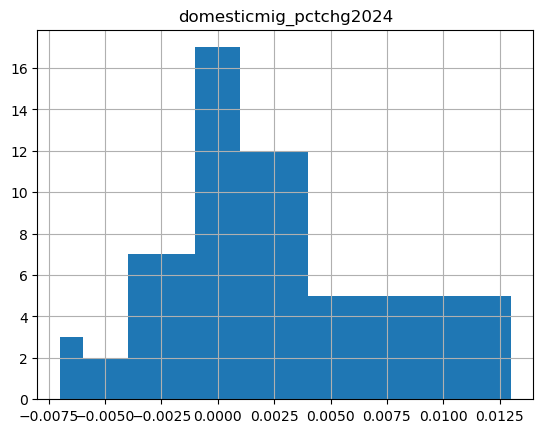

In [64]:
print(net_domesticmigr_df["domesticmig_pctchg2024"].describe())
bin_cutoff_list = [
    -0.007, -0.006, -0.004, -0.001, 0.001, 0.004, 0.006, 0.013
]
net_domesticmigr_df.hist(
    column="domesticmig_pctchg2024", bins=bin_cutoff_list
)

In [67]:
# Add cat_label, fill_color, and label_color columns to net_domesticmigr_df
fig3_fill_color_list = [
    "#de2d26", "#fc9272", "#fee0d2", "white", "#deebf7", "#9ecae1", "#3182bd"
]
fig3_label_color_list = [
    "white", "black", "black", "black", "black", "black", "white"
]
net_domesticmigr_plot_df = net_domesticmigr_df.copy()
net_domesticmigr_plot_df["cat_label"] = ""
net_domesticmigr_plot_df["fill_color"] = ""
net_domesticmigr_plot_df["label_color"] = ""
for bin in range(len(bin_cutoff_list) - 1):
    bin_min = bin_cutoff_list[bin]
    bin_max = bin_cutoff_list[bin + 1]
    if bin == 0:
        net_domesticmigr_plot_df["cat_label"][
            (net_domesticmigr_plot_df["domesticmig_pctchg2024"] < bin_max)
        ] = f"Less than {(bin_max * 100):.1f}%"
        net_domesticmigr_plot_df["fill_color"][
            (net_domesticmigr_plot_df["domesticmig_pctchg2024"] < bin_max)
        ] = fig3_fill_color_list[bin]
        net_domesticmigr_plot_df["label_color"][
            (net_domesticmigr_plot_df["domesticmig_pctchg2024"] < bin_max)
        ] = fig3_label_color_list[bin]
    elif ((bin > 0) and (bin < len(bin_cutoff_list) - 2)):
        net_domesticmigr_plot_df["cat_label"][
            (net_domesticmigr_plot_df["domesticmig_pctchg2024"] >= bin_min) &
            (net_domesticmigr_plot_df["domesticmig_pctchg2024"] < bin_max)
        ] = f"{(bin_min * 100):.1f}% to {(bin_max * 100):.1f}%"
        net_domesticmigr_plot_df["fill_color"][
            (net_domesticmigr_plot_df["domesticmig_pctchg2024"] >= bin_min) &
            (net_domesticmigr_plot_df["domesticmig_pctchg2024"] < bin_max)
        ] = fig3_fill_color_list[bin]
        net_domesticmigr_plot_df["label_color"][
            (net_domesticmigr_plot_df["domesticmig_pctchg2024"] >= bin_min) &
            (net_domesticmigr_plot_df["domesticmig_pctchg2024"] < bin_max)
        ] = fig3_label_color_list[bin]
    elif bin == len(bin_cutoff_list) - 2:
        net_domesticmigr_plot_df["cat_label"][
            (net_domesticmigr_plot_df["domesticmig_pctchg2024"] >= bin_min)
        ] = f"Greater than {(bin_min * 100):.1f}%"
        net_domesticmigr_plot_df["fill_color"][
            (net_domesticmigr_plot_df["domesticmig_pctchg2024"] >= bin_min)
        ] = fig3_fill_color_list[bin]
        net_domesticmigr_plot_df["label_color"][
            (net_domesticmigr_plot_df["domesticmig_pctchg2024"] >= bin_min)
        ] = fig3_label_color_list[bin]

net_domesticmigr_plot_df

state_str state_abbrev  popestimate2023  domesticmig2024  \
0         South Carolina           SC          5387830            68043   
1                  Idaho           ID          1971122            16383   
2               Delaware           DE          1036423             8155   
3         North Carolina           NC         10881189            82288   
4              Tennessee           TN          7148304            48476   
5                 Nevada           NV          3214363            16853   
6                Alabama           AL          5117673            26028   
7                Montana           MT          1131302             5410   
8                Arizona           AZ          7473027            34902   
9               Arkansas           AR          3069463            13465   
10                 Maine           ME          1399646             5329   
11         New Hampshire           NH          1402199             4889   
12              Oklahoma           OK          4063882            14036   
13               Florida           FL         22904868            64017   
14                 Texas           TX         30727890            85267   
15         West Virginia           WV          1770495             4520   
16          South Dakota           SD           918305             2132   
17               Georgia           GA         11064432            25321   
18              Missouri           MO          6208038            12289   
19              Kentucky           KY          4550595             7294   
20               Wyoming           WY           585067              861   
21             Wisconsin           WI          5930405             6332   
22                  Utah           UT          3443222             3220   
23              Colorado           CO          5901339             5422   
24               Indiana           IN          6880131             4268   
25              Virginia           VA          8734685             5284   
26            Washington           WA          7857320             2671   
27                  Iowa           IA          3218414             -231   
28             Minnesota           MN          5753048            -1161   
29                  Ohio           OH         11824034            -2462   
30                Oregon           OR          4253653            -1162   
31          Rhode Island           RI          1103429             -305   
32          North Dakota           ND           789047             -291   
33  District of Columbia           DC           687324             -337   
34            New Mexico           NM          2121164            -1571   
35              Nebraska           NE          1987864            -1498   
36              Michigan           MI         10083356            -7656   
37               Vermont           VT           648708             -511   
38          Pennsylvania           PA         13017721           -11500   
39                Kansas           KS          2951500            -4701   
40           Connecticut           CT          3643023            -6060   
41           Mississippi           MS          2943172            -4939   
42              Maryland           MD          6217062           -18509   
43            New Jersey           NJ          9379642           -35554   
44             Louisiana           LA          4588071           -17405   
45         Massachusetts           MA          7066568           -27480   
46              Illinois           IL         12642259           -56235   
47                Alaska           AK           736510            -3774   
48            California           CA         39198693          -239575   
49              New York           NY         19737367          -120917   
50                Hawaii           HI          1441387            -9321   

    domesticmig_pctchg2024  popestimate2022  domesticmig2023  \
0                 0.012629          5287935       

In [68]:
fig3_title = (
    "Figure 3. 2024 net domestic migration as percent of 2023 population"
)
# fig3_title = ""
output_file(
    "./images/fig3_net_domestic_migration_2024.html",
    title=fig3_title, mode='inline'
)
output_notebook()

# Download U.S. states shape files from US Census Bureau
# https://www.census.gov/geographies/mapping-files/2018/geo/carto-boundary-file.html
us_shapefile_path = (
    "https://github.com/OpenSourceEcon/AR-IndivBusTax25/raw/main/data/" +
    "cb_2018_us_state_20m/cb_2018_us_state_20m.shp"
)
gdf = gpd.GeoDataFrame.from_file(us_shapefile_path)
gdf_json = gdf.to_json()
gjson = json.loads(gdf_json)

# Remove Puerto Rico from data
del(gjson["features"][7])

# Alaska
# Fix positive longitudes
min_lat_ak = 180  # initial value that will be adjusted
min_abs_lon_ak = 180  # initial value that will be adjusted
coords_list = gjson["features"][24]["geometry"]["coordinates"]
for ind_isl, island in enumerate(coords_list):
    for ind_pnt, point in enumerate(island[0]):
        min_lat_ak = np.minimum(min_lat_ak, point[1])
        if point[0] > 0:
            gjson["features"][24]["geometry"][
                "coordinates"
            ][ind_isl][0][ind_pnt][0] = -180 - (180 - point[0])
        else:
            min_abs_lon_ak = np.minimum(min_abs_lon_ak, -point[0])

# Shrink the size of Alaska relative to its southestern most minimum lattitude
# and longitude
shrink_pct_ak = 0.65
coords_list_ak = gjson["features"][24]["geometry"]["coordinates"]
for ind_isl, island in enumerate(coords_list_ak):
    for ind_pnt, point in enumerate(island[0]):
        gjson["features"][24]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][0] = point[0] - shrink_pct_ak * (point[0] +
                                                                min_abs_lon_ak)
        gjson["features"][24]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][1] = point[1] - shrink_pct_ak * (point[1] -
                                                                min_lat_ak)

# Move Alaska closer to the mainland such that the minimum minimum absolute
# longitude and lattitude are (-127, 44)
min_lat_ak_new = 44
min_abs_lon_ak_new = 127
for ind_isl, island in enumerate(coords_list):
    for ind_pnt, point in enumerate(island[0]):
        gjson["features"][24]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][0] = point[0] + (min_abs_lon_ak -
                                                min_abs_lon_ak_new)
        gjson["features"][24]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][1] = point[1] - (min_lat_ak - min_lat_ak_new)

# Hawaii
list_ind_hi = 47
# Get minimum lattitude and minimum absolute longitude for Hawaii
min_lat_hi = 180  # initial value that will be adjusted
min_abs_lon_hi = 180  # initial value that will be adjusted
coords_list = gjson["features"][list_ind_hi]["geometry"]["coordinates"]
for ind_isl, island in enumerate(coords_list):
    for ind_pnt, point in enumerate(island[0]):
        min_lat_hi = np.minimum(min_lat_hi, point[1])
        min_abs_lon_hi = np.minimum(min_abs_lon_hi, -point[0])
# print("Minimum lattitude for Hawaii is", min_lat_hi)
# print("Minimum absolute longitude for Hawaii is", min_abs_lon_hi)

# Increase the size of Hawaii
incr_pct_hi = 0.4
coords_list_hi = gjson["features"][list_ind_hi]["geometry"]["coordinates"]
for ind_isl, island in enumerate(coords_list_hi):
    for ind_pnt, point in enumerate(island[0]):
        gjson["features"][list_ind_hi]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][0] = point[0] + incr_pct_hi * (point[0] +
                                                              min_abs_lon_hi)
        gjson["features"][list_ind_hi]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][1] = point[1] + incr_pct_hi * (point[1] -
                                                              min_lat_hi)

# Move Hawaii closer to the mainland such that the minimum minimum absolute
# longitude and lattitude are (-125, 27)
min_lat_hi_new = 27.5
min_abs_lon_hi_new = 124.5
for ind_isl, island in enumerate(coords_list):
    for ind_pnt, point in enumerate(island[0]):
        gjson["features"][list_ind_hi]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][0] = point[0] + (min_abs_lon_hi -
                                                min_abs_lon_hi_new)
        gjson["features"][list_ind_hi]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][1] = point[1] - (min_lat_hi - min_lat_hi_new)

# Add a state box around Delaware abbreviation DE
st_list_num = 2
de_coord_list = [gjson["features"][st_list_num]["geometry"]["coordinates"]]
new_box_de = [[
    [-75.4, 38.8],
    [-72.4, 38.3],
    [-72.4, 38.9],
    [-70.2, 38.9],
    [-70.2, 37.7],
    [-72.4, 37.7],
    [-72.4, 38.3]
]]
de_coord_list.append(new_box_de)
gjson["features"][st_list_num]["geometry"]["coordinates"] = de_coord_list
gjson["features"][st_list_num]["geometry"]["type"] = "MultiPolygon"

# Add a state box around Washington, DC (District of Columbia) abbreviation DC
st_list_num = 35
dc_coord_list = [gjson["features"][st_list_num]["geometry"]["coordinates"]]
new_box_dc = [[
    [-77.0, 38.9],
    [-73.3, 35.5],
    [-73.3, 36.1],
    [-71.1, 36.1],
    [-71.1, 34.9],
    [-73.3, 34.9],
    [-73.3, 35.5]
]]
dc_coord_list.append(new_box_dc)
gjson["features"][st_list_num]["geometry"]["coordinates"] = dc_coord_list
gjson["features"][st_list_num]["geometry"]["type"] = "MultiPolygon"

# Add a state box around Massachusetts abbreviation MD
st_list_num = 0
md_coord_list = gjson["features"][st_list_num]["geometry"]["coordinates"]
new_box_md = [[
    [-76.8, 39.3],
    [-72.7, 37.0],
    [-72.7, 37.6],
    [-70.5, 37.6],
    [-70.5, 36.4],
    [-72.7, 36.4],
    [-72.7, 37.0]
]]
md_coord_list.append(new_box_md)
gjson["features"][st_list_num]["geometry"]["coordinates"] = md_coord_list

# Add a state box around Massachusetts abbreviation MA
st_list_num = 29
ma_coord_list = gjson["features"][st_list_num]["geometry"]["coordinates"]
new_box_ma = [[
    [-71.7, 42.2],
    [-68.5, 42.2],
    [-68.5, 42.8],
    [-66.3, 42.8],
    [-66.3, 41.6],
    [-68.5, 41.6],
    [-68.5, 42.2]
]]
ma_coord_list.append(new_box_ma)
gjson["features"][st_list_num]["geometry"]["coordinates"] = ma_coord_list

# Add a state box around New Jersey abbreviation NJ
st_list_num = 34
nj_coord_list = [gjson["features"][st_list_num]["geometry"]["coordinates"]]
new_box_nj = [[
    [-74.4, 40.1],
    [-72.0, 39.7],
    [-72.0, 40.3],
    [-69.8, 40.3],
    [-69.8, 39.1],
    [-72.0, 39.1],
    [-72.0, 39.7]
]]
nj_coord_list.append(new_box_nj)
gjson["features"][st_list_num]["geometry"]["coordinates"] = nj_coord_list
gjson["features"][st_list_num]["geometry"]["type"] = "MultiPolygon"

# Add a state box around Rhode Island abbreviation RI
st_list_num = 50
ri_coord_list = gjson["features"][st_list_num]["geometry"]["coordinates"]
new_box_ri = [[
    [-71.5, 41.7],
    [-69.5, 40.4],
    [-69.5, 41.0],
    [-67.3, 41.0],
    [-67.3, 39.8],
    [-69.5, 39.8],
    [-69.5, 40.4]
]]
ri_coord_list.append(new_box_ri)
gjson["features"][st_list_num]["geometry"]["coordinates"] = ri_coord_list

# Merge the state domestic migration percent change data into gjson for each
# state
net_domesticmigr_plot_df
for ind_st, state in enumerate(gjson["features"]):
    st_abbrev = state["properties"]["STUSPS"]
    state["properties"]["netmigr_pct_cat"] = net_domesticmigr_plot_df[
        net_domesticmigr_plot_df["state_abbrev"]==st_abbrev
    ]["cat_label"].iloc[0]
    state["properties"]["net_migr_pct_chg"] = net_domesticmigr_plot_df[
        net_domesticmigr_plot_df["state_abbrev"]==st_abbrev
    ]["domesticmig_pctchg2024"].iloc[0]

fig3_cat_labels = [
    "Less than -0.6%", "-0.6% to -0.4%", "-0.4% to -0.1%", "-0.1% to 0.1%",
    "0.1% to 0.4%", "0.4% to 0.6%", "Greater than 0.6%"
]

source_shapes = {}
for category in fig3_cat_labels:
    source_shapes[category] = {"type": "FeatureCollection", "features": []}

for item in gjson["features"]:
    source_shapes[
        item["properties"]["netmigr_pct_cat"]
    ]['features'].append(item)

TOOLS = "pan, box_zoom, wheel_zoom, hover, save, reset, help"

fig3 = figure(
    title=fig3_title,
    height=500,
    width=950,
    tools=TOOLS,
    # tooltips=[
    #     ("State", @state_names), ("Tax type", @tax_type)
    # ]
    # match_aspect = True,
    min_border = 0,
    x_axis_location = None, y_axis_location = None,
    toolbar_location="right"
)
fig3.toolbar.logo = None
fig3.grid.grid_line_color = None

cmap = CategoricalColorMapper(
    palette=fig3_fill_color_list, factors=fig3_cat_labels
)
for category in fig3_cat_labels:
    source_shape_1 = GeoJSONDataSource(
        geojson = json.dumps(source_shapes[category])
    )
    fig3.patches(
        'xs', 'ys', source=source_shape_1, fill_alpha=0.7,
        fill_color = {'field': 'netmigr_pct_cat', 'transform': cmap},
        line_color ='black', line_width=1.0, line_alpha=0.3,
        hover_line_color="black", hover_line_width=3.0, legend_label=category)

    hover = fig3.select_one(HoverTool)
    hover.point_policy = "follow_mouse"
    hover.tooltips = [
        ("State", "@NAME"),
        ("Pct chg category", "@netmigr_pct_cat"),
        ("2024 net domestic migration (%chg)", "@net_migr_pct_chg{0.00%}")
    ]

# Add 2-letter state abbreviation labels. See Bokeh documentation for labels at
# https://docs.bokeh.org/en/latest/docs/user_guide/basic/annotations.html.
label_lon_lat =[
    ["AL",  -87.40, 32.10],
    ["AK", -135.00, 48.30],
    ["AZ", -112.40, 34.00],
    ["AR",  -93.20, 34.30],
    ["CA", -121.00, 37.00],
    ["CO", -106.50, 38.50],
    ["CT",  -73.40, 41.25],
    ["DE",  -72.10, 37.80],
    ["DC",  -73.00, 35.00],
    ["FL",  -82.40, 28.00],
    ["GA",  -84.20, 32.20],
    ["HI", -126.00, 28.00],
    ["ID", -115.00, 43.00],
    ["IL",  -89.60, 39.50],
    ["IN",  -86.90, 39.60],
    ["IA",  -94.40, 41.60],
    ["KS",  -99.50, 38.00],
    ["KY",  -86.00, 37.00],
    ["LA",  -93.00, 30.20],
    ["ME",  -70.00, 44.50],
    ["MD",  -72.40, 36.50],
    ["MA",  -68.20, 41.80],
    ["MI",  -85.40, 42.70],
    ["MN",  -95.30, 45.50],
    ["MS",  -90.60, 32.10],
    ["MO",  -93.50, 38.00],
    ["MT", -110.50, 46.50],
    ["NE", -100.50, 41.00],
    ["NV", -118.00, 39.00],
    ["NH",  -72.45, 42.70],
    ["NM", -107.00, 34.00],
    ["NJ",  -71.60, 39.30],
    ["NY",  -76.00, 42.50],
    ["NC",  -79.20, 35.00],
    ["ND", -101.50, 46.80],
    ["OH",  -83.80, 39.90],
    ["OK",  -98.00, 35.00],
    ["OR", -121.50, 43.50],
    ["PA",  -78.50, 40.40],
    ["RI",  -69.00, 40.00],
    ["SC",  -81.50, 33.30],
    ["SD", -101.00, 44.00],
    ["TN",  -87.10, 35.40],
    ["TX", -100.00, 31.00],
    ["UT", -112.50, 39.00],
    ["VT",  -73.20, 44.10],
    ["VA",  -79.00, 37.10],
    ["WA", -121.00, 47.00],
    ["WV",  -81.90, 38.00],
    ["WI",  -90.40, 44.00],
    ["WY", -108.50, 42.50]
]
# Add text color element to each state in list based on tax type
for i, state in enumerate(label_lon_lat):
    label_lon_lat[i].append(
        net_domesticmigr_plot_df[
            net_domesticmigr_plot_df["state_abbrev"]==state[0]
        ]["label_color"].iloc[0]
    )
label_abbrev = [state[0] for state in label_lon_lat]
label_lon = [state[1] for state in label_lon_lat]
label_lat = [state[2] for state in label_lon_lat]
label_color = [state[3] for state in label_lon_lat]
state_cds = ColumnDataSource(data=dict(
    lon=label_lon,
    lat=label_lat,
    abbrev=label_abbrev,
    txtcolor=label_color
))

state_labels = LabelSet(
    x='lon', y='lat', text='abbrev', text_font_size="8pt",
    text_color='txtcolor', text_font_style="bold", x_offset=0, y_offset=0,
    source=state_cds
)

fig3.add_layout(state_labels)

# Legend properties
fig3.legend.click_policy = 'mute'
fig3.legend.location = "center_left"

note_text_list3 = [
    (
        '  Source: Richard W. Evans (@RickEcon), updated Nov. 21, 2025. ' +
        'Data are from US Census Bureau, U-Haul, United Van Lines. See also'
    ),
    (
        '      Tax Foundation, Loughead (2025).'
    )
]
for note_text in note_text_list3:
    caption = Title(
        text=note_text, align='left', text_font_size='11pt',
        text_font_style='italic',
        text_color='#434244',
        # text_font='Open Sans'
    )
    fig3.add_layout(caption, 'below')

show(fig3)

Loading BokehJS ...

## 3. Create Figures 4 and 5

### 3.1. Figure 4. Rainy Day Fund and Total Reserves as Percentages of General-Fund Expenditures, Missouri and 50-State Median: 2000-2024

Get the Pew state rainy day fund data. This does not include District of Columbia. The 2023 data is now final. The 2024 data is labeled as "Projected" which means projected based on enacted legislation.

In [25]:
# Read in the Pew data on rainy day funds by year and state from worksheet
rain_totbal_path = (
    "https://github.com/OpenSourceEcon/AR-IndivBusTax25/blob/main/data/" +
    "Pew_ReservesData_2025.csv?raw=true"
)

In [26]:
# Create a DataFrame of just the rainy day funds in $ by state and by year
rain_dol_df = pd.read_csv(
    rain_totbal_path,
    skiprows=5,
    skipfooter=4,
    index_col=0,
    usecols=[
        0, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130
    ],
    names=[
        'state', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
        '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
        '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024',
        '2025'
    ]
)
rain_dol_df

2000         2001         2002        2003  \
state                                                               
Alabama             2500000      7500000    261000000    68000000   
Alaska           2734200000   2994800000   2114000000  2092500000   
Arizona           407800000    391500000     65000000    13800000   
Arkansas                  0            0            0           0   
California       8665500000   1563800000            0           0   
Colorado          583400000            0            0           0   
Connecticut       564000000    594700000            0           0   
Delaware          114000000    126000000    128000000   129000000   
Florida          1666100000    894000000    941000000   958900000   
Georgia           551300000    734400000    700000000   184700000   
Hawaii              5800000     21200000     50000000           0   
Idaho              36000000     53200000     53000000           0   
Illinois                  0    225000000    226000000   225700000   
Indiana           539900000    525900000    269000000   278500000   
Iowa              443800000    405200000    166000000           0   
Kansas                    0            0            0           0   
Kentucky          278600000    239800000            0     5100000   
Louisiana          59000000    196700000    266000000           0   
Maine             143700000    143700000     20000000           0   
Maryland          582000000    888000000    548000000   490200000   
Massachusetts    1608400000   2294200000    882000000   641300000   
Michigan         1264400000    994200000    145000000           0   
Minnesota        1379700000   1574200000            0   103700000   
Mississippi       231900000    189500000    111000000    22600000   
Missouri          293400000    452000000    469900000   462400000   
Montana                   0            0            0           0   
Nebraska          142200000    170200000    110000000    59100000   
Nevada            136300000    136300000    136000000     1300000   
New Hampshire      20000000     55200000            0    17300000   
New Jersey        698200000    720000000            0           0   
New Mexico                0            0            0           0   
New York          547000000    627000000    710000000   710000000   
North Carolina     37500000    157500000            0   150000000   
North Dakota              0     40000000     25000000     6000000   
Ohio             1002500000   1010600000    428000000   180700000   
Oklahoma          157600000    340100000     72000000      100000   
Oregon                    0            0            0           0   
Pennsylvania     1097400000   1126700000            0    70000000   
Rhode Island       71300000     79700000     82000000    83600000   
South Carolina    145400000     60500000            0           0   
South Dakota       36600000    110600000    116000000   106500000   
Tennessee         165100000    178000000    178000000   178000000   
Texas              84700000    196500000    904000000   560500000   
Utah              109700000    120300000     20000000    26600000   
Vermont            41400000     43000000     13000000    23600000   
Virginia          574600000    715600000    472400000   247500000   
Washington        754000000    462100000    116000000           0   
West Virginia      73200000     79100000     56000000    57800000   
Wisconsin                 0            0            0           0   
Wyoming            38700000     64800000     65000000   247000000   
50-state        28088800000  22003300000  10918300000  8402000000   

                       2004         2005         2006         2007  \
state                                                                
Alabama           104000000    157000000    418700000    676600000   
Alaska           2155100000   2274200000   2267100000   3015200000   
Arizona            13500000    160800000    501600000    677000000   
Arkansas       

In [27]:
# Create a DataFrame of just the rainy day funds balances as a percent of
# general fund expenditures by state and by year
rain_pct_df = pd.read_csv(
    rain_totbal_path,
    skiprows=5,
    skipfooter=4,
    index_col=0,
    usecols=[
        0, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156
    ],
    names=[
        'state', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
        '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
        '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024',
        '2025'
    ]
)
rain_pct_df

2000     2001     2002     2003     2004     2005     2006  \
state                                                                           
Alabama         0.00048  0.00144  0.04901  0.01243  0.01897  0.02594  0.06015   
Alaska          1.20891  1.31738  0.88382  0.83844  0.92928  0.74449  0.69817   
Arizona         0.06783  0.06145  0.01025  0.00229  0.00207  0.02131  0.05721   
Arkansas        0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
California      0.13032  0.02004  0.00000  0.00000  0.00000  0.11418  0.10996   
Colorado        0.09736  0.00000  0.00000  0.00000  0.02141  0.00000  0.00000   
Connecticut     0.05168  0.04975  0.00000  0.00000  0.02385  0.04862  0.07645   
Delaware        0.05076  0.05187  0.05216  0.05257  0.05345  0.05251  0.05065   
Florida         0.08980  0.04455  0.04910  0.04674  0.04510  0.04043  0.04110   
Georgia         0.04000  0.04773  0.04981  0.01153  0.00324  0.01572  0.04454   
Hawaii          0.00181  0.00630  0.01368  0.00000  0.01406  0.01293  0.01143   
Idaho           0.02142  0.02909  0.02677  0.00000  0.00000  0.00758  0.04897   
Illinois        0.00000  0.00918  0.00994  0.01031  0.01177  0.01244  0.01141   
Indiana         0.06021  0.05653  0.02763  0.02702  0.02154  0.02682  0.02745   
Iowa            0.09318  0.08306  0.03616  0.00000  0.03608  0.04901  0.07804   
Kansas          0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
Kentucky        0.04254  0.03406  0.00000  0.00071  0.00696  0.00374  0.01411   
Louisiana       0.01015  0.03132  0.04100  0.00000  0.03540  0.06479  0.08801   
Maine           0.06202  0.05433  0.00780  0.00000  0.01249  0.01688  0.02782   
Maryland        0.06451  0.08680  0.05006  0.04738  0.04845  0.04629  0.06148   
Massachusetts   0.07719  0.10362  0.03868  0.02858  0.04978  0.09058  0.10575   
Michigan        0.13204  0.10229  0.01589  0.00000  0.00936  0.00022  0.00023   
Minnesota       0.12022  0.12393  0.00000  0.00746  0.07375  0.09221  0.07159   
Mississippi     0.06598  0.05241  0.03102  0.00654  0.01142  0.00541  0.01701   
Missouri        0.03992  0.05847  0.06148  0.07245  0.06668  0.06506  0.06919   
Montana         0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
Nebraska        0.06066  0.06869  0.04233  0.02257  0.03378  0.06514  0.09383   
Nevada          0.08480  0.07414  0.07198  0.00064  0.03014  0.05020  0.06272   
New Hampshire   0.01946  0.05193  0.00000  0.01373  0.01335  0.01306  0.05174   
New Jersey      0.03588  0.03460  0.00000  0.00000  0.01159  0.01037  0.01997   
New Mexico      0.00000  0.00000  0.00000  0.00000  0.10114  0.14558  0.14741   
New York        0.01472  0.01579  0.01722  0.01888  0.01888  0.01999  0.02030   
North Carolina  0.00271  0.01171  0.00000  0.01083  0.01816  0.01979  0.03685   
North Dakota    0.00000  0.04866  0.02900  0.00698  0.00000  0.11062  0.10352   
Ohio            0.05210  0.04780  0.01979  0.00798  0.00758  0.02315  0.04065   
Oklahoma        0.03467  0.07058  0.01435  0.00002  0.04467  0.09330  0.08960   
Oregon          0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
Pennsylvania    0.05687  0.05673  0.00000  0.00343  0.01189  0.01427  0.02076   
Rhode Island    0.03196  0.03210  0.03094  0.03107  0.03092  0.03106  0.03104   
South Carolina  0.02820  0.01096  0.00000  0.00000  0.00518  0.01482  0.02722   
South Dakota    0.04750  0.13778  0.13650  0.12050  0.17769  0.13578  0.12999   
Tennessee       0.02504  0.02537  0.02368  0.02249  0.02654  0.03022  0.03586   
Texas           0.00308  0.00678  0.03024  0.01828  0.01244  0.00023  0.01265   
Utah            0.03261  0.03193  0.00536  0.00752  0.01872  0.03673  0.05625   
Vermont         0.04844  0.04882  0.01491  0.02657  0.04861  0.04411  0.04652   
Virginia        0.05093  0.05729  0.03923  0.02042  0.02745  0.03475  0.06990   
Washington      0.07378  0.04268  0.01034  0.00000  0.00000  0.00000  0.00031   
West Virginia   0.02774  0.02922  0.01988  0.01971

In [28]:
# Create a DataFrame of just the total balances and reserves in $ by state and
# by year
totbal_dol_df = pd.read_csv(
    rain_totbal_path,
    skiprows=5,
    skipfooter=4,
    index_col=0,
    usecols=[
        0, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
        44, 45, 46, 47, 48, 49, 50, 51, 52
    ],
    names=[
        'state', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
        '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
        '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024',
        '2025'
    ]
)
totbal_dol_df

2000         2001         2002         2003  \
state                                                                
Alabama           103600000     74300000    280200000    180500000   
Alaska           2734200000   2994800000   2114000000   2092500000   
Arizona           611200000    404700000     65700000    206000000   
Arkansas                  0            0            0            0   
California       9139000000   3037000000  -2133300000   1607300000   
Colorado          798300000    469500000    137600000    224900000   
Connecticut       564000000    594700000            0            0   
Delaware          338000000    510000000    481700000    464100000   
Florida          2155900000   1382700000   1925100000   1641300000   
Georgia          2508700000   2601500000   2554400000   1267900000   
Hawaii            277900000    370300000    183900000    117200000   
Idaho             218400000    238000000     54400000     15700000   
Illinois         1516700000   1350700000    481800000    542700000   
Indiana          1372500000    544500000    269200000    720100000   
Iowa              619400000    405200000    254600000    -45800000   
Kansas            378000000    365700000     12100000    122700000   
Kentucky          453900000    240000000     23500000    167600000   
Louisiana         -22000000    269800000    284100000     23000000   
Maine             444600000    182500000     34300000     28900000   
Maryland         1518000000   1426000000    857000000    612900000   
Massachusetts    1905300000   3011000000   1387900000    752400000   
Michigan         1476200000   1022300000    259700000    174000000   
Minnesota        2125400000   1574200000   1130300000    368900000   
Mississippi       274300000    207600000    119000000     63500000   
Missouri          463400000    561000000    634900000    678400000   
Montana           176000000    172900000     81300000     43100000   
Nebraska          457800000    405900000    166100000     61800000   
Nevada            304600000    262000000    226500000    109000000   
New Hampshire      24000000     55200000    -37900000     17300000   
New Jersey       1284000000   1290000000    292300000    373000000   
New Mexico        191500000    449000000    320300000    245000000   
New York         1167000000   1098000000   1032000000    815000000   
North Carolina     37500000    157500000      3800000    400600000   
North Dakota       60000000    102000000     20000000     21000000   
Ohio             1198600000   1217100000    536400000    233200000   
Oklahoma          437600000    629700000    146900000     34400000   
Oregon            373200000    362900000  -1068400000     93100000   
Pennsylvania     1707900000   1462100000    142800000    279300000   
Rhode Island      163200000    210900000    122700000    126600000   
South Carolina    573400000    134000000     50400000     45700000   
South Dakota       36600000    110600000    115600000    106500000   
Tennessee         216600000    209300000    189500000    242100000   
Texas            3850500000   4190100000   3330100000    648200000   
Utah              223100000    132700000     20600000     42700000   
Vermont            41400000     47100000     12800000     23600000   
Virginia         1227500000    715600000    605800000    333600000   
Washington       1239300000   1061200000    553400000    404600000   
West Virginia     221000000    240500000    253500000    253800000   
Wisconsin         835700000    207500000     53800000   -282200000   
Wyoming           214500000     70000000     74800000    250600000   
50-state        48237390000  38831890000  18657200000  16948300000   

                       2004         2005         2006         2007  \
state                                                                
Alabama           450600000    821000000   1368100000   1191400000   
Alaska           2181600000   2282800000   2267100000   3015200000   
Arizona           373800000    7

In [29]:
# Create a DataFrame of just the total balances and reserves as a percent of
# general fund expenditures by state and by year
totbal_pct_df = pd.read_csv(
    rain_totbal_path,
    skiprows=5,
    skipfooter=4,
    index_col=0,
    usecols=[
        0, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
        70, 71, 72, 73, 74, 75, 76, 77, 78
    ],
    names=[
        'state', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
        '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
        '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024',
        '2025'
    ]
)
totbal_pct_df

2000     2001     2002     2003     2004     2005     2006  \
state                                                                           
Alabama         0.01986  0.01425  0.05262  0.03298  0.08218  0.13567  0.19653   
Alaska          1.20891  1.31738  0.88382  0.83844  0.94071  0.74731  0.69817   
Arizona         0.10166  0.06353  0.01037  0.03419  0.05737  0.10600  0.17655   
Arkansas        0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
California      0.13744  0.03891 -0.02779  0.02074  0.04570  0.12072  0.11809   
Colorado        0.13322  0.07039  0.02058  0.03804  0.06089  0.05488  0.14088   
Connecticut     0.05168  0.04975  0.00000  0.00000  0.02385  0.04862  0.07645   
Delaware        0.15049  0.20996  0.19630  0.18911  0.25297  0.24849  0.21714   
Florida         0.11620  0.06891  0.10044  0.08001  0.15978  0.18653  0.23292   
Georgia         0.18203  0.16908  0.18177  0.07912  0.05461  0.07524  0.11326   
Hawaii          0.08682  0.11006  0.05030  0.03080  0.06213  0.12916  0.16794   
Idaho           0.12994  0.13015  0.02748  0.00815  0.05033  0.10917  0.18524   
Illinois        0.06570  0.05514  0.02119  0.02479  0.01953  0.03484  0.03580   
Indiana         0.15305  0.05853  0.02765  0.06985  0.02156  0.03689  0.06179   
Iowa            0.13005  0.08306  0.05546 -0.01011  0.07283  0.08512  0.10778   
Kansas          0.08655  0.08256  0.00271  0.02966  0.07587  0.10207  0.14274   
Kentucky        0.06931  0.03409  0.00332  0.02335  0.04117  0.06464  0.09488   
Louisiana      -0.00379  0.04296  0.04379  0.00357  0.04189  0.10020  0.19489   
Maine           0.19188  0.06900  0.01337  0.01141  0.01812  0.02898  0.03287   
Maryland        0.16826  0.13939  0.07829  0.05924  0.09261  0.15055  0.17182   
Massachusetts   0.09144  0.13599  0.06087  0.03353  0.08284  0.13034  0.15746   
Michigan        0.15416  0.10518  0.02846  0.01992  0.00936  0.02573  0.00051   
Minnesota       0.18520  0.12393  0.08862  0.02655  0.09327  0.18810  0.11666   
Mississippi     0.07804  0.05741  0.03325  0.01837  0.01225  0.01955  0.02515   
Missouri        0.06305  0.07257  0.08307  0.10630  0.13993  0.10719  0.16673   
Montana         0.15929  0.13574  0.05996  0.03358  0.10550  0.21791  0.26942   
Nebraska        0.19530  0.16381  0.06392  0.02360  0.10231  0.21339  0.28795   
Nevada          0.18947  0.14252  0.11988  0.05352  0.12277  0.10195  0.18251   
New Hampshire   0.02335  0.05193 -0.03229  0.01373  0.02517  0.07511  0.07123   
New Jersey      0.06599  0.06199  0.01329  0.01583  0.03424  0.02795  0.06346   
New Mexico      0.05649  0.11731  0.07911  0.06048  0.10108  0.14558  0.14741   
New York        0.03140  0.02766  0.02504  0.02167  0.02560  0.05837  0.07005   
North Carolina  0.00271  0.01171  0.00028  0.02891  0.03784  0.05007  0.08076   
North Dakota    0.07762  0.12409  0.02320  0.02442  0.08601  0.18695  0.30642   
Ohio            0.06229  0.05756  0.02480  0.01029  0.01418  0.02873  0.06606   
Oklahoma        0.09628  0.13068  0.02929  0.00739  0.05843  0.09522  0.11376   
Oregon          0.07698  0.06914 -0.18549  0.02409 -0.08086  0.06870  0.08952   
Pennsylvania    0.08851  0.07361  0.00699  0.01369  0.01540  0.03009  0.04160   
Rhode Island    0.07316  0.08495  0.04630  0.04704  0.03984  0.04428  0.04350   
South Carolina  0.11121  0.02428  0.00975  0.00915  0.01645  0.10514  0.17515   
South Dakota    0.04750  0.13778  0.13603  0.12050  0.17769  0.13578  0.12999   
Tennessee       0.03286  0.02984  0.02521  0.03059  0.09323  0.08094  0.11794   
Texas           0.14006  0.14447  0.11141  0.02114  0.06170  0.12607  0.23322   
Utah            0.06633  0.03522  0.00552  0.01208  0.03391  0.06328  0.05625   
Vermont         0.04844  0.05348  0.01468  0.02657  0.04861  0.04411  0.04652   
Virginia        0.10880  0.05729  0.05030  0.02753  0.04957  0.07485  0.16030   
Washington      0.12127  0.09802  0.04935  0.03569  0.04362  0.07117  0.05163   
West Virginia   0.08374  0.08885  0.09000  0.08654

In [ ]:
rain_pct_50_df = rain_pct_df.loc["50-state", :].to_frame().reset_index()
rain_pct_50_df.rename(
    columns = {"index":"year", "50-state":"fraction"}, inplace = True
)
rain_pct_50_df["percent"] = 100 * rain_pct_50_df["fraction"]
rain_pct_50_df["series"] = "50-state median Rainy Day Fund"

rain_pct_ar_df = rain_pct_df.loc["Arkansas", :].to_frame().reset_index()
rain_pct_ar_df = rain_pct_ar_df.rename(
    columns = {"index":"year", "Arkansas":"fraction"}
)
rain_pct_ar_df["percent"] = 100 * rain_pct_ar_df["fraction"]
rain_pct_ar_df["series"] = "Arkansas Rainy Day Fund"

totbal_pct_50_df = \
    totbal_pct_df.loc["50-state", :].to_frame().reset_index()
totbal_pct_50_df = totbal_pct_50_df.rename(
    columns = {"index":"year", "50-state":"fraction"}
)
totbal_pct_50_df["percent"] = 100 * totbal_pct_50_df["fraction"]
totbal_pct_50_df["series"] = "50-state median total reserve balances"

totbal_pct_ar_df = totbal_pct_df.loc[
    "Arkansas", :
].to_frame().reset_index()
totbal_pct_ar_df = totbal_pct_ar_df.rename(
    columns = {'index':'year', "Arkansas":"fraction"}
)
totbal_pct_ar_df["percent"] = 100 * totbal_pct_ar_df["fraction"]
totbal_pct_ar_df["series"] = "Arkansas total reserve balances"

# Merge the four DataFrames to save the joint dataframe as a .csv
fig4_source_df = rain_pct_50_df[['year', 'percent']].rename(
    columns={'percent':'rain_50m_pct'}
)
fig4_source_df = pd.merge(
    fig4_source_df,
    rain_pct_ar_df[['year', 'percent']].rename(
        columns={'percent':'rain_ar_pct'}
    ),
    on='year', how='inner'
)
fig4_source_df = pd.merge(
    fig4_source_df,
    totbal_pct_50_df[['year', 'percent']].rename(
        columns={'percent':'totbal_50m_pct'}
    ),
    on='year', how='inner'
)
fig4_source_df = pd.merge(
    fig4_source_df,
    totbal_pct_ar_df[['year', 'percent']].rename(
        columns={'percent':'totbal_ar_pct'}
    ),
    on='year', how='inner'
)
# Set zeros to NaN
fig4_source_df = fig4_source_df.replace(0, np.nan)

fig4_source_df.to_csv('./data/fig4_source.csv', index=False)

fig4_source_df

year  rain_50m_pct  rain_ar_pct  totbal_50m_pct  totbal_ar_pct
0   2000      4.127000          NaN        8.767000            NaN
1   2001      4.614000          NaN        7.148000            NaN
2   2002      1.656000          NaN        2.887000            NaN
3   2003      0.722000          NaN        2.656000            NaN
4   2004      1.844000          NaN        5.247000            NaN
5   2005      2.460000          NaN        9.017000            NaN
6   2006      4.553000          NaN       11.802000            NaN
7   2007      4.739000          NaN       11.328000            NaN
8   2008      4.835000          NaN        8.292000            NaN
9   2009      2.728000          NaN        4.583000            NaN
10  2010      1.638000          NaN        4.488000            NaN
11  2011      1.761000          NaN        6.368000            NaN
12  2012      2.486000          NaN        7.908000            NaN
13  2013      3.558000          NaN        9.957000            NaN
14  2014      4.525000          NaN        7.293000            NaN
15  2015      4.918000          NaN        9.204000            NaN
16  2016      5.340000          NaN        9.740000        3.41800
17  2017      5.614000     2.307000        8.316000        2.30700
18  2018      6.548000     2.304000       11.725000        2.30400
19  2019      7.930000     2.711000       13.994000        7.96100
20  2020      8.440000     3.217000       12.712000        3.27300
21  2021     10.288000     3.560000       27.124000       19.58900
22  2022     11.484000    20.721000       39.508000       48.04400
23  2023     12.663885    25.390502       34.962173       44.66411
24  2024     14.582000    29.263000       28.869000       40.52300
25  2025     12.850000    28.755000       21.955000       33.17000

In [69]:
# Create Bokeh plot Fig 4: Arkansas Rainy Day fund and total reserves as
# a percentage of general fund expenditures: 2000-2025
fig4_title_lst = [
    ("Figure 4. Arkansas Rainy Day fund and total reserves as a"),
    ("percentage of general fund expenditures: 2000-2025"),
]
# fig4_title_lst = []
fig4_title_short = "Figure 4. AR Rainy Day fund and total reserves"
filename_fig4 = "fig4_ar_raintotbal_tseries.html"
output_file(
    os.path.join(image_dir, filename_fig4),
    title=fig4_title_short,
    mode="inline",
)
output_notebook()

# Format the tooltip
tooltips_fig4 = [
    ("Series:", "@series"),
    ("Year:", "@year"),
    ("Pct. of Gen. Fund Exps.:", "@fraction{0.0%}")
]

min_year = 2000
max_year = 2025
min_pct = 2.0
max_pct = 0.0
pct_buffer = 0.05
fig4_height = 500
fig4_width = 800

var_list = [rain_pct_ar_df, rain_pct_50_df, totbal_pct_ar_df, totbal_pct_50_df]
color_list = ["#3477A5", "#D5AB53", "#3477A5", "#D5AB53"]
marker_list = ["circle", "circle", "square", "square"]
legend_label_list = [
    "Rainy day fund, Arkansas",
    "Rainy day fund, 50-state median",
    "Total balances, Arkansas",
    "Total balances, 50-state median"
]
cds_list = []

for k, df in enumerate(var_list):
    min_pct = np.minimum(min_pct, df["percent"].min())
    max_pct = np.maximum(max_pct, df["percent"].max())
    cds_list.append(ColumnDataSource(df))

fig4 = figure(
    height=fig4_height,
    width=fig4_width,
    x_axis_label='Year',
    x_range=(min_year - 1, max_year + 1.6),
    y_axis_label='Percent of general fund expenditures',
    y_range=(min_pct - pct_buffer * (max_pct - min_pct),
             max_pct + pct_buffer * (max_pct - min_pct)),
    tools=["save", "help"],
    toolbar_location="right"
)
fig4.toolbar.logo = None

# Turn off any pan, drag, or scrolling ability
fig4.toolbar.active_drag = None
fig4.toolbar.active_scroll = None
fig4.toolbar.active_tap = None

# Set title font size and axes font sizes
fig4.xaxis.axis_label_text_font_size = '12pt'
fig4.xaxis.major_label_text_font_size = '12pt'
fig4.xaxis.major_label_text_color = '#434244'
fig4.yaxis.axis_label_text_font_size = '12pt'
fig4.yaxis.major_label_text_font_size = '12pt'
fig4.yaxis.major_label_text_color = '#434244'

# Modify tick intervals for X-axis and Y-axis
fig4.xaxis.ticker = SingleIntervalTicker(interval=2, num_minor_ticks=2)
fig4.xaxis.axis_line_color = '#434244'
fig4.xaxis.major_tick_line_color = '#434244'
fig4.xaxis.minor_tick_line_color = '#434244'
fig4.xgrid.ticker = SingleIntervalTicker(interval=2)
fig4.yaxis.ticker = SingleIntervalTicker(interval=10, num_minor_ticks=5)
fig4.yaxis.axis_line_color = '#434244'
fig4.yaxis.major_tick_line_color = '#434244'
fig4.yaxis.minor_tick_line_color = '#434244'
fig4.ygrid.ticker = SingleIntervalTicker(interval=10)

# Create lines and markers for time series
for k, yvar in enumerate(var_list):
    fig4.line(x='year', y='percent', source=cds_list[k], color=color_list[k],
              line_width=4, alpha=0.7)
    fig4.scatter(x='year', y='percent', source=cds_list[k], size=10,
                 line_width=1, line_color='black', fill_color=color_list[k],
                 marker=marker_list[k], line_alpha=0.7, fill_alpha=0.7,
                 legend_label=legend_label_list[k])

fig4.segment(x0=2024.4, y0=min_pct - pct_buffer * (max_pct - min_pct),
             x1=2024.4, y1=max_pct + pct_buffer * (max_pct - min_pct),
             color='#434244', line_dash='6 2', line_width=2)

label_projected = Label(
    x=2024.5, y=17.0, x_units='data', y_units='data', text='Projected',
    text_font_size='9pt', text_color='#434244'
)
fig4.add_layout(label_projected)

# Add legend
fig4.legend.location = 'top_center'
fig4.legend.border_line_width = 1
fig4.legend.border_line_color = '#434244'
fig4.legend.border_line_alpha = 1
fig4.legend.label_text_font_size = '12pt'
fig4.legend.label_text_color = '#434244'

# Add title and subtitle to the plot doing reverse loop through items in
# fig_title_lst
for title_line_str in fig4_title_lst[::-1]:
    fig4.add_layout(
        Title(
            text=title_line_str,
            text_font_style="bold",
            text_color='#434244',
            text_font_size="15pt",
            align="center",
        ),
        "above",
    )

# Add notes below image
note_text_list4 = [
    (
        'Source: Pew Charitable Trusts, "Fiscal 50: Reserves and '+
        'Balances," Oct. 15, 2025, accessed Nov. 21, 2025.'
    )
]
for note_text in note_text_list4:
    caption = Title(
        text=note_text, align='left', text_font_size='11pt',
        text_font_style='italic',
        text_color='#434244',
        # text_font='Open Sans'
    )
    fig4.add_layout(caption, 'below')

# Add the HoverTool to the figure
fig4.add_tools(
    HoverTool(
        tooltips=tooltips_fig4,
        visible=False
    )
)

show(fig4)

Loading BokehJS ...

### 3.2. Figure 5. Estimated 2025 Rainy Day Fund Balances and Total Reserves and Balances as Percentages of General-Fund Expenditures

In [70]:
rain_pct_2025_df = rain_pct_df.loc[:'Wyoming', '2025'].to_frame().reset_index()
rain_pct_2025_df = rain_pct_2025_df.rename(
    columns = {"index": "state", "2025": "rain_frac"}
)
rain_pct_2025_df["rain_pct"] = 100 * rain_pct_2025_df["rain_frac"]
rain_pct_2025_df = rain_pct_2025_df.drop('rain_frac', axis=1)

rain_dol_2025_df = rain_dol_df.loc[:'Wyoming', '2025'].to_frame().reset_index()
rain_dol_2025_df = rain_dol_2025_df.rename(
    columns = {"index": "state", "2025": "rain_dol"}
)

totbal_pct_2025_df = \
    totbal_pct_df.loc[:'Wyoming', '2025'].to_frame().reset_index()
totbal_pct_2025_df = totbal_pct_2025_df.rename(
    columns = {"index": "state", "2025": "totbal_frac"}
)
totbal_pct_2025_df["totbal_pct"] = 100 * totbal_pct_2025_df["totbal_frac"]
totbal_pct_2025_df = totbal_pct_2025_df.drop('totbal_frac', axis=1)

totbal_dol_2025_df = \
    totbal_dol_df.loc[:'Wyoming', '2025'].to_frame().reset_index()
totbal_dol_2025_df = totbal_dol_2025_df.rename(
    columns = {"index": "state", "2025": "totbal_dol"}
)

# Merge the four DataFrames
rain_totbal_pct_dol_2025_df = rain_pct_2025_df.copy()
rain_totbal_pct_dol_2025_df = pd.merge(
    rain_totbal_pct_dol_2025_df, rain_dol_2025_df, on='state', how='inner'
)
rain_totbal_pct_dol_2025_df["rain_color"] = "#D5AB53"
rain_totbal_pct_dol_2025_df["rain_color"][
    rain_totbal_pct_dol_2025_df["state"]=="Arkansas"
] = "#EED17E"
rain_totbal_pct_dol_2025_df = pd.merge(
    rain_totbal_pct_dol_2025_df, totbal_pct_2025_df, on='state', how='inner'
)
rain_totbal_pct_dol_2025_df = pd.merge(
    rain_totbal_pct_dol_2025_df, totbal_dol_2025_df, on='state', how='inner'
)
rain_totbal_pct_dol_2025_df["totbal_color"] = "#3477A5"
rain_totbal_pct_dol_2025_df["totbal_color"][
    rain_totbal_pct_dol_2025_df["state"]=="Arkansas"
] = "#74AAC7"

# Create a new variable that is totbal_pct - rain_pct
rain_totbal_pct_dol_2025_df["totbal_rain_pct_dif"] = (
    rain_totbal_pct_dol_2025_df["totbal_pct"] -
    rain_totbal_pct_dol_2025_df["rain_pct"]
)

# Sort by total reserves balances percent
rain_totbal_pct_dol_2025_sorted_df = rain_totbal_pct_dol_2025_df.sort_values(
    by=['totbal_pct', 'rain_pct', 'state'], ascending=[True, True, True]
)

rain_totbal_pct_dol_2025_sorted_df.to_csv(
    os.path.join(data_dir, "fig5_source.csv"), index=False
)
rain_totbal_pct_dol_2025_sorted_df

state  rain_pct     rain_dol rain_color  totbal_pct   totbal_dol  \
46      Washington     3.518   1255100000    #D5AB53       5.915   2110200000   
12        Illinois     4.306   2347000000    #D5AB53       8.450   4606000000   
38    Rhode Island     5.252    294700000    #D5AB53       8.596    482300000   
19        Maryland     7.932   2184900000    #D5AB53       8.612   2372000000   
13         Indiana     7.810   1795400000    #D5AB53       9.322   2143100000   
40    South Dakota     9.326    242000000    #D5AB53       9.326    242000000   
23     Mississippi     9.516    669000000    #D5AB53       9.516    669000000   
28   New Hampshire    10.317    211500000    #D5AB53      10.317    211500000   
5         Colorado    11.330   2141100000    #D5AB53      11.330   2141100000   
43            Utah     9.313   1186600000    #D5AB53      11.347   1445700000   
32  North Carolina    11.382   3610000000    #D5AB53      11.534   3658100000   
45        Virginia    12.994   4749500000    #D5AB53      13.031   4762900000   
17       Louisiana     8.572   1071000000    #D5AB53      13.570   1695500000   
29      New Jersey     0.000            0    #D5AB53      13.572   7790300000   
2          Arizona     9.407   1544800000    #D5AB53      14.472   2376600000   
34            Ohio    12.706   3922300000    #D5AB53      15.175   4684600000   
6      Connecticut    18.311   4255200000    #D5AB53      18.311   4255200000   
41       Tennessee     9.272   2150000000    #D5AB53      18.509   4292000000   
21        Michigan    13.976   2148600000    #D5AB53      18.670   2870200000   
44         Vermont    19.330    458600000    #D5AB53      19.330    458600000   
8          Florida     7.561   4440500000    #D5AB53      19.454  11425500000   
4       California    11.851  27500100000    #D5AB53      19.608  45500700000   
18           Maine    17.565    968300000    #D5AB53      19.975   1101200000   
22       Minnesota     9.883   3527400000    #D5AB53      20.366   7269000000   
37    Pennsylvania    15.638   7491000000    #D5AB53      21.679  10385000000   
24        Missouri     6.053    955700000    #D5AB53      22.231   3510100000   
20   Massachusetts    16.017   8227300000    #D5AB53      24.900  12790600000   
10          Hawaii    13.862   1566800000    #D5AB53      25.824   2918800000   
25         Montana    13.778    521800000    #D5AB53      27.181   1029300000   
26        Nebraska    16.025    877200000    #D5AB53      27.440   1502000000   
11           Idaho    23.883   1257900000    #D5AB53      28.673   1510200000   
30      New Mexico    28.680   3709700000    #D5AB53      28.680   3709700000   
16        Kentucky    28.034   4545100000    #D5AB53      29.224   4738100000   
48       Wisconsin     9.023   1899000000    #D5AB53      29.301   6166800000   
36          Oregon    17.322   2916000000    #D5AB53      32.693   5503500000   
3         Arkansas    28.755   1814900000    #EED17E      33.170   2093500000   
14            Iowa    10.399    929900000    #D5AB53      33.483   2994200000   
15          Kansas    16.196   1763600000    #D5AB53      35.242   3837500000   
9          Georgia    14.078   5466300000    #D5AB53      35.675  13851700000   
39  South Carolina    10.548   1441600000    #D5AB53      40.703   5562700000   
7         Delaware     5.008    348700000    #D5AB53      40.966   2852600000   
0         Alabama     23.477   3199400000    #D5AB53      41.241   5620300000   
35        Oklahoma    19.158   2028900000    #D5AB53      43.386   4594700000   
27          Nevada    19.531   1243600000    #D5AB53      44.328   2822600000   
31        New York     8.359   8756000000    #D5AB53      51.035  53456000000   
1           Alaska    52.325   2884000000    #D5AB53      52.325   2884000000   
47   West Virginia    22.769   1316800000    #D5AB53      52.369   3028700000   
42           Texas    28.274  24282300000    #D5AB53      55.944  48046200000   
33    North Dakota    32.593    914600000   

In [71]:
# Create Bokeh plot Fig 5: State 2025 Rainy day Fund Balances and Total Fund
# Balances as Percent of General Fund Expenditures
fig5_title_lst = [
    ("Figure 5. State 2025 Rainy day Fund Balances and Total"),
    ("Fund Balances as Percent of General Fund Expenditures")
]
# fig5_title_lst = []
fig5_title_short = "Figure 5. State 2025 Rainy Day fund and Total Reserves"
filename_fig5 = "fig5_rain_totbal_pct_2025.html"
output_file(
    os.path.join(image_dir, filename_fig5),
    title=fig5_title_short,
    mode="inline",
)
output_notebook()

states = rain_totbal_pct_dol_2025_sorted_df['state'].tolist()
legend_label_list_fig5 = ["Rainy day fund", "Total reserves and balances"]
rain_totbal_pct_dol_2025_cds = \
    ColumnDataSource(rain_totbal_pct_dol_2025_sorted_df)

min_pct = rain_totbal_pct_dol_2025_sorted_df['rain_pct'].min()
max_pct = rain_totbal_pct_dol_2025_sorted_df['totbal_pct'].max()
pct_buffer = 0.05
fig5_height = 900
fig5_width = 550

fig5 = figure(
    height=fig5_height,
    width=fig5_width,
    y_range=states,
    x_axis_label='Percentage of general fund expenditures',
    x_range=(min_pct - pct_buffer * (max_pct - min_pct),
             max_pct + pct_buffer * (max_pct - min_pct)),
    tools=["save", "help"],
    toolbar_location="right"
)
fig5.toolbar.logo = None

# Turn off any pan, drag, or scrolling ability
fig5.toolbar.active_drag = None
fig5.toolbar.active_scroll = None
fig5.toolbar.active_tap = None

# Set title font size and axes font sizes
fig5.xaxis.axis_label_text_font_size = '11pt'
fig5.xaxis.major_label_text_font_size = '11pt'
fig5.xaxis.major_label_text_color = '#434244'
fig5.yaxis.axis_label_text_font_size = '9pt'
fig5.yaxis.major_label_text_font_size = '9pt'
fig5.yaxis.major_label_text_color = '#434244'

# Modify tick intervals for X-axis and Y-axis
fig5.xaxis.ticker = SingleIntervalTicker(interval=10, num_minor_ticks=5)
fig5.xaxis.axis_line_color = '#434244'
fig5.xaxis.major_tick_line_color = '#434244'
fig5.xaxis.minor_tick_line_color = '#434244'
fig5.xgrid.ticker = SingleIntervalTicker(interval=10)
fig5.yaxis.axis_line_color = '#434244'
fig5.yaxis.major_tick_line_color = '#434244'
fig5.yaxis.minor_tick_line_color = '#434244'

fig5.hbar_stack(
    ['rain_pct', 'totbal_rain_pct_dif'], y='state', height=0.9,
    color=['rain_color', 'totbal_color'],
    source=rain_totbal_pct_dol_2025_cds, legend_label=legend_label_list_fig5
)

# Add information on hover
tooltips_fig5 = [
    ('State', '@state'),
    ('Rainy day fund % exps.','@rain_pct{0.0}' + '%'),
    ('Total balances % exps.','@totbal_pct{0.0}' + '%'),
]
fig5.add_tools(HoverTool(tooltips=tooltips_fig5, visible=False))

# Add legend
fig5.legend.location = (190, 240)
fig5.legend.border_line_width = 1
fig5.legend.border_line_color = '#434244'
fig5.legend.border_line_alpha = 1
fig5.legend.label_text_color = '#434244'
fig5.legend.label_text_font_size = '11pt'
fig5.legend.label_text_color = '#434244'
fig5.y_range.range_padding = 0.02

# Add title and subtitle to the plot doing reverse loop through items in
# figx_title_lst
for title_line_str in fig5_title_lst[::-1]:
    fig5.add_layout(
        Title(
            text=title_line_str,
            text_font_style="bold",
            text_color='#434244',
            text_font_size="13pt",
            align="center",
        ),
        "above",
    )

# Add notes below image
note_text_list5 = [
    (
        'Source: Pew Charitable Trusts, "Fiscal 50: Reserves and '+
        'Balances,"'
    ),
    ('        Oct. 15, 2025, accessed Nov. 21, 2025.'),
    (
        'Note: For states in which the blue bar is not visible for total ' +
        'balances'
    ),
    (
        '        and reserves, the value equals the rainy day fund balance'
    ),
    (
        '        percentage.'
    )
]
for note_text in note_text_list5:
    caption = Title(
        text=note_text, align='left', text_font_size='10pt',
        text_font_style='italic', text_color='#434244'
    )
    fig5.add_layout(caption, 'below')

show(fig5)

Loading BokehJS ...

## 4. Moving to a flat individual income tax
Arkansas' individual income tax code is likely the most complicated in the country by almost any metric.
- Two sets of individual income tax brackets
- Complicated mapping from marginal tax rates to long tables
- Tax backets, low income credit, and high income reduction adjusted annually by CPI, but no more than 3% (can cause income ranges to be $200 instead of $100)
- Lump sum retirement distributions
- Complicated capital gains deduction
- Two different child and dependant tax credits
- Texarkana

Complexity can be a tax on citizens.

Arkansas has two individual income tax rate schedules depending on if you make more than $92,500 in Arkansas adjusted gross income (AGI).


**Arkansas 2025 individual income tax rates and brackets for Arkansas AGI < $92,300, as of July 2025**

| Income range |  Marginal tax rate  |
| :--- | :---: |
| $0 - $5,499       | 0.0% |
| $5,500 - $10,899  | 2.0% |
| $10,900 - $15,599 | 3.0% |
| $15,600 - $25,699 | 3.4% |
| $25,700 - $92,300 | 3.9% |

**Arkansas 2025 individual income tax rates and brackets for Arkansas AGI >= $92,300, as of July 2025**

| Income range |  Marginal tax rate  |
| :--- | :---: |
| $0 - $4,600      | 2.0% |
| $4,601 and above | 3.9% |

- Arkansas' standard deduction is much smaller than the federal standard deduction.
- Bracket levels adjusted for inflation each year. Inflation-adjusted bracket levels for 2025 are shown.

### 4.1. Figures 6a and 6b. Arkansas current progressive marginal tax rates on employment income versus proposed 3.4% and 3.0% flat tax rates

In [54]:
# Create Bokeh plot of Figure 6 current vs proposed flat tax marginal rates
fig6a_title_lst = (
    (
        "Figure 6a. Arkansas 2025 progressive marginal tax rates on " +
        "net employment income"
    ),
    ("< $92,300versus proposed 3.4% and 3.0% flat tax")
)
# fig6_title_lst = ""
fig6a_title_short = "Figure 6a. AR 2025 progressive vs flat tax rates"
filename_fig6a = "fig6a_CurrReformTaxRates.html"
output_file(
    os.path.join(image_dir, filename_fig6a),
    title=fig6a_title_short,
    mode="inline",
)
output_notebook()

# Create data objects for plot
flat_tax_rate1 = 0.034
flat_tax_rate2 = 0.030
curr_tax_rates = [0.0, 0.020, 0.030, 0.034, 0.039]
min_marg_tax_rate_toplot = -0.003
max_marg_tax_rate_toplot = 0.046

# # Cheap trick to get the y-axis to only show from min_marg_tax_rate_toplot to
# # max_margin_tax_rate_toplot
# flat_tax_rate_adj = flat_tax_rate1 - min_marg_tax_rate_toplot
# curr_tax_rates_adj = [x - min_marg_tax_rate_toplot for x in curr_tax_rates]
# min_marg_tax_rate_toplot_adj = (min_marg_tax_rate_toplot -
#                                 min_marg_tax_rate_toplot)
# max_marg_tax_rate_toplot_adj = (max_marg_tax_rate_toplot -
#                                 min_marg_tax_rate_toplot)

# Create label for under each bar on the x-axis
bar_under_labels = [
    "$0 to $5.5k", "$5.5k to $10.9k", "$10.9k to $15.6k", "$15.6k to $25.7k",
    "$25.7k to $92.3k"
]

fig6a = figure(
    height=550,
    width=800,
    x_axis_label="Tax bracket AR taxable income ranges",
    y_axis_label="Statutory marginal tax rate",
    x_range=bar_under_labels,
    y_range=(min_marg_tax_rate_toplot, max_marg_tax_rate_toplot),
    tools=["save", "help"],
    toolbar_location="right"
)
fig6a.title.text_font_size = "11pt"
fig6a.toolbar.logo = None

# Change x_axis_label and y_axis_label font sizes
fig6a.xaxis.axis_label_text_font_size = '12pt'
fig6a.xaxis.major_label_text_font_size = '11pt'
# fig6a.xaxis.major_label_text_color = '#434244'
fig6a.yaxis.axis_label_text_font_size = '12pt'
fig6a.yaxis.major_label_text_font_size = '11pt'
# fig6a.yaxis.major_label_text_color = '#434244'

vbar_curr = fig6a.vbar(
    x=bar_under_labels, top=curr_tax_rates, color="steelblue", width=0.7,
    border_radius=8
)
fig6a.xgrid.grid_line_color = None

# Dashed horizontal line at flat tax 0.035 or 3.5% with fill in shading below
flat_dash1 = fig6a.line(
    x=[0, 5],
    y=[flat_tax_rate1, flat_tax_rate1],
    color="darkblue",
    line_width=3,
    line_dash="dashed",
    alpha=0.5,
)
fig6a.vbar(
    x=flat_tax_rate1, top=flat_tax_rate1, color="powderblue", width=10.0,
    level='underlay'
)

# Dashed horizontal line at flat tax 0.030 or 3.0%
flat_dash2 = fig6a.line(
    x=[0, 5],
    y=[flat_tax_rate2, flat_tax_rate2],
    color="darkblue",
    line_width=3,
    line_dash="dashed",
    alpha=0.5,
)

# # Add minor ticks only at every 0.005 interval but with not labels on the y-axis
# fig6.yaxis.ticker = FixedTicker(ticks=[0.0, 0.005, 0.01, 0.015, 0.02, 0.025,
#                                    0.03, 0.035, 0.04, 0.045, 0.05])
# Add custom y-axis major tick labels
fig6a.yaxis.major_label_overrides = {
    0.000: '0.0%', 0.005: '0.5%', 0.010: '1.0%', 0.015: '1.5%', 0.020: '2.0%',
    0.025: '2.5%', 0.030: '3.0%', 0.035: '3.5%', 0.040: '4.0%', 0.045: '4.5%'
}
fig6a.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks

# Add column height in percent at top center inside of each bar
label_bar1 = Label(
    x=0.42, y=0.0006, text='0.0%', x_units='data', y_units='data',
    text_font_size='12pt', text_color='darkblue'
)
fig6a.add_layout(label_bar1)
label_bar2 = Label(
    x=1.42, y=0.0155, text='2.0%', x_units='data', y_units='data',
    text_font_size='12pt', text_color='white'
)
fig6a.add_layout(label_bar2)
label_bar3 = Label(
    x=2.42, y=0.0255, text='3.0%', x_units='data', y_units='data',
    text_font_size='12pt', text_color='white'
)
fig6a.add_layout(label_bar3)
label_bar4 = Label(
    x=3.42, y=0.0346, text='3.4%', x_units='data', y_units='data',
    text_font_size='12pt', text_color='darkblue'
)
fig6a.add_layout(label_bar4)
label_bar5 = Label(
    x=4.42, y=0.0345, text='3.9%', x_units='data', y_units='data',
    text_font_size='12pt', text_color='white'
)
fig6a.add_layout(label_bar5)
label_flat1 = Label(
    x=0.5, y=0.0342, text='3.4% flat tax rate', x_units='data',
    y_units='data', text_font_size='12pt', text_color='darkblue'
)
fig6a.add_layout(label_flat1)
label_flat2 = Label(
    x=0.5, y=0.0302, text='3.0% flat tax rate', x_units='data',
    y_units='data', text_font_size='12pt', text_color='darkblue'
)
fig6a.add_layout(label_flat2)

# Add legend
legend = Legend(
    items=[
        ("Current policy progressive tax rates", [vbar_curr]),
        ("Proposed 3.4% flat tax rate", [flat_dash1]),
        ("Proposed 3.0% flat tax rate", [flat_dash2])
    ],
    location="center",
)
fig6a.add_layout(legend, "above")
fig6a.legend.orientation = "horizontal"
fig6a.legend.spacing = 20

# Add title and subtitle to the plot doing reverse loop through items in
# figx_title_lst
for title_line_str in fig6a_title_lst[::-1]:
    fig6a.add_layout(
        Title(
            text=title_line_str,
            text_font_style="bold",
            text_color='#434244',
            text_font_size="13pt",
            align="center",
        ),
        "above",
    )

# Add notes below image
note_text_list6a = [
    (
        'Note: These tax rates and net income brackets apply to net income ' +
        'less than $92,300.'
    )
]
for note_text in note_text_list6a:
    caption = Title(
        text=note_text, align='left', text_font_size='3mm',
        text_font_style='italic', text_color='#434244'
    )
    fig6a.add_layout(caption, 'below')

show(fig6a)

Loading BokehJS ...

In [63]:
# Create Bokeh plot of Figure 6b current vs proposed flat tax marginal rates
fig6b_title_lst = (
    ("Figure 6b. Arkansas 2025 progressive marginal tax rates on net"),
    ("employment income > $92,300 versus proposed 3.4% and 3.0% flat tax")
)
# fig6b_title_lst = ""
fig6b_title_short = "Figure 6b. AR 2025 progressive vs flat tax rate"
filename_fig6b = "fig6b_CurrReformTaxRates.html"
output_file(
    os.path.join(image_dir, filename_fig6b),
    title=fig6b_title_short,
    mode="inline",
)
output_notebook()

# Create data objects for plot
flat_tax_rate1 = 0.034
flat_tax_rate2 = 0.030
curr_tax_rates = [0.020, 0.039]
min_marg_tax_rate_toplot = -0.003
max_marg_tax_rate_toplot = 0.046

# # Cheap trick to get the y-axis to only show from min_marg_tax_rate_toplot to
# # max_margin_tax_rate_toplot
# flat_tax_rate_adj = flat_tax_rate1 - min_marg_tax_rate_toplot
# curr_tax_rates_adj = [x - min_marg_tax_rate_toplot for x in curr_tax_rates]
# min_marg_tax_rate_toplot_adj = (min_marg_tax_rate_toplot -
#                                 min_marg_tax_rate_toplot)
# max_marg_tax_rate_toplot_adj = (max_marg_tax_rate_toplot -
#                                 min_marg_tax_rate_toplot)

# Create label for under each bar on the x-axis
bar_under_labels = ["$0 to $4.6k", ">=$4.6k"]

fig6b = figure(
    height=550,
    width=800,
    x_axis_label="Tax bracket AR taxable income ranges",
    y_axis_label="Statutory marginal tax rate",
    x_range=bar_under_labels,
    y_range=(min_marg_tax_rate_toplot, max_marg_tax_rate_toplot),
    tools=["save", "help"],
    toolbar_location="right"
)
fig6b.title.text_font_size = "11pt"
fig6b.toolbar.logo = None

# Change x_axis_label and y_axis_label font sizes
fig6b.xaxis.axis_label_text_font_size = '12pt'
fig6b.xaxis.major_label_text_font_size = '11pt'
# fig6b.xaxis.major_label_text_color = '#434244'
fig6b.yaxis.axis_label_text_font_size = '12pt'
fig6b.yaxis.major_label_text_font_size = '11pt'
# fig6b.yaxis.major_label_text_color = '#434244'

vbar_curr = fig6b.vbar(
    x=bar_under_labels, top=curr_tax_rates, color="steelblue", width=0.7,
    border_radius=8
)
fig6b.xgrid.grid_line_color = None

# Dashed horizontal line at flat tax 0.034 or 3.4% with fill in shading below
flat_dash1 = fig6b.line(
    x=[0, 5],
    y=[flat_tax_rate1, flat_tax_rate1],
    color="darkblue",
    line_width=3,
    line_dash="dashed",
    alpha=0.5,
)
fig6b.vbar(
    x=flat_tax_rate1, top=flat_tax_rate1, color="powderblue", width=10.0,
    level='underlay'
)

# Dashed horizontal line at flat tax 0.030 or 3.0%
flat_dash2 = fig6b.line(
    x=[0, 5],
    y=[flat_tax_rate2, flat_tax_rate2],
    color="darkblue",
    line_width=3,
    line_dash="dashed",
    alpha=0.5,
)

# # Add minor ticks only at every 0.005 interval but with not labels on the y-axis
# fig6b.yaxis.ticker = FixedTicker(ticks=[0.0, 0.005, 0.01, 0.015, 0.02, 0.025,
#                                    0.03, 0.035, 0.04, 0.045, 0.05])
# Add custom y-axis major tick labels
fig6b.yaxis.major_label_overrides = {
    0.000: '0.0%', 0.005: '0.5%', 0.010: '1.0%', 0.015: '1.5%', 0.020: '2.0%',
    0.025: '2.5%', 0.030: '3.0%', 0.035: '3.5%', 0.040: '4.0%', 0.045: '4.5%'
}
fig6b.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks


# Add column height in percent at top center inside of each bar
label_bar1 = Label(
    x=0.43, y=0.0165, text='2.0%', x_units='data', y_units='data',
    text_font_size='12pt', text_color='white'
)
fig6b.add_layout(label_bar1)
label_bar2 = Label(
    x=1.45, y=0.0358, text='3.9%', x_units='data', y_units='data',
    text_font_size='12pt', text_color='white'
)
fig6b.add_layout(label_bar2)
label_flat1 = Label(
    x=0.5, y=0.0342, text='3.4% flat tax rate', x_units='data',
    y_units='data', text_font_size='12pt', text_color='darkblue'
)
fig6b.add_layout(label_flat1)
label_flat2 = Label(
    x=0.5, y=0.0302, text='3.0% flat tax rate', x_units='data',
    y_units='data', text_font_size='12pt', text_color='darkblue'
)
fig6b.add_layout(label_flat2)

# Add legend
legend = Legend(
    items=[
        ("Current policy progressive tax rates", [vbar_curr]),
        ("Proposed 3.4% flat tax rate", [flat_dash1]),
        ("Proposed 3.0% flat tax rate", [flat_dash2])
    ],
    location="center",
)
fig6b.add_layout(legend, "above")
fig6b.legend.orientation = "horizontal"
fig6b.legend.spacing = 20

# Add title and subtitle to the plot doing reverse loop through items in
# figx_title_lst
for title_line_str in fig6b_title_lst[::-1]:
    fig6b.add_layout(
        Title(
            text=title_line_str,
            text_font_style="bold",
            text_color='#434244',
            text_font_size="13pt",
            align="center",
        ),
        "above",
    )

# Add notes below image
note_text_list6b = [
    (
        'Note: These tax rates and net income brackets apply to net income ' +
        'greater than $92,300.'
    )
]
for note_text in note_text_list6b:
    caption = Title(
        text=note_text, align='left', text_font_size='10pt',
        text_font_style='italic', text_color='#434244'
    )
    fig6b.add_layout(caption, 'below')


show(fig6b)

Loading BokehJS ...

### 4.2. Figure 7a. 2025 Arkansas standard deductions by filer type plus proposed extra Arkansas standard deduction corresponding to 3.4% flat tax

In [68]:
# Create Bokeh plot of Figure 7. Current 2025 Arkansas standard deduction
# amounts by filer type plus proposed extra Missouri standard deduction
# corresponding to 3.4% flat tax rate
fig7a_title_lst = (
    ("Figure 7a. Current 2025 Arkansas standard deduction amounts by filer " +
    "type"),
    (
        "plus proposed extra Arkansas standard deduction corresponding to " +
        "3.4% flat tax rate"
    )
)
# fig7a_title_lst = ""
fig7a_title_short = (
    "Figure 7a. 2025 AR current and proposed standard deductions, 3.4% flat " +
    "tax"
)
filename_fig7a = "fig7a_CurrReformAR_StdDeduct_34.html"
output_file(
    os.path.join(image_dir, filename_fig7a),
    title=fig7a_title_short,
    mode="inline",
)
output_notebook()

# Create standard deduction by filer type data for plot
filertypes7a = [
    "Married filing \n jointly", "Single", "Married filing \n separately",
    "Head of \n household", "Qualifying \n surviving spouse"
]
laws7aa = [
    'Curr AR std. deduction', 'Extra AR std. deduction'
]
laws7ab = [
    '2025 curr AR std. deduction', 'Proposed extra AR std. deduction'
]

data7a = {
    'filer_types': filertypes7a,
    'Curr AR std. deduction': [4_820, 2_410, 2_410, 2_410, 2_410],
    'Extra AR std. deduction': [2_000, 4_340, 4_340, 4_340, 4_340]
}
palette7 = ["lightskyblue", "darkblue"]

# This creates [("Married", "Federal std deduction"), ("Married", "Extra MO deduction"),
# ("Single", "Federal std deduction"), ("Single", "Extra MO deduction"), ... ]
x7a = [ (filertype, law) for filertype in filertypes7a for law in laws7aa]
# like an hstack for a tuple
std_deducts7a = sum(
    zip(data7a['Curr AR std. deduction'], data7a['Extra AR std. deduction']), ()
)
std_deducts7a_strfmt = ['${:,.0f}'.format(x) for x in std_deducts7a]

source7a = ColumnDataSource(
    data=dict(
        x=x7a, pers_exempts=std_deducts7a, std_deducts_strfmt=std_deducts7a_strfmt
    )
)

fig7a = figure(
    x_range=filertypes7a,
    y_range=(0, 8_900),
    height=550,
    width=850,
    x_axis_label="Filing status",
    y_axis_label="Standard Deduction",
    tools=["save", "help"],
    toolbar_location="right"
)
fig7a.title.text_font_size = "11pt"
fig7a.toolbar.logo = None

vbars7a = fig7a.vbar_stack(
    laws7aa, x='filer_types', width=0.85, source=data7a, color=palette7,
    legend_label=laws7ab, line_color="white", border_radius=5
)

label_bar1_cur = Label(
    x=0.30, y=4_000, text='$4,820', x_units='data', y_units='data',
    text_font_size='12pt', text_color='black'
)
fig7a.add_layout(label_bar1_cur)

label_bar1_ref = Label(
    x=0.29, y=6_000, text='+$2,000', x_units='data', y_units='data',
    text_font_size='12pt', text_color='white'
)
fig7a.add_layout(label_bar1_ref)

label_bar1_tot = Label(
    x=0.28, y=6_880, text='$6,820', x_units='data', y_units='data',
    text_font_size='14pt', text_color='black'
)
fig7a.add_layout(label_bar1_tot)

label_bar2_cur = Label(
    x=1.30, y=1_750, text='$2,410', x_units='data', y_units='data',
    text_font_size='12pt', text_color='black'
)
fig7a.add_layout(label_bar2_cur)

label_bar2_ref = Label(
    x=1.29, y=6_000, text='+$4,340', x_units='data', y_units='data',
    text_font_size='12pt', text_color='white'
)
fig7a.add_layout(label_bar2_ref)

label_bar2_tot = Label(
    x=1.28, y=6_880, text='$6,750', x_units='data', y_units='data',
    text_font_size='14pt', text_color='black'
)
fig7a.add_layout(label_bar2_tot)

label_bar3_cur = Label(
    x=2.30, y=1_750, text='$2,410', x_units='data', y_units='data',
    text_font_size='12pt', text_color='black'
)
fig7a.add_layout(label_bar3_cur)

label_bar3_ref = Label(
    x=2.29, y=6_000, text='+$4,340', x_units='data', y_units='data',
    text_font_size='12pt', text_color='white'
)
fig7a.add_layout(label_bar3_ref)

label_bar3_tot = Label(
    x=2.28, y=6_880, text='$6,750', x_units='data', y_units='data',
    text_font_size='14pt', text_color='black'
)
fig7a.add_layout(label_bar3_tot)

label_bar4_cur = Label(
    x=3.30, y=1_750, text='$2,410', x_units='data', y_units='data',
    text_font_size='12pt', text_color='black'
)
fig7a.add_layout(label_bar4_cur)

label_bar4_ref = Label(
    x=3.29, y=6_000, text='+$4,340', x_units='data', y_units='data',
    text_font_size='12pt', text_color='white'
)
fig7a.add_layout(label_bar4_ref)

label_bar4_tot = Label(
    x=3.28, y=6_880, text='$6,750', x_units='data', y_units='data',
    text_font_size='14pt', text_color='black'
)
fig7a.add_layout(label_bar4_tot)

label_bar5_cur = Label(
    x=4.30, y=1_750, text='$2,410', x_units='data', y_units='data',
    text_font_size='12pt', text_color='black'
)
fig7a.add_layout(label_bar5_cur)

label_bar5_ref = Label(
    x=4.29, y=6_000, text='+$4,340', x_units='data', y_units='data',
    text_font_size='12pt', text_color='white'
)
fig7a.add_layout(label_bar5_ref)

label_bar5_tot = Label(
    x=4.28, y=6_880, text='$6,750', x_units='data', y_units='data',
    text_font_size='14pt', text_color='black'
)
fig7a.add_layout(label_bar5_tot)

# Add custom y-axis major tick labels
fig7a.yaxis.ticker = SingleIntervalTicker(interval=1_000)
fig7a.yaxis.major_label_overrides = {
    1_000: '$1.0k', 2_000: '$2.0k', 3_000: '$3.0k', 4_000: '$4.0k',
    5_000: '$5.0k', 6_000: '$6.0k', 7_000: '$7.0k', 8_000: '$8.0k'
}
fig7a.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks

# Add title and subtitle to the plot doing reverse loop through items in
# figx_title_lst
for title_line_str in fig7a_title_lst[::-1]:
    fig7a.add_layout(
        Title(
            text=title_line_str,
            text_font_style="bold",
            text_color='#434244',
            text_font_size="13pt",
            align="center",
        ),
        "above",
    )

# Set the legend position
fig7a.legend.location = "top_center"

show(fig7a)

Loading BokehJS ...

### 4.3. Figure 8. 2025 federal standard deductions by filer type plus proposed extra Missouri standard deduction corresponding to 3.5% flat tax

In [36]:
# Create Bokeh plot of Figure 8. 2025 federal standard deductions by filer type
# plus proposed extra Missouri standard deduction corresponding to 3.5% flat
# tax rate
fig8_title_lst = (
    ("Figure 8. 2025 federal standard deductions by filer type plus proposed"),
    (
        "extra Missouri standard deduction corresponding to 3.5% flat " +
        "tax rate"
    )
)
# fig8_title_lst = ""
fig8_title_short = (
    "Figure 8. 2025 federal and proposed MO standard deduction, 3.5% flat tax"
)
filename_fig8 = "fig8_CurrReformMO_StdDeduct_3_5.html"
output_file(
    os.path.join(image_dir, filename_fig8),
    title=fig8_title_short,
    mode="inline",
)
output_notebook()

# Create standard deduction by filer type data for plot
filertypes8 = [
    "Married filing \n jointly", "Single", "Married filing \n separately",
    "Head of \n household", "Qualifying \nsurviving spouse"
]
laws8a = [
    'Federal std deduction', 'Extra MO deduction'
]
laws8b = [
    '2025 federal standard deduction', 'Proposed extra MO standard deduction'
]

data8 = {
    'filer_types': filertypes8,
    'Federal std deduction': [31_500, 15_750, 15_750, 23_625, 31_500],
    'Extra MO deduction': [2_400, 2_400, 2_400, 2_400, 2_400]
}
palette8 = ["lightskyblue", "darkblue"]

# This creates [("Married", "Federal std deduction"), ("Married", "Extra MO deduction"),
# ("Single", "Federal std deduction"), ("Single", "Extra MO deduction"), ... ]
x8 = [ (filertype, law) for filertype in filertypes8 for law in laws8a]
# like an hstack for a tuple
std_deducts8 = sum(
    zip(data8['Federal std deduction'], data8['Extra MO deduction']), ()
)
std_deducts8_strfmt = ['${:,.0f}'.format(x) for x in std_deducts8]

source8 = ColumnDataSource(
    data=dict(
        x=x8, std_deducts=std_deducts8, std_deducts_strfmt=std_deducts8_strfmt
    )
)

fig8 = figure(
    x_range=filertypes8,
    y_range=(0, 42_000),
    height=550,
    width=800,
    x_axis_label="Filing status",
    y_axis_label="Standard deduction",
    tools=["save", "help"],
    toolbar_location="right"
)
fig8.title.text_font_size = "11pt"
fig8.toolbar.logo = None

# Change x_axis_label and y_axis_label font sizes
fig8.xaxis.axis_label_text_font_size = '12pt'
fig8.xaxis.major_label_text_font_size = '11pt'
# fig8.xaxis.major_label_text_color = '#434244'
fig8.yaxis.axis_label_text_font_size = '12pt'
fig8.yaxis.major_label_text_font_size = '11pt'
# fig8.yaxis.major_label_text_color = '#434244'

vbars8 = fig8.vbar_stack(
    laws8a, x='filer_types', width=0.85, source=data8, color=palette8,
    legend_label=laws8b, line_color="white", border_radius=5
)

label_bar1_cur = Label(
    x=0.30, y=28_900, text='$31,500', x_units='data', y_units='data',
    text_font_size='12pt', text_color='black'
)
fig8.add_layout(label_bar1_cur)

label_bar1_ref = Label(
    x=0.29, y=31_800, text='+$2,400', x_units='data', y_units='data',
    text_font_size='12pt', text_color='white'
)
fig8.add_layout(label_bar1_ref)

label_bar1_tot = Label(
    x=0.28, y=34_600, text='$33,900', x_units='data', y_units='data',
    text_font_size='14pt', text_color='black'
)
fig8.add_layout(label_bar1_tot)

label_bar2_cur = Label(
    x=1.30, y=13_000, text='$15,750', x_units='data', y_units='data',
    text_font_size='12pt', text_color='black'
)
fig8.add_layout(label_bar2_cur)

label_bar2_ref = Label(
    x=1.29, y=16_100, text='+$2,400', x_units='data', y_units='data',
    text_font_size='12pt', text_color='white'
)
fig8.add_layout(label_bar2_ref)

label_bar2_tot = Label(
    x=1.28, y=18_800, text='$18,150', x_units='data', y_units='data',
    text_font_size='14pt', text_color='black'
)
fig8.add_layout(label_bar2_tot)

label_bar3_cur = Label(
    x=2.30, y=13_000, text='$15,750', x_units='data', y_units='data',
    text_font_size='12pt', text_color='black'
)
fig8.add_layout(label_bar3_cur)

label_bar3_ref = Label(
    x=2.29, y=16_100, text='+$2,400', x_units='data', y_units='data',
    text_font_size='12pt', text_color='white'
)
fig8.add_layout(label_bar3_ref)

label_bar3_tot = Label(
    x=2.28, y=18_800, text='$18,150', x_units='data', y_units='data',
    text_font_size='14pt', text_color='black'
)
fig8.add_layout(label_bar3_tot)

label_bar4_cur = Label(
    x=3.30, y=20_900, text='$23,625', x_units='data', y_units='data',
    text_font_size='12pt', text_color='black'
)
fig8.add_layout(label_bar4_cur)

label_bar4_ref = Label(
    x=3.29, y=23_900, text='+$2,400', x_units='data', y_units='data',
    text_font_size='12pt', text_color='white'
)
fig8.add_layout(label_bar4_ref)

label_bar4_tot = Label(
    x=3.28, y=26_700, text='$26,025', x_units='data', y_units='data',
    text_font_size='14pt', text_color='black'
)
fig8.add_layout(label_bar4_tot)

label_bar5_cur = Label(
    x=4.30, y=28_900, text='$31,500', x_units='data', y_units='data',
    text_font_size='12pt', text_color='black'
)
fig8.add_layout(label_bar5_cur)

label_bar5_ref = Label(
    x=4.29, y=31_800, text='+$2,400', x_units='data', y_units='data',
    text_font_size='12pt', text_color='white'
)
fig8.add_layout(label_bar5_ref)

label_bar5_tot = Label(
    x=4.28, y=34_600, text='$33,900', x_units='data', y_units='data',
    text_font_size='14pt', text_color='black'
)
fig8.add_layout(label_bar5_tot)

# Add custom y-axis major tick labels
fig8.yaxis.major_label_overrides = {
    5_000: '$5k', 10_000: '$10k', 15_000: '$15k', 20_000: '$20k',
    25_000: '$25k', 30_000: '$30k', 35_000: '$35k', 40_000: '$40k'
}
fig8.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks

# Add title and subtitle to the plot doing reverse loop through items in
# figx_title_lst
for title_line_str in fig8_title_lst[::-1]:
    fig8.add_layout(
        Title(
            text=title_line_str,
            text_font_style="bold",
            text_color='#434244',
            text_font_size="13pt",
            align="center",
        ),
        "above",
    )

# Set the legend position
fig8.legend.location = "top_center"

show(fig8)

Loading BokehJS ...

### 4.4. Effects of the 3.4% flat tax reform on Arkansas filers

### 4.4.1. Define the 12 filer types
These 12 filer types are detailed in the appendix of the paper.

#### 4.4.1.1. Define the three single filer types
Single, no kids, low income (household before-tax income = $13,000)

In [69]:
situation_sgl_low = {
    "people": {
        "you": {
            "age": {"2025": "38"},
            "charitable_cash_donations": {"2025": "0"},
            "employment_income": {"2025": "13000"},
            "medical_out_of_pocket_expenses": {"2025": "200"},
        },
    },
    "families": {
        "your family": {
            "members": [
                "you",
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you"],
            "marital_unit_id": {"2025": 0}
        },
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
            ],
            "broadband_cost": {"2025": "400"},
            "childcare_expenses": {"2025": "0"},
            "housing_cost": {"2025": "5000"},
            "phone_cost": {"2025": "500"},
            "spm_unit_id": {"2025": "0"},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
            ],
            "state_name": {"2025": "AR"}
        }
    }
}

Single no kids, middle income (household before-tax income = $40,000)

In [70]:
situation_sgl_mid = {
    "people": {
        "you": {
            "age": {"2025": "38"},
            "charitable_cash_donations": {"2025": "2000"},
            "employment_income": {"2025": "40000"},
            "medical_out_of_pocket_expenses": {"2025": "1000"},
        },
    },
    "families": {
        "your family": {
            "members": [
                "you",
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you"],
            "marital_unit_id": {"2025": 0}
        },
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
            ],
            "broadband_cost": {"2025": "700"},
            "childcare_expenses": {"2025": "0"},
            "housing_cost": {"2025": "15000"},
            "phone_cost": {"2025": "1200"},
            "spm_unit_id": {"2025": "0"},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
            ],
            "state_name": {"2025": "AR"}
        }
    }
}

Single, no kids, high income (household before-tax income = $90,000)

In [71]:
situation_sgl_high = {
    "people": {
        "you": {
            "age": {"2025": "38"},
            "charitable_cash_donations": {"2025": "8000"},
            "employment_income": {"2025": "90000"},
            "medical_out_of_pocket_expenses": {"2025": "2000"},
        },
    },
    "families": {
        "your family": {
            "members": [
                "you",
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you"],
            "marital_unit_id": {"2025": 0}
        },
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
            ],
            "broadband_cost": {"2025": "1200"},
            "childcare_expenses": {"2025": "0"},
            "housing_cost": {"2025": "30000"},
            "phone_cost": {"2025": "2000"},
            "spm_unit_id": {"2025": "0"},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
            ],
            "state_name": {"2025": "AR"}
        }
    }
}

#### 4.4.1.2. Define the three head of household filer types

Head of household, 2 kids, low income (household before-tax income = $20,000)

In [72]:
situation_hoh_low = {
    "people": {
        "you": {
            "age": {"2025": "38"},
            "charitable_cash_donations": {"2025": "0"},
            "employment_income": {"2025": "20000"},
            "medical_out_of_pocket_expenses": {"2025": "500"},
        },
        "your first dependent": {
            "age": {"2025": "10"},
            "is_tax_unit_dependent": {"2025": True},
        },
        "your second dependent": {
            "age": {"2025": "6"},
            "is_tax_unit_dependent": {"2025": True},
        }
    },
    "families": {
        "your family": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you"],
            "marital_unit_id": {"2025": 0}
        },
        "your first dependent's marital unit": {
            "members": ["your first dependent"],
            "marital_unit_id": {"2025": 2}
        },
        "your second dependent's marital unit": {
            "members": ["your second dependent"],
            "marital_unit_id": {"2025": 3}
        }
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ],
            "broadband_cost": {"2025": "500"},
            "childcare_expenses": {"2025": "1000"},
            "housing_cost": {"2025": "9000"},
            "phone_cost": {"2025": "600"},
            "spm_unit_id": {"2025": 0},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ],
            "state_name": {"2025": "AR"}
        }
    }
}

Head of household, 2 kids, middle income (household before-tax income = $60,000)

In [73]:
situation_hoh_mid = {
    "people": {
        "you": {
            "age": {"2025": "38"},
            "charitable_cash_donations": {"2025": "2000"},
            "employment_income": {"2025": "60000"},
            "medical_out_of_pocket_expenses": {"2025": "2000"},
        },
        "your first dependent": {
            "age": {"2025": "10"},
            "is_tax_unit_dependent": {"2025": True},
        },
        "your second dependent": {
            "age": {"2025": "6"},
            "is_tax_unit_dependent": {"2025": True},
        }
    },
    "families": {
        "your family": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you"],
            "marital_unit_id": {"2025": 0}
        },
        "your first dependent's marital unit": {
            "members": ["your first dependent"],
            "marital_unit_id": {"2025": 2}
        },
        "your second dependent's marital unit": {
            "members": ["your second dependent"],
            "marital_unit_id": {"2025": 3}
        }
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ],
            "broadband_cost": {"2025": "800"},
            "childcare_expenses": {"2025": "2000"},
            "housing_cost": {"2025": "20000"},
            "phone_cost": {"2025": "1000"},
            "spm_unit_id": {"2025": 0},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ],
            "state_name": {"2025": "AR"}
        }
    }
}

Head of household, 2 kids, high income (household before-tax income = $150,000)

In [74]:
situation_hoh_high = {
    "people": {
        "you": {
            "age": {"2025": "38"},
            "charitable_cash_donations": {"2025": "15000"},
            "employment_income": {"2025": "150000"},
            "medical_out_of_pocket_expenses": {"2025": "3000"},
        },
        "your first dependent": {
            "age": {"2025": "10"},
            "is_tax_unit_dependent": {"2025": True},
        },
        "your second dependent": {
            "age": {"2025": "6"},
            "is_tax_unit_dependent": {"2025": True},
        }
    },
    "families": {
        "your family": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you"],
            "marital_unit_id": {"2025": 0}
        },
        "your first dependent's marital unit": {
            "members": ["your first dependent"],
            "marital_unit_id": {"2025": 2}
        },
        "your second dependent's marital unit": {
            "members": ["your second dependent"],
            "marital_unit_id": {"2025": 3}
        }
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ],
            "broadband_cost": {"2025": "1200"},
            "childcare_expenses": {"2025": "3000"},
            "housing_cost": {"2025": "36000"},
            "phone_cost": {"2025": "1800"},
            "spm_unit_id": {"2025": 0},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ],
            "state_name": {"2025": "AR"}
        }
    }
}

#### 4.4.1.3. Define the six married filing jointly filer types

Married filing jointly, 0 kids, low income (household before-tax income = $22,000)

In [75]:
situation_mar_0_low = {
    "people": {
        "you": {
            "age": {"2025": "38"},
            "charitable_cash_donations": {"2025": "0"},
            "employment_income": {"2025": "12000"},
            "medical_out_of_pocket_expenses": {"2025": "400"},
        },
        "your partner": {
            "age": {"2025": "35"},
            "employment_income": {"2025": "10000"},
        }
    },
    "families": {
        "your family": {
            "members": [
                "you",
                "your partner"
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you", "your partner"],
            "marital_unit_id": {"2025": 0}
        },
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
                "your partner"
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
                "your partner"
            ],
            "broadband_cost": {"2025": "500"},
            "childcare_expenses": {"2025": "0"},
            "housing_cost": {"2025": "6000"},
            "phone_cost": {"2025": "800"},
            "spm_unit_id": {"2025": 0},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
                "your partner"
            ],
            "state_name": {"2025": "AR"}
        }
    }
}

Married filing jointly, 0 kids, middle income (household before-tax income = $60,000)

In [76]:
situation_mar_0_mid = {
    "people": {
        "you": {
            "age": {"2025": "38"},
            "charitable_cash_donations": {"2025": "2000"},
            "employment_income": {"2025": "35000"},
            "medical_out_of_pocket_expenses": {"2025": "1800"},
        },
        "your partner": {
            "age": {"2025": "35"},
            "employment_income": {"2025": "25000"},
        }
    },
    "families": {
        "your family": {
            "members": [
                "you",
                "your partner"
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you", "your partner"],
            "marital_unit_id": {"2025": 0}
        },
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
                "your partner"
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
                "your partner"
            ],
            "broadband_cost": {"2025": "900"},
            "childcare_expenses": {"2025": "0"},
            "housing_cost": {"2025": "18000"},
            "phone_cost": {"2025": "1200"},
            "spm_unit_id": {"2025": 0},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
                "your partner"
            ],
            "state_name": {"2025": "AR"}
        }
    }
}

Married filing jointly, 0 kids, high income (household before-tax income = $160,000)

In [77]:
situation_mar_0_high = {
    "people": {
        "you": {
            "age": {"2025": "38"},
            "charitable_cash_donations": {"2025": "16000"},
            "employment_income": {"2025": "90000"},
            "medical_out_of_pocket_expenses": {"2025": "3000"},
        },
        "your partner": {
            "age": {"2025": "35"},
            "employment_income": {"2025": "70000"},
        }
    },
    "families": {
        "your family": {
            "members": [
                "you",
                "your partner"
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you", "your partner"],
            "marital_unit_id": {"2025": 0}
        },
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
                "your partner"
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
                "your partner"
            ],
            "broadband_cost": {"2025": "1200"},
            "childcare_expenses": {"2025": "0"},
            "housing_cost": {"2025": "36000"},
            "phone_cost": {"2025": "2000"},
            "spm_unit_id": {"2025": 0},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
                "your partner"
            ],
            "state_name": {"2025": "AR"}
        }
    }
}

Married filing jointly, 2 kids, low income (household before-tax income = $25,000)

In [78]:
situation_mar_2_low = {
    "people": {
        "you": {
            "age": {"2025": "38"},
            "charitable_cash_donations": {"2025": "0"},
            "employment_income": {"2025": "25000"},
            "medical_out_of_pocket_expenses": {"2025": "600"},
        },
        "your partner": {
            "age": {"2025": "35"},
            "employment_income": {"2025": "0"},
        },
        "your first dependent": {
            "age": {"2025": "10"},
            "is_tax_unit_dependent": {"2025": True},
        },
        "your second dependent": {
            "age": {"2025": "6"},
            "is_tax_unit_dependent": {"2025": True},
        }
    },
    "families": {
        "your family": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you", "your partner"],
            "marital_unit_id": {"2025": 0}
        },
        "your first dependent's marital unit": {
            "members": ["your first dependent"],
            "marital_unit_id": {"2025": 2}
        },
        "your second dependent's marital unit": {
            "members": ["your second dependent"],
            "marital_unit_id": {"2025": 3}
        }
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ],
            "broadband_cost": {"2025": "500"},
            "childcare_expenses": {"2025": "1000"},
            "housing_cost": {"2025": "10000"},
            "phone_cost": {"2025": "800"},
            "spm_unit_id": {"2025": 0},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ],
            "state_name": {"2025": "AR"}
        }
    }
}

Married filing jointly, 2 kids, middle income (household before-tax income = $70,000)

In [79]:
situation_mar_2_mid = {
    "people": {
        "you": {
            "age": {"2025": "38"},
            "charitable_cash_donations": {"2025": "2500"},
            "employment_income": {"2025": "40000"},
            "medical_out_of_pocket_expenses": {"2025": "2500"},
        },
        "your partner": {
            "age": {"2025": "35"},
            "employment_income": {"2025": "30000"},
        },
        "your first dependent": {
            "age": {"2025": "10"},
            "is_tax_unit_dependent": {"2025": True},
        },
        "your second dependent": {
            "age": {"2025": "6"},
            "is_tax_unit_dependent": {"2025": True},
        }
    },
    "families": {
        "your family": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you", "your partner"],
            "marital_unit_id": {"2025": 0}
        },
        "your first dependent's marital unit": {
            "members": ["your first dependent"],
            "marital_unit_id": {"2025": 2}
        },
        "your second dependent's marital unit": {
            "members": ["your second dependent"],
            "marital_unit_id": {"2025": 3}
        }
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ],
            "broadband_cost": {"2025": "900"},
            "childcare_expenses": {"2025": "2200"},
            "housing_cost": {"2025": "22000"},
            "phone_cost": {"2025": "1500"},
            "spm_unit_id": {"2025": 0},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ],
            "state_name": {"2025": "AR"}
        }
    }
}

Married filing jointly, 2 kids, high income (household before-tax income = $200,000)

In [80]:
situation_mar_2_high = {
    "people": {
        "you": {
            "age": {"2025": "38"},
            "charitable_cash_donations": {"2025": "20000"},
            "employment_income": {"2025": "100000"},
            "medical_out_of_pocket_expenses": {"2025": "3500"},
        },
        "your partner": {
            "age": {"2025": "35"},
            "employment_income": {"2025": "100000"},
        },
        "your first dependent": {
            "age": {"2025": "10"},
            "is_tax_unit_dependent": {"2025": True},
        },
        "your second dependent": {
            "age": {"2025": "6"},
            "is_tax_unit_dependent": {"2025": True},
        }
    },
    "families": {
        "your family": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you", "your partner"],
            "marital_unit_id": {"2025": 0}
        },
        "your first dependent's marital unit": {
            "members": ["your first dependent"],
            "marital_unit_id": {"2025": 2}
        },
        "your second dependent's marital unit": {
            "members": ["your second dependent"],
            "marital_unit_id": {"2025": 3}
        }
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ],
            "broadband_cost": {"2025": "1200"},
            "childcare_expenses": {"2025": "3000"},
            "housing_cost": {"2025": "36000"},
            "phone_cost": {"2025": "1800"},
            "spm_unit_id": {"2025": 0},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ],
            "state_name": {"2025": "AR"}
        }
    }
}

### 4.4.2. Run all baseline and reform simulations for the 3.4% flat tax
This took about 5 min 30 sec to run

In [ ]:
# Create baseline (no change) parameters
def modify_parameters_b(parameters):
    """
    Baseline reform is to not modify the parameters.
    """
    pass
    return parameters


# Create  baseline (no change) reform
class reform_b(Reform):
    def apply(self):
        self.modify_parameters(modify_parameters_b)


# Define the parameters that change in the reform
def modify_parameters_1(parameters):
    # Set flat 3.4% rate for all brackts on income < $92.3
    parameters.gov.states.ar.tax.income.rates.rates[0].rate.update(
        start=instant("2025-01-01"), stop=instant("2030-12-31"), value=0.034
    )
    parameters.gov.states.ar.tax.income.rates.rates[1].rate.update(
        start=instant("2025-01-01"), stop=instant("2030-12-31"), value=0.034
    )
    parameters.gov.states.ar.tax.income.rates.rates[2].rate.update(
        start=instant("2025-01-01"), stop=instant("2030-12-31"), value=0.034
    )
    parameters.gov.states.ar.tax.income.rates.rates[3].rate.update(
        start=instant("2025-01-01"), stop=instant("2030-12-31"), value=0.034
    )
    parameters.gov.states.ar.tax.income.rates.rates[4].rate.update(
        start=instant("2025-01-01"), stop=instant("2030-12-31"), value=0.034
    )
    # Set flat 3.4% rate for all brackts on income > $92.3
    parameters.gov.states.ar.tax.income.rates.high_income_rates[0].rate.update(
        start=instant("2025-01-01"), stop=instant("2030-12-31"), value=0.034
    )
    parameters.gov.states.ar.tax.income.rates.high_income_rates[1].rate.update(
        start=instant("2025-01-01"), stop=instant("2030-12-31"), value=0.034
    )
    # Increase the standard deduction for each filer type
    parameters.gov.states.ar.tax.income.deductions.standard.JOINT.update(
        start=instant("2025-01-01"), stop=instant("2030-12-31"), value=6_680
    )
    parameters.gov.states.ar.tax.income.deductions.standard.SURVIVING_SPOUSE.update(
        start=instant("2025-01-01"), stop=instant("2030-12-31"), value=6_680
    )
    parameters.gov.states.ar.tax.income.deductions.standard.HEAD_OF_HOUSEHOLD.update(
        start=instant("2025-01-01"), stop=instant("2030-12-31"), value=6_680
    )
    parameters.gov.states.ar.tax.income.deductions.standard.SINGLE.update(
        start=instant("2025-01-01"), stop=instant("2030-12-31"), value=6_680
    )
    parameters.gov.states.ar.tax.income.deductions.standard.SEPARATE.update(
        start=instant("2025-01-01"), stop=instant("2030-12-31"), value=6_680
    )

    return parameters


class reform_1(Reform):
    def apply(self):
        self.modify_parameters(modify_parameters_1)


def calculate_base_reform(sim_name, base_reform, reform, situation):
    print("Simulating baseline scenario for:", sim_name)
    simulation_b = Simulation(reform=base_reform, situation=situation)
    simulation_b.trace = True
    income_before_tax = sum(simulation_b.calculate("employment_income", 2024))
    income_after_tax_b = simulation_b.calculate("household_net_income", 2024)[0]
    ar_net_tax_liability_b = simulation_b.calculate("ar_income_tax", 2024)[0]
    print("Simulating reform scenario for:", sim_name)
    simulation_r = Simulation(reform=reform, situation=situation)
    simulation_r.trace = True
    income_after_tax_r = simulation_r.calculate("household_net_income", 2024)[0]
    ar_net_tax_liability_r = simulation_r.calculate("ar_income_tax", 2024)[0]
    ar_net_tax_liab_dol_chg = ar_net_tax_liability_r - ar_net_tax_liability_b
    ar_net_tax_liab_pct_chg = (ar_net_tax_liab_dol_chg /
                               np.absolute(ar_net_tax_liability_b))
    print("")
    return (
        income_before_tax, income_after_tax_b, ar_net_tax_liability_b,
        income_after_tax_r, ar_net_tax_liability_r, ar_net_tax_liab_dol_chg,
        ar_net_tax_liab_pct_chg
    )

simulations = [
    ('Single, no kids, low income', situation_sgl_low),
    ('Single, no kids, middle income', situation_sgl_mid),
    ('Single, no kids, high income', situation_sgl_high),
    ('Married filing jointly, no kids, low income', situation_mar_0_low),
    ('Married filing jointly, no kids, middle income', situation_mar_0_mid),
    ('Married filing jointly, no kids, high income', situation_mar_0_high),
    ('Head of household, 2 kids, low income', situation_hoh_low),
    ('Head of household, 2 kids, middle income', situation_hoh_mid),
    ('Head of household, 2 kids, high income', situation_hoh_high),
    ('Married, 2 kids, low income', situation_mar_2_low),
    ('Married, 2 kids, middle income', situation_mar_2_mid),
    ('Married, 2 kids, high income', situation_mar_2_high),
]

results = []

# Loop through each simulation
for sim_name, situation in simulations:
    # Calculate before_tax_income, after_tax_income, and sc_net_tax_liability
    (
        income_before_tax, income_after_tax_b, ar_net_tax_liability_b,
        income_after_tax_r, ar_net_tax_liability_r, ar_net_tax_liab_dol_chg,
        ar_net_tax_liab_pct_chg
    ) = calculate_base_reform(sim_name, reform_b, reform_1, situation)

    # Append the results as a dictionary where key is the column name and value
    # is the simulation output
    results.append({
        "Situation": sim_name,
        "Before tax income": income_before_tax,
        "Baseline after tax income": income_after_tax_b,
        "Baseline Arkansas net tax liability": ar_net_tax_liability_b,
        "Reform after tax income": income_after_tax_r,
        "Reform Arkansas net tax liability": ar_net_tax_liability_r,
        "Arkansas net tax liability change, dollars": ar_net_tax_liab_dol_chg,
        "Arkansas net tax liability change, percent": ar_net_tax_liab_pct_chg
    })

# Convert the results to a DataFrame
df = pd.DataFrame(results)

# Check the DataFrame
df

Simulating baseline scenario for: Single, no kids, low income
Simulating reform scenario for: Single, no kids, low income

Simulating baseline scenario for: Single, no kids, middle income
Simulating reform scenario for: Single, no kids, middle income

Simulating baseline scenario for: Single, no kids, high income
Simulating reform scenario for: Single, no kids, high income

Simulating baseline scenario for: Married filing jointly, no kids, low income
Simulating reform scenario for: Married filing jointly, no kids, low income

Simulating baseline scenario for: Married filing jointly, no kids, middle income
Simulating reform scenario for: Married filing jointly, no kids, middle income

Simulating baseline scenario for: Married filing jointly, no kids, high income
Simulating reform scenario for: Married filing jointly, no kids, high income

Simulating baseline scenario for: Head of household, 2 kids, low income
Simulating reform scenario for: Head of household, 2 kids, low income

Simulat

Situation  Before tax income  \
0                      Single, no kids, low income            13000.0   
1                   Single, no kids, middle income            40000.0   
2                     Single, no kids, high income            90000.0   
3      Married filing jointly, no kids, low income            22000.0   
4   Married filing jointly, no kids, middle income            60000.0   
5     Married filing jointly, no kids, high income           160000.0   
6            Head of household, 2 kids, low income            20000.0   
7         Head of household, 2 kids, middle income            60000.0   
8           Head of household, 2 kids, high income           150000.0   
9                      Married, 2 kids, low income            25000.0   
10                  Married, 2 kids, middle income            70000.0   
11                    Married, 2 kids, high income           200000.0   

    Baseline after tax income  Baseline Missouri net tax liability  \
0                15994.429688                             0.000000   
1                33336.082031                           932.417847   
2                68631.500000                          3234.502441   
3                25154.646484                             0.000000   
4                51500.132812                           966.867920   
5               123974.382812                          5687.616211   
6                38278.101562                             0.000000   
7                54651.316406                          1533.682983   
8               116323.312500                          5763.683105   
9                44984.500000                             0.000000   
10               63884.382812                          1457.615967   
11              155234.375000                          7567.616211   

    Reform after tax income  Reform Missouri net tax liability  \
0              15994.429688                           0.000000   
1              33445.214844                         823.284973   
2              69083.492188                        2782.505859   
3              25154.646484                           0.000000   
4              51464.656250                        1002.342041   
5             124642.000000                        5020.000000   
6              38278.101562                           0.000000   
7              54850.000000                        1335.000000   
8             117152.000000                        4935.000000   
9              44984.500000                           0.000000   
10             63922.000000                        1420.000000   
11            156182.000000                        6620.000000   

    Missouri net tax liability change, dollars  \
0                                     0.000000   
1                                  -109.132874   
2                                  -451.996582   
3                                     0.000000   
4                                    35.474121   
5                                  -667.616211   
6                                     0.000000   
7                                  -198.682983   
8                                  -828.683105   
9                                     0.000000   
10                                  -37.615967   
11                                 -947.616211   

    Missouri net tax liability change, percent  
0                                          NaN  
1                                    -0.117043  
2                                    -0.139742  
3                                          NaN  
4                                     0.036690  
5                                    -0.117381  
6                                          NaN  
7                                    -0.129546  
8                                    -0.143777  
9                                          NaN  
10                                   -0.025806  
11                                   -0.125220

### 4.4.3. Make plot of Missouri net tax liability by before-tax income for 4 filer types for 4% flat tax

#### 4.4.3.1. Create four new filers with employment income allowed to vary

In [50]:
inc_min = 0
inc_max = 200_000
num_points = 10001

Create new Single filer with no children, the same other characteristics as the middle income type, and income varying.

In [51]:
situation_sgl_mid_plot = {
    "people": {
        "you": {
            "age": {"2025": "38"},
            "charitable_cash_donations": {"2025": "2000"},
            "medical_out_of_pocket_expenses": {"2025": "1000"},
        },
    },
    "families": {
        "your family": {
            "members": [
                "you",
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you"],
            "marital_unit_id": {"2025": 0}
        },
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
            ],
            "broadband_cost": {"2025": "700"},
            "childcare_expenses": {"2025": "0"},
            "housing_cost": {"2025": "15000"},
            "phone_cost": {"2025": "1200"},
            "spm_unit_id": {"2025": "0"},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
            ],
            "state_name": {"2025": "MO"}
        }
    },
    "axes": [
        [
            {
                "name": "employment_income",
                "count": num_points,
                "min": inc_min,
                "max": inc_max
            }
        ]
    ]
}

Create new Married filing jointly filer with no children, the same other characteristics as the middle income type, and income varying.

In [52]:
situation_mar_0_mid_plot = {
    "people": {
        "you": {
            "age": {"2025": "38"},
            "charitable_cash_donations": {"2025": "2000"},
            "medical_out_of_pocket_expenses": {"2025": "1800"},
        },
        "your partner": {
            "age": {"2025": "35"},
        }
    },
    "families": {
        "your family": {
            "members": [
                "you",
                "your partner"
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you", "your partner"],
            "marital_unit_id": {"2025": 0}
        },
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
                "your partner"
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
                "your partner"
            ],
            "broadband_cost": {"2025": "900"},
            "childcare_expenses": {"2025": "0"},
            "housing_cost": {"2025": "18000"},
            "phone_cost": {"2025": "1200"},
            "spm_unit_id": {"2025": 0},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
                "your partner"
            ],
            "state_name": {"2025": "MO"}
        }
    },
    "axes": [
        [
            {
                "name": "employment_income",
                "count": num_points,
                "min": inc_min,
                "max": inc_max
            }
        ]
    ]
}

Create new Head of household filer with two children, the same other characteristics as the middle income type, and income varying.

In [53]:
situation_hoh_mid_plot = {
    "people": {
        "you": {
            "age": {"2025": "38"},
            "charitable_cash_donations": {"2025": "2000"},
            "medical_out_of_pocket_expenses": {"2025": "2000"},
        },
        "your first dependent": {
            "age": {"2025": "10"},
            "is_tax_unit_dependent": {"2025": True},
        },
        "your second dependent": {
            "age": {"2025": "6"},
            "is_tax_unit_dependent": {"2025": True},
        }
    },
    "families": {
        "your family": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you"],
            "marital_unit_id": {"2025": 0}
        },
        "your first dependent's marital unit": {
            "members": ["your first dependent"],
            "marital_unit_id": {"2025": 2}
        },
        "your second dependent's marital unit": {
            "members": ["your second dependent"],
            "marital_unit_id": {"2025": 3}
        }
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ],
            "broadband_cost": {"2025": "800"},
            "childcare_expenses": {"2025": "2000"},
            "housing_cost": {"2025": "20000"},
            "phone_cost": {"2025": "1000"},
            "spm_unit_id": {"2025": 0},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ],
            "state_name": {"2025": "MO"}
        }
    },
    "axes": [
        [
            {
                "name": "employment_income",
                "count": num_points,
                "min": inc_min,
                "max": inc_max
            }
        ]
    ]
}

Create new Married filing jointly filer with two children, the same other characteristics as the middle income type, and income varying.

In [54]:
situation_mar_2_mid_plot = {
    "people": {
        "you": {
            "age": {"2025": "38"},
            "charitable_cash_donations": {"2025": "2500"},
            "medical_out_of_pocket_expenses": {"2025": "2500"},
        },
        "your partner": {
            "age": {"2025": "35"},
        },
        "your first dependent": {
            "age": {"2025": "10"},
            "is_tax_unit_dependent": {"2025": True},
        },
        "your second dependent": {
            "age": {"2025": "6"},
            "is_tax_unit_dependent": {"2025": True},
        }
    },
    "families": {
        "your family": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you", "your partner"],
            "marital_unit_id": {"2025": 0}
        },
        "your first dependent's marital unit": {
            "members": ["your first dependent"],
            "marital_unit_id": {"2025": 2}
        },
        "your second dependent's marital unit": {
            "members": ["your second dependent"],
            "marital_unit_id": {"2025": 3}
        }
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ],
            "broadband_cost": {"2025": "900"},
            "childcare_expenses": {"2025": "2200"},
            "housing_cost": {"2025": "22000"},
            "phone_cost": {"2025": "1500"},
            "spm_unit_id": {"2025": 0},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ],
            "state_name": {"2025": "MO"}
        }
    },
    "axes": [
        [
            {
                "name": "employment_income",
                "count": num_points,
                "min": inc_min,
                "max": inc_max
            }
        ]
    ]
}

#### 4.4.3.2. Create the plot of the four filer types varying by income for 4% flat tax

Create the data series for the four lines of the plot. This takes about 2 min 6 sec to run.

In [55]:
def calculate_base_reform_plot(sim_name, base_reform, reform, situation):
    print("Simulating baseline scenario for plot:", sim_name)
    simulation_b = Simulation(reform=base_reform, situation=situation)
    simulation_b.trace = True
    income_before_tax_vec = simulation_b.calculate("employment_income", 2025)
    income_after_tax_b_vec = simulation_b.calculate("household_net_income",
                                                    2025)
    mo_net_tax_liability_b_vec = simulation_b.calculate("mo_income_tax", 2025)
    print("Simulating reform scenario for plot:", sim_name)
    simulation_r = Simulation(reform=reform, situation=situation)
    simulation_r.trace = True
    income_after_tax_r_vec = simulation_r.calculate("household_net_income",
                                                    2025)
    mo_net_tax_liability_r_vec = simulation_r.calculate("mo_income_tax", 2025)
    mo_net_tax_liab_dol_chg_vec = (mo_net_tax_liability_r_vec -
                                   mo_net_tax_liability_b_vec)
    mo_net_tax_liab_pct_chg_vec = (mo_net_tax_liab_dol_chg_vec /
                                   np.absolute(mo_net_tax_liability_b_vec))
    print("")
    return (
        income_before_tax_vec, income_after_tax_b_vec,
        mo_net_tax_liability_b_vec, income_after_tax_r_vec,
        mo_net_tax_liability_r_vec, mo_net_tax_liab_dol_chg_vec,
        mo_net_tax_liab_pct_chg_vec
    )

results_plot = []
df_list = []
cds_list = []
filer_type_label_list = []

sims_to_plot = [
    ('Single, no kids', situation_sgl_mid_plot),
    ('Married filing jointly, no kids', situation_mar_0_mid_plot),
    ('Head of household, 2 kids', situation_hoh_mid_plot),
    ('Married filing jointly, 2 kids', situation_mar_2_mid_plot)
]

# Loop through each simulation with varying income
for sim_name, situation in sims_to_plot:
    # Calculate before_tax_income, after_tax_income, and mo_net_tax_liability
    (inc_before_tax_vec, inc_after_tax_b_vec, mo_net_tax_liab_b_vec,
     inc_after_tax_r_vec, mo_net_tax_liab_r_vec,
     mo_net_tax_liab_dol_chg_vec, mo_net_tax_liab_pct_chg_vec) = \
        calculate_base_reform_plot(sim_name, reform_b, reform_1, situation)
    if sim_name == "Head of household, 2 kids":
        inc_before_tax_vec_weird = inc_before_tax_vec.copy()

    # Create a DataFrame
    data_df = pd.DataFrame([])
    if sim_name == "Single, no kids":
        data_df["inc_before_tax"] = inc_before_tax_vec
    elif sim_name == "Married filing jointly, no kids":
        # Income before tax array gives incomes for both spouses for Married
        # filing jointly, no kids. Take only even indices 0, 2, 4,... .
        data_df["inc_before_tax"] = inc_before_tax_vec[0::2]
    elif sim_name == "Head of household, 2 kids":
        # Income before tax array gives incomes for head of household and for
        # both children for Head of household, 2 kids. Take only every third
        # index 0, 3, 6,... .
        data_df["inc_before_tax"] = inc_before_tax_vec[0::3]
    elif sim_name == "Married filing jointly, 2 kids":
        # Income before tax array gives incomes for both spouses and for both
        # children for Married filing jointly, 2 kids. Take only every fourth
        # index 0, 4, 8,... .
        data_df["inc_before_tax"] = inc_before_tax_vec[0::4]
    data_df["inc_after_tax_b"] = inc_after_tax_b_vec
    data_df["mo_net_tax_liab_b"] = mo_net_tax_liab_b_vec
    data_df["inc_after_tax_r"] = inc_after_tax_r_vec
    data_df["mo_net_tax_liab_r"] = mo_net_tax_liab_r_vec
    data_df["mo_net_tax_liab_dol_chg"] = mo_net_tax_liab_dol_chg_vec
    data_df["mo_net_tax_liab_pct_chg"] = mo_net_tax_liab_pct_chg_vec
    data_df["filer_type"] = sim_name

    # Append the sim name to the filer_type_label_list
    filer_type_label_list.append(sim_name)

    # Append the results as a dictionary where key is the column name and value
    # is the simulation output
    results_plot.append({
        "Situation": sim_name,
        "Before tax income vector": inc_before_tax_vec,
        "Baseline Missouri net tax liability vector": mo_net_tax_liab_b_vec,
        "Reform Missouri net tax liability vector": mo_net_tax_liab_r_vec,
        "Missouri net tax liability change vector, dollars": mo_net_tax_liab_dol_chg_vec,
        "Pandas DataFrame": data_df
    })

    # Append the data_df as a Pandas DataFrame object to the df_list
    df_list.append(data_df)

    # Append the data_df as a ColumnDataSource object to the cds_list
    cds_list.append(ColumnDataSource(data_df))

Simulating baseline scenario for plot: Single, no kids
Simulating reform scenario for plot: Single, no kids

Simulating baseline scenario for plot: Married filing jointly, no kids
Simulating reform scenario for plot: Married filing jointly, no kids

Simulating baseline scenario for plot: Head of household, 2 kids
Simulating reform scenario for plot: Head of household, 2 kids

Simulating baseline scenario for plot: Married filing jointly, 2 kids
Simulating reform scenario for plot: Married filing jointly, 2 kids



In [56]:
# Save source data for figure 9
fig9_source_df = df_list[0][
    ["inc_before_tax", "mo_net_tax_liab_dol_chg"]
].rename(columns={"mo_net_tax_liab_dol_chg": "mo_net_tax_liab_dol_chg_single"})
fig9_source_df[
    "mo_net_tax_liab_dol_chg_mar0kids"
] = df_list[1]["mo_net_tax_liab_dol_chg"]
fig9_source_df[
    "mo_net_tax_liab_dol_chg_hoh2kids"
] = df_list[2]["mo_net_tax_liab_dol_chg"]
fig9_source_df[
    "mo_net_tax_liab_dol_chg_mar2kids"
] = df_list[3]["mo_net_tax_liab_dol_chg"]
fig9_source_df.to_csv('./data/fig9_source.csv', index=False)

Create the Bokeh plot for Figure 9

In [57]:
# Create Bokeh plot of Figure 9 change in Missouri net tax liability
fig9_title_lst = (
    ("Figure 9. Dollar change from Missouri 4% flat tax reform"),
    ("in filer net state income tax liability")
)
# fig9_title_lst = ""
fig9_title_short = (
    "Figure 9. Dollar change in MO net tax liability, 4% flat tax"
)
filename_fig9 = "fig9_NetStateTaxLiabChg_4.html"
output_file(
    os.path.join(image_dir, filename_fig9),
    title=fig9_title_short,
    mode="inline",
)
output_notebook()

# Format the tooltip
tooltips = [
    ("Filer type", "@filer_type"),
    ("Before-tax employment income", "$x{$0,0.}"),
    ("Change in MO net tax liability", "$y{$0,0.}"),
]

# Solve for minimum and maximum before-tax income and change in tax liability
# values in order to set the appropriate xrange and yrange
min_xval = inc_min
max_xval = inc_max
datarange_xvals = inc_max - inc_min
min_yval = 1e10
max_yval = -1e10
for filer_type in results_plot:
    min_yval = np.minimum(
        min_yval, filer_type[
            "Missouri net tax liability change vector, dollars"
        ].min()
    )
    max_yval = np.maximum(
        max_yval, filer_type[
            "Missouri net tax liability change vector, dollars"
        ].max()
    )
datarange_yvals = max_yval - min_yval
fig9_buffer_pct = 0.05
fig9 = figure(
    height=500,
    width=800,
    x_axis_label="Before-tax employment income",
    y_axis_label="Change in Missouri net tax liability",
    y_range=(
        -1250,  # min_yval,
        225  # max_yval + fig9_buffer_pct * datarange_yvals
    ),
    x_range=(
        0,  # min_xval,
        130_000  # max_xval
    ),
    tools=[
        "save",
        "zoom_in",
        "zoom_out",
        "box_zoom",
        "pan",
        "undo",
        "redo",
        "reset",
        "hover",
        "help",
    ],
    toolbar_location="left",
)
fig9.toolbar.logo = None

l0 = fig9.line(
    x="inc_before_tax",
    y="mo_net_tax_liab_dol_chg",
    source=cds_list[0],
    color="blue",  # Category10[4][0],
    line_width=3,
    alpha=0.7,
    muted_alpha=0.15,
)
l1 = fig9.line(
    x="inc_before_tax",
    y="mo_net_tax_liab_dol_chg",
    source=cds_list[1],
    color="purple",  # Category10[4][1],
    line_width=3,
    alpha=0.7,
    muted_alpha=0.15,
)
l2 = fig9.line(
    x="inc_before_tax",
    y="mo_net_tax_liab_dol_chg",
    source=cds_list[2],
    color="green",  # Category10[4][2],
    line_width=3,
    alpha=0.7,
    muted_alpha=0.15,
)
l3 = fig9.line(
    x="inc_before_tax",
    y="mo_net_tax_liab_dol_chg",
    source=cds_list[3],
    color="red",  # Category10[4][3],
    line_width=3,
    alpha=0.7,
    muted_alpha=0.15,
)

# Dashed horizontal line at $0 change
fig9.line(
    x=[min_xval - fig9_buffer_pct * datarange_xvals,
       max_xval + fig9_buffer_pct * datarange_xvals],
    y=[0.0, 0.0],
    color="black",
    line_width=2,
    line_dash="dashed",
    alpha=0.5,
)

# Add legend
legend = Legend(
    items=[
        (filer_type_label_list[0], [l0]),
        (filer_type_label_list[1], [l1]),
        (filer_type_label_list[2], [l2]),
        (filer_type_label_list[3], [l3]),
    ],
    # location="center",
)
fig9.add_layout(legend)
fig9.legend.location = "top_right"
fig9.legend.click_policy = "mute"

# Add the HoverTool to the figure
fig9.add_tools(
    HoverTool(
        tooltips=tooltips,
        toggleable=False,
    )
)

# Customize the x-axis and y-axis ticks and tick lables and gridlines
fig9.xaxis.ticker = [
    0, 10_000, 20_000, 30_000, 40_000, 50_000, 60_000, 70_000, 80_000, 90_000,
    100_000, 110_000, 120_000
]
fig9.xaxis.major_label_overrides = {
    0: '$0', 10_000: '$10k', 20_000: '$20k', 30_000: '$30k', 40_000: '$40k',
    50_000: '$50k', 60_000: '$60k', 70_000: '$70k', 80_000: '$80k',
    90_000: '$90k', 100_000: '$100k', 110_000: '$110k', 120_000: '$120k'
}
fig9.yaxis.ticker = [
    -1200, -1000, -800, -600, -400, -200, 0, 200
]
fig9.yaxis.major_label_overrides = {
    -1200: '$1,200', -1000: '-$1,000', -800: '-$800', -600: '-$600',
    -400: '-$400', -200: '-$200', 0: '$0', 200: '$200'
}

# Add title and subtitle to the plot doing reverse loop through items in
# figx_title_lst
for title_line_str in fig9_title_lst[::-1]:
    fig9.add_layout(
        Title(
            text=title_line_str,
            text_font_style="bold",
            text_color='#434244',
            text_font_size="13pt",
            align="center",
        ),
        "above",
    )

# Add notes below image
note_text_list9 = [
    (
        "Source: Richard W. Evans (@RickEcon), PolicyEngine-US open source " +
        "microsimulation model of federal and state"
    ),
    ("        individual tax and benefit policy.")
]
for note_text in note_text_list9:
    caption = Title(
        text=note_text, align='left', text_font_size='10pt',
        text_font_style='italic', text_color='#434244'
    )
    fig9.add_layout(caption, 'below')

show(fig9)

Loading BokehJS ...

### 4.5. Effects of the 3.5% flat tax reform on Missouri filers

#### 4.5.1. Run all baseline and reform simulations for the 3.5% flat tax
This takes about 5 min 50 sec to compute.

In [58]:
# Define the parameters that change in the reform
def modify_parameters_2(parameters):
    # Defining flat tax
    parameters.gov.states.mo.tax.income.rates[0].rate.update(
        start=instant("2025-01-01"), stop=instant("2030-12-31"), value=0.035
    )
    parameters.gov.states.mo.tax.income.rates[1].rate.update(
        start=instant("2025-01-01"), stop=instant("2030-12-31"), value=0.035
    )
    parameters.gov.states.mo.tax.income.rates[2].rate.update(
        start=instant("2025-01-01"), stop=instant("2030-12-31"), value=0.035
    )
    parameters.gov.states.mo.tax.income.rates[3].rate.update(
        start=instant("2025-01-01"), stop=instant("2030-12-31"), value=0.035
    )
    parameters.gov.states.mo.tax.income.rates[4].rate.update(
        start=instant("2025-01-01"), stop=instant("2030-12-31"), value=0.035
    )
    parameters.gov.states.mo.tax.income.rates[5].rate.update(
        start=instant("2025-01-01"), stop=instant("2030-12-31"), value=0.035
    )
    parameters.gov.states.mo.tax.income.rates[6].rate.update(
        start=instant("2025-01-01"), stop=instant("2030-12-31"), value=0.035
    )
    parameters.gov.states.mo.tax.income.rates[7].rate.update(
        start=instant("2025-01-01"), stop=instant("2030-12-31"), value=0.035
    )
    parameters.gov.states.mo.tax.income.rates[8].rate.update(
        start=instant("2025-01-01"), stop=instant("2030-12-31"), value=0.035
    )

    return parameters


# Define the variable that changes in the reform
class mo_taxable_income(Variable):
    value_type = float
    entity = Person
    label = "Missouri AGI minus deductions"
    unit = USD
    definition_period = YEAR
    reference = (
        "https://dor.mo.gov/forms/MO-A_2021.pdf"
        "https://dor.mo.gov/forms/MO-1040%20Instructions_2021.pdf#page=8"
        "https://dor.mo.gov/forms/MO-1040%20Instructions_2022.pdf#page=8"
        "https://www.revisor.mo.gov/main/OneSection.aspx?section=143.111&bid=7201&hl="
    )
    defined_for = StateCode.MO

    def formula(person, period, parameters):
        # calculate tax unit MO AGI
        tax_unit = person.tax_unit
        mo_agi = person("mo_adjusted_gross_income", period)
        unit_mo_agi = tax_unit.sum(mo_agi)

        # Generate extra deduction
        filing_status = tax_unit("filing_status", period)
        single = filing_status == filing_status.possible_values.SINGLE
        joint = filing_status == filing_status.possible_values.JOINT
        head_of_household = (
            filing_status == filing_status.possible_values.HEAD_OF_HOUSEHOLD
        )
        separate = filing_status == filing_status.possible_values.SEPARATE
        surviving_spouse = (
            filing_status == filing_status.possible_values.SURVIVING_SPOUSE
        )
        # My initial guess for extra deduction amount was $6,565
        extra_deduc_val_dict = {
            "SINGLE": 2400,
            "JOINT": 2400,
            "HEAD_OF_HOUSEHOLD": 2400,
            "SEPARATE": 2400,
            "SURVIVING_SPOUSE": 2400
        }
        extra_deduc = (
            single * extra_deduc_val_dict["SINGLE"] +
            joint * extra_deduc_val_dict["JOINT"] +
            head_of_household * extra_deduc_val_dict["HEAD_OF_HOUSEHOLD"] +
            separate * extra_deduc_val_dict["SEPARATE"] +
            surviving_spouse * extra_deduc_val_dict["SURVIVING_SPOUSE"]
        )

        # calculate sum of all tax unit MO deductions
        #   2021 and 2022 Form MO-1040 instructions on page 8 say:
        #     If you claimed the standard deduction on your federal return,
        #     enter the standard deduction amount for your filing status.
        #     The amounts are listed on Form MO-1040, Line 14.
        #     If you itemized on your federal return, you may want to itemize
        #     on your Missouri return or take the standard deduction, whichever
        #     results in a higher deduction.
        federal_itemizer = tax_unit("tax_unit_itemizes", period)
        itmded = tax_unit("mo_itemized_deductions", period)
        stdded = tax_unit("standard_deduction", period)  # same as federal
        mo_deduction = where(federal_itemizer, max_(itmded, stdded), stdded)
        unit_mo_deductions = (
            mo_deduction
            + tax_unit("mo_federal_income_tax_deduction", period)
            + tax_unit("mo_pension_and_ss_or_ssd_deduction", period)
            + extra_deduc
        )
        # Note: There would also be a personal and/or dependent exemptions
        # as part of this formula, but they are legally based on eligibility
        # for the federal versions of those exemptions, both of which are
        # suspended through 2025 federally.

        # calculate taxable income for tax unit
        unit_taxinc = max_(0, unit_mo_agi - unit_mo_deductions)

        # allocate tax unit taxable income by each individual's share of
        # unit AGI (use a mask rather than where to avoid a divide-by-zero
        # warning with default share value being zero)
        ind_agi_share = np.zeros_like(unit_mo_agi)
        mask = unit_mo_agi > 0
        ind_agi_share[mask] = mo_agi[mask] / unit_mo_agi[mask]

        return ind_agi_share * unit_taxinc


class reform_2(Reform):
    def apply(self):
        self.modify_parameters(modify_parameters_2)
        self.update_variable(mo_taxable_income)


results_2 = []

# Loop through each simulation
for sim_name, situation in simulations:
    # Calculate before_tax_income, after_tax_income, and mo_net_tax_liability
    (
        income_before_tax, income_after_tax_b, mo_net_tax_liability_b,
        income_after_tax_r, mo_net_tax_liability_r, mo_net_tax_liab_dol_chg,
        mo_net_tax_liab_pct_chg
    ) = calculate_base_reform(sim_name, reform_b, reform_2, situation)

    # Append the results as a dictionary where key is the column name and value
    # is the simulation output
    results_2.append({
        "Situation": sim_name,
        "Before tax income": income_before_tax,
        "Baseline after tax income": income_after_tax_b,
        "Baseline Missouri net tax liability": mo_net_tax_liability_b,
        "Reform after tax income": income_after_tax_r,
        "Reform Missouri net tax liability": mo_net_tax_liability_r,
        "Missouri net tax liability change, dollars": mo_net_tax_liab_dol_chg,
        "Missouri net tax liability change, percent": mo_net_tax_liab_pct_chg
    })

# Convert the results to a DataFrame
df2 = pd.DataFrame(results_2)

# Check the DataFrame
df2

Simulating baseline scenario for: Single, no kids, low income
Simulating reform scenario for: Single, no kids, low income

Simulating baseline scenario for: Single, no kids, middle income
Simulating reform scenario for: Single, no kids, middle income

Simulating baseline scenario for: Single, no kids, high income
Simulating reform scenario for: Single, no kids, high income

Simulating baseline scenario for: Married filing jointly, no kids, low income
Simulating reform scenario for: Married filing jointly, no kids, low income

Simulating baseline scenario for: Married filing jointly, no kids, middle income
Simulating reform scenario for: Married filing jointly, no kids, middle income

Simulating baseline scenario for: Married filing jointly, no kids, high income
Simulating reform scenario for: Married filing jointly, no kids, high income

Simulating baseline scenario for: Head of household, 2 kids, low income
Simulating reform scenario for: Head of household, 2 kids, low income

Simulat

Situation  Before tax income  \
0                      Single, no kids, low income            13000.0   
1                   Single, no kids, middle income            40000.0   
2                     Single, no kids, high income            90000.0   
3      Married filing jointly, no kids, low income            22000.0   
4   Married filing jointly, no kids, middle income            60000.0   
5     Married filing jointly, no kids, high income           160000.0   
6            Head of household, 2 kids, low income            20000.0   
7         Head of household, 2 kids, middle income            60000.0   
8           Head of household, 2 kids, high income           150000.0   
9                      Married, 2 kids, low income            25000.0   
10                  Married, 2 kids, middle income            70000.0   
11                    Married, 2 kids, high income           200000.0   

    Baseline after tax income  Baseline Missouri net tax liability  \
0                15994.429688                             0.000000   
1                33336.082031                           932.417847   
2                68631.500000                          3234.502441   
3                25154.646484                             0.000000   
4                51500.132812                           966.867920   
5               123974.382812                          5687.616211   
6                38278.101562                             0.000000   
7                54651.316406                          1533.682983   
8               116323.312500                          5763.683105   
9                44984.500000                             0.000000   
10               63884.382812                          1457.615967   
11              155234.375000                          7567.616211   

    Reform after tax income  Reform Missouri net tax liability  \
0              15994.429688                           0.000000   
1              33527.125000                         741.374390   
2              69410.304688                        2455.692627   
3              25154.646484                           0.000000   
4              51568.953125                         898.049255   
5             125248.500000                        4413.500000   
6              38278.101562                           0.000000   
7              54995.875000                        1189.125000   
8             117747.875000                        4339.125000   
9              44984.500000                           0.000000   
10             64078.500000                        1263.500000   
11            156988.500000                        5813.500000   

    Missouri net tax liability change, dollars  \
0                                     0.000000   
1                                  -191.043457   
2                                  -778.809814   
3                                     0.000000   
4                                   -68.818665   
5                                 -1274.116211   
6                                     0.000000   
7                                  -344.557983   
8                                 -1424.558105   
9                                     0.000000   
10                                 -194.115967   
11                                -1754.116211   

    Missouri net tax liability change, percent  
0                                          NaN  
1                                    -0.204890  
2                                    -0.240782  
3                                          NaN  
4                                    -0.071177  
5                                    -0.224016  
6                                          NaN  
7                                    -0.224661  
8                                    -0.247161  
9                                          NaN  
10                                   -0.133174  
11                                   -0.231792

#### 4.5.2. Make plot of Missouri net tax liability by before-tax income for 4 filer types for 3.5% flat tax

##### 4.5.2.1. Create the plot of the four filer types varying by income for 3.5% flat tax

Create the data series for the four lines of the plot. This cell takes about 2 min 8 sec to compute.

In [59]:
results_plot_2 = []
df2_list = []
cds2_list = []
filer_type_label_list_2 = []

# Loop through each simulation with varying income
for sim_name, situation in sims_to_plot:
    # Calculate before_tax_income, after_tax_income, and mo_net_tax_liability
    (inc_before_tax_vec, inc_after_tax_b_vec, mo_net_tax_liab_b_vec,
     inc_after_tax_r_vec, mo_net_tax_liab_r_vec,
     mo_net_tax_liab_dol_chg_vec, mo_net_tax_liab_pct_chg_vec) = \
        calculate_base_reform_plot(sim_name, reform_b, reform_2, situation)
    if sim_name == "Head of household, 2 kids":
        inc_before_tax_vec_weird = inc_before_tax_vec.copy()

    # Create a DataFrame
    data_df = pd.DataFrame([])
    if sim_name == "Single, no kids":
        data_df["inc_before_tax"] = inc_before_tax_vec
    elif sim_name == "Married filing jointly, no kids":
        # Income before tax array gives incomes for both spouses for Married
        # filing jointly, no kids. Take only even indices 0, 2, 4,... .
        data_df["inc_before_tax"] = inc_before_tax_vec[0::2]
    elif sim_name == "Head of household, 2 kids":
        # Income before tax array gives incomes for head of household and for
        # both children for Head of household, 2 kids. Take only every third
        # index 0, 3, 6,... .
        data_df["inc_before_tax"] = inc_before_tax_vec[0::3]
    elif sim_name == "Married filing jointly, 2 kids":
        # Income before tax array gives incomes for both spouses and for both
        # children for Married filing jointly, 2 kids. Take only every fourth
        # index 0, 4, 8,... .
        data_df["inc_before_tax"] = inc_before_tax_vec[0::4]
    data_df["inc_after_tax_b"] = inc_after_tax_b_vec
    data_df["mo_net_tax_liab_b"] = mo_net_tax_liab_b_vec
    data_df["inc_after_tax_r"] = inc_after_tax_r_vec
    data_df["mo_net_tax_liab_r"] = mo_net_tax_liab_r_vec
    data_df["mo_net_tax_liab_dol_chg"] = mo_net_tax_liab_dol_chg_vec
    data_df["mo_net_tax_liab_pct_chg"] = mo_net_tax_liab_pct_chg_vec
    data_df["filer_type"] = sim_name

    # Append the sim name to the filer_type_label_list
    filer_type_label_list_2.append(sim_name)

    # Append the results as a dictionary where key is the column name and value
    # is the simulation output
    results_plot_2.append({
        "Situation": sim_name,
        "Before tax income vector": inc_before_tax_vec,
        "Baseline Missouri net tax liability vector": mo_net_tax_liab_b_vec,
        "Reform Missouri net tax liability vector": mo_net_tax_liab_r_vec,
        "Missouri net tax liability change vector, dollars": mo_net_tax_liab_dol_chg_vec,
        "Pandas DataFrame": data_df
    })

    # Append the data_df as a Pandas DataFrame object to the df_list
    df2_list.append(data_df)

    # Append the data_df as a ColumnDataSource object to the cds_list
    cds2_list.append(ColumnDataSource(data_df))

Simulating baseline scenario for plot: Single, no kids
Simulating reform scenario for plot: Single, no kids

Simulating baseline scenario for plot: Married filing jointly, no kids
Simulating reform scenario for plot: Married filing jointly, no kids

Simulating baseline scenario for plot: Head of household, 2 kids
Simulating reform scenario for plot: Head of household, 2 kids

Simulating baseline scenario for plot: Married filing jointly, 2 kids
Simulating reform scenario for plot: Married filing jointly, 2 kids



In [60]:
# Save source data for figure 10
fig10_source_df = df2_list[0][
    ["inc_before_tax", "mo_net_tax_liab_dol_chg"]
].rename(columns={"mo_net_tax_liab_dol_chg": "mo_net_tax_liab_dol_chg_single"})
fig10_source_df[
    "mo_net_tax_liab_dol_chg_mar0kids"
] = df2_list[1]["mo_net_tax_liab_dol_chg"]
fig10_source_df[
    "mo_net_tax_liab_dol_chg_hoh2kids"
] = df2_list[2]["mo_net_tax_liab_dol_chg"]
fig10_source_df[
    "mo_net_tax_liab_dol_chg_mar2kids"
] = df2_list[3]["mo_net_tax_liab_dol_chg"]
fig10_source_df.to_csv('./data/fig10_source.csv', index=False)

In [61]:
# Create Bokeh plot of Figure 10 change in Missouri net tax liability
fig10_title_lst = (
    ("Figure 10. Dollar change from Missouri 3.5% flat tax reform"),
    ("in filer net state income tax liability")
)
# fig10_title_lst = ""
fig10_title_short = (
    "Figure 10. Dollar change in MO net tax liability, 3.5% flat tax"
)
filename_fig10 = "fig10_NetStateTaxLiabChg_3_5.html"
output_file(
    os.path.join(image_dir, filename_fig10),
    title=fig10_title_short,
    mode="inline",
)
output_notebook()

# Format the tooltip
tooltips = [
    ("Filer type", "@filer_type"),
    ("Before-tax employment income", "$x{$0,0.}"),
    ("Change in MO net tax liability", "$y{$0,0.}"),
]

# Solve for minimum and maximum before-tax income and change in tax liability
# values in order to set the appropriate xrange and yrange
min_xval = inc_min
max_xval = inc_max
datarange_xvals = inc_max - inc_min
min_yval = 1e10
max_yval = -1e10
for filer_type in results_plot:
    min_yval = np.minimum(
        min_yval, filer_type[
            "Missouri net tax liability change vector, dollars"
        ].min()
    )
    max_yval = np.maximum(
        max_yval, filer_type[
            "Missouri net tax liability change vector, dollars"
        ].max()
    )
datarange_yvals = max_yval - min_yval
fig10_buffer_pct = 0.05
fig10 = figure(
    height=500,
    width=800,
    x_axis_label="Before-tax employment income",
    y_axis_label="Change in Missouri net tax liability",
    y_range=(
        -1250,  # min_yval,
        225  # max_yval + fig9_buffer_pct * datarange_yvals
    ),
    x_range=(
        0,  # min_xval,
        130_000  # max_xval
    ),
    tools=[
        "save",
        "zoom_in",
        "zoom_out",
        "box_zoom",
        "pan",
        "undo",
        "redo",
        "reset",
        "hover",
        "help",
    ],
    toolbar_location="left",
)
fig10.toolbar.logo = None

l0 = fig10.line(
    x="inc_before_tax",
    y="mo_net_tax_liab_dol_chg",
    source=cds2_list[0],
    color="blue",  # Category10[4][0],
    line_width=3,
    alpha=0.7,
    muted_alpha=0.15,
)
l1 = fig10.line(
    x="inc_before_tax",
    y="mo_net_tax_liab_dol_chg",
    source=cds2_list[1],
    color="purple",  # Category10[4][1],
    line_width=3,
    alpha=0.7,
    muted_alpha=0.15,
)
l2 = fig10.line(
    x="inc_before_tax",
    y="mo_net_tax_liab_dol_chg",
    source=cds2_list[2],
    color="green",  # Category10[4][2],
    line_width=3,
    alpha=0.7,
    muted_alpha=0.15,
)
l3 = fig10.line(
    x="inc_before_tax",
    y="mo_net_tax_liab_dol_chg",
    source=cds2_list[3],
    color="red",  # Category10[4][3],
    line_width=3,
    alpha=0.7,
    muted_alpha=0.15,
)

# Dashed horizontal line at $0 change
fig10.line(
    x=[min_xval - fig10_buffer_pct * datarange_xvals,
       max_xval + fig10_buffer_pct * datarange_xvals],
    y=[0.0, 0.0],
    color="black",
    line_width=2,
    line_dash="dashed",
    alpha=0.5,
)

# Add legend
legend = Legend(
    items=[
        (filer_type_label_list[0], [l0]),
        (filer_type_label_list[1], [l1]),
        (filer_type_label_list[2], [l2]),
        (filer_type_label_list[3], [l3]),
    ],
    # location="center",
)
fig10.add_layout(legend)
fig10.legend.location = "top_right"
fig10.legend.click_policy = "mute"

# Add the HoverTool to the figure
fig10.add_tools(
    HoverTool(
        tooltips=tooltips,
        toggleable=False,
    )
)

# Customize the x-axis and y-axis ticks and tick lables and gridlines
fig10.xaxis.ticker = [
    0, 10_000, 20_000, 30_000, 40_000, 50_000, 60_000, 70_000, 80_000, 90_000,
    100_000, 110_000, 120_000
]
fig10.xaxis.major_label_overrides = {
    0: '$0', 10_000: '$10k', 20_000: '$20k', 30_000: '$30k', 40_000: '$40k',
    50_000: '$50k', 60_000: '$60k', 70_000: '$70k', 80_000: '$80k',
    90_000: '$90k', 100_000: '$100k', 110_000: '$110k', 120_000: '$120k'
}
fig10.yaxis.ticker = [
    -1200, -1000, -800, -600, -400, -200, 0, 200
]
fig10.yaxis.major_label_overrides = {
    -1200: '$1,200', -1000: '-$1,000', -800: '-$800', -600: '-$600',
    -400: '-$400', -200: '-$200', 0: '$0', 200: '$200'
}

# Add title and subtitle to the plot doing reverse loop through items in
# figx_title_lst
for title_line_str in fig10_title_lst[::-1]:
    fig10.add_layout(
        Title(
            text=title_line_str,
            text_font_style="bold",
            text_color='#434244',
            text_font_size="13pt",
            align="center",
        ),
        "above",
    )

# Add notes below image
note_text_list10 = [
    (
        "Source: Richard W. Evans (@RickEcon), PolicyEngine-US open source " +
        "microsimulation model of federal and state"
    ),
    ("        individual tax and benefit policy.")
]
for note_text in note_text_list9:
    caption = Title(
        text=note_text, align='left', text_font_size='10pt',
        text_font_style='italic', text_color='#434244'
    )
    fig10.add_layout(caption, 'below')

show(fig10)

Loading BokehJS ...

### 4.6. Cost estimates for 3.4% and 3.0% flat tax

#### 4.6.1. Histogram of percent of total 2024 Arkansas revenue

Read in the data from IRS "SOI Tax Stats - Adjusted gross income (AGI) percentile data by state". The file is "22instateshares.csv", tax year 2022 data. https://www.irs.gov/statistics/soi-tax-stats-adjusted-gross-income-agi-percentile-data-by-state

In [13]:
# Read in 22instateshares.csv data files with statefips column as string with 2-digit numbers
state_agi_df = pd.read_csv(os.path.join(data_dir, '22instateshares.csv'), dtype={'statefips': str})
state_agi_df

statefips state            state_name      total   top_01   top_05  \
0         00    US         United States  149453748  1494537  7472687   
1         01    AL               Alabama    2018478    20185   100924   
2         02    AK                Alaska     322262     3223    16113   
3         04    AZ               Arizona    3187208    31872   159360   
4         05    AR              Arkansas    1219848    12198    60992   
5         06    CA            California   17504498   175045   875225   
6         08    CO              Colorado    2768462    27685   138423   
7         09    CT           Connecticut    1691699    16917    84585   
8         10    DE              Delaware     472630     4726    23632   
9         11    DC  District of Columbia     335515     3355    16776   
10        12    FL               Florida   10510062   105101   525503   
11        13    GA               Georgia    4622011    46220   231101   
12        15    HI                Hawaii     647183     6472    32359   
13        16    ID                 Idaho     814488     8145    40724   
14        17    IL              Illinois    5679379    56794   283969   
15        18    IN               Indiana    3011968    30120   150598   
16        19    IA                  Iowa    1382074    13821    69104   
17        20    KS                Kansas    1264276    12643    63214   
18        21    KY              Kentucky    1839531    18395    91977   
19        22    LA             Louisiana    1859291    18593    92965   
20        23    ME                 Maine     661813     6618    33091   
21        24    MD              Maryland    2904033    29040   145202   
22        25    MA         Massachusetts    3279466    32795   163973   
23        26    MI              Michigan    4521814    45218   226091   
24        27    MN             Minnesota    2642333    26423   132117   
25        28    MS           Mississippi    1173101    11731    58655   
26        29    MO              Missouri    2689845    26898   134492   
27        30    MT               Montana     510064     5101    25503   
28        31    NE              Nebraska     866048     8660    43302   
29        32    NV                Nevada    1475426    14754    73771   
30        33    NH         New Hampshire     679583     6796    33979   
31        34    NJ            New Jersey    4304172    43042   215209   
32        35    NM            New Mexico     930950     9310    46548   
33        36    NY              New York    9184027    91840   459201   
34        37    NC        North Carolina    4652522    46525   232626   
35        38    ND          North Dakota     343055     3431    17153   
36        39    OH                  Ohio    5310273    53103   265514   
37        40    OK              Oklahoma    1610609    16106    80530   
38        41    OR                Oregon    1905256    19053    95263   
39        42    PA          Pennsylvania    5854127    58541   292706   
40        44    RI          Rhode Island     522434     5224    26122   
41        45    SC        South Carolina    2320322    23203   116016   
42        46    SD          South Dakota     406162     4062    20308   
43        47    TN             Tennessee    3053105    30531   152655   
44        48    TX                 Texas   12812967   128130   640648   
45        49    UT                  Utah    1399097    13991    69955   
46        50    VT               Vermont     312312     3123    15616   
47        51    VA              Virginia    3910269    39103   195513   
48        53    WA            Washington    3559725    35597   177986   
49        54    WV         West Virginia     731597     7316    36580   
50        55    WI             Wisconsin    2729340    27293   136467   
51        56    WY               Wyoming     261137     2611    13057   

      top_10    top_25    top_50     top_75  ...  sum_scorp_50  num_scorp_75  \
0   14945375  37363437  74726874  112090311  ...    1

In [30]:
# Create Bokeh plot of Figure 11 Histogram of estimated 2025 Arkansas revenue
# from individual income tax by percentile of federal adjusted gross income
# (AGI).
fig11_title_lst = (
    (
        "Figure 11. Histogram of estimated 2024 Arkansas revenue from " +
        "individual income tax"
    ),
    ("by percentile of filers by federal adjusted gross income (AGI)")
)
# fig11_title_lst = ""
fig11_title_short = (
    "Figure 11. 2024 histogram of AR revenue by federal AGI percentile"
)
filename_fig11 = "fig11_HistAR2024revenue.html"
output_file(
    os.path.join(image_dir, filename_fig11),
    title=fig11_title_short,
    mode="inline",
)
output_notebook()

# Set histogram bar heights and edges
hist_pct_11 = [
    0.002409146, 0.028595343, 0.097755811, 0.148212816, 0.106861628,
    0.193959314, 0.422205941
]
# These values are computed as the percent of revenue from the 2022
# 22instateshares.csv file sum_tax_[pctl] in hist_pct_11 multiplied by the
# total Arkansas revenues from individual income tax in FY2024 of
# $3,367,685,927.60.
hist_rev_11 = [
    8_113_246.911, 96_300_135.48, 329_210_868.5, 499_134_215.6, 359_876_401.8,
    653_194_053.3, 1_421_857_006
]
# Get the edges of the AGI percentile bins from the agi_[pctl] percentile
# cutoff variables
edges_11 = [0, 22_348, 42_872, 83_222, 142_099, 200_431, 478_036, 1_000_000]
midpoints_11 = [
    (edges_11[i] + edges_11[i + 1]) / 2 for i in range(len(edges_11) - 1)
]
bar_widths_11 = [
    edges_11[i + 1] - edges_11[i] for i in range(len(edges_11) - 1)
]

# Create standard deduction by filer type data for plot
bar_under_labels_11 = [
    "0-25% \n $0- \n $22k", "25-50% \n $22k- \n $43k",
    "50-75% \n $43k to\n $83k", "75-90% \n $83k to \n $142k",
    "   90-95% \n $142k to \n   $200k",
    "       95-99% \n $200,431 to $478,036",
    "   Top 1%, 99-100% \n $478,036 and above"
]
data11 = {
    'pct_labels': bar_under_labels_11,
    'Percent of 2025 AR revenue': hist_pct_11,
    'Total 2025 AR revenue': hist_rev_11
}

y_buffer_pct_11 = 0.15

fig11 = figure(
    x_range=(-20_000, edges_11[-1]),
    y_range=(-0.09, max(hist_pct_11) * (1 + y_buffer_pct_11)),
    height=600,
    width=1400,
    x_axis_label="Percentile of filers by federal AGI with income cutoffs",
    y_axis_label="Percent of 2025 AR revenue",
    tools=["save", "help"],
    toolbar_location="right"
)
fig11.toolbar.logo = None

vbars11 = fig11.vbar(
    x=midpoints_11, top=hist_pct_11, bottom=-0.002, width=bar_widths_11,
    fill_color="darkblue", line_color="white", border_radius=8
)

label_bar1_pct = Label(
    x=-3_000, y=hist_pct_11[0]+0.02,
    text=str(np.round(hist_pct_11[0]*100, decimals=1))+"%",
    text_font_size='12pt', text_color='black'
)
fig11.add_layout(label_bar1_pct)
label_bar1_rev = Label(
    x=-7_000, y=hist_pct_11[0]+0.001,
    text="$"+str(int(np.round(hist_rev_11[0]/1e6))) + "M",
    text_font_size='12pt', text_color='black'
)
fig11.add_layout(label_bar1_rev)
label_bar1_pctl = Label(
    x=edges_11[0]-9_000, y=-0.07, text=bar_under_labels_11[0],
    text_font_size='9pt', text_color='black'
)
fig11.add_layout(label_bar1_pctl)

label_bar2_pct = Label(
    x=edges_11[1]-8_000, y=hist_pct_11[1]+0.035,
    text=str(np.round(hist_pct_11[1]*100, decimals=1))+"%",
    text_font_size='12pt', text_color='black'
)
fig11.add_layout(label_bar2_pct)
label_bar2_rev = Label(
    x=edges_11[1]-13_000, y=hist_pct_11[1]+0.015,
    text="$"+str(int(np.round(hist_rev_11[1]/1e6, decimals=0))) + "M",
    text_font_size='12pt', text_color='black'
)
fig11.add_layout(label_bar2_rev)
label_bar2_pctl = Label(
    x=edges_11[1]-3_000, y=-0.07, text=bar_under_labels_11[1],
    text_font_size='9pt', text_color='black'
)
fig11.add_layout(label_bar2_pctl)

label_bar3_pct = Label(
    x=edges_11[2]+7_000, y=hist_pct_11[2]+0.02,
    text=str(np.round(hist_pct_11[2]*100, decimals=1))+"%",
    text_font_size='12pt', text_color='black'
)
fig11.add_layout(label_bar3_pct)
label_bar3_rev = Label(
    x=edges_11[2]-3_000, y=hist_pct_11[2]+0.001,
    text="$"+str(int(np.round(hist_rev_11[2]/1e6, decimals=0))) + "M",
    text_font_size='12pt', text_color='black'
)
fig11.add_layout(label_bar3_rev)
label_bar3_pctl = Label(
    x=midpoints_11[2]-10_000, y=-0.07, text=bar_under_labels_11[2],
    text_font_size='9pt', text_color='black'
)
fig11.add_layout(label_bar3_pctl)

label_bar4_pct = Label(
    x=edges_11[3]+15_000, y=hist_pct_11[3]+0.003,
    text=str(np.round(hist_pct_11[3]*100, decimals=1))+"%",
    text_font_size='12pt', text_color='black'
)
fig11.add_layout(label_bar4_pct)
label_bar4_rev = Label(
    x=edges_11[3]+8_000, y=hist_pct_11[3]-0.03,
    text="$"+str(int(np.round(hist_rev_11[3]/1e6, decimals=0))) + "M",
    text_font_size='12pt', text_color='white'
)
fig11.add_layout(label_bar4_rev)
label_bar4_pctl = Label(
    x=midpoints_11[3]-20_000, y=-0.085, text=bar_under_labels_11[3],
    text_font_size='12pt', text_color='black'
)
fig11.add_layout(label_bar4_pctl)

label_bar5_pct = Label(
    x=edges_11[4]+15_000, y=hist_pct_11[4]+0.003,
    text=str(np.round(hist_pct_11[4]*100, decimals=1))+"%",
    text_font_size='12pt', text_color='black'
)
fig11.add_layout(label_bar5_pct)
label_bar5_rev = Label(
    x=edges_11[4]+8_000, y=hist_pct_11[4]-0.03,
    text="$"+str(int(np.round(hist_rev_11[4]/1e6, decimals=0))) + "M",
    text_font_size='12pt', text_color='white'
)
fig11.add_layout(label_bar5_rev)
label_bar5_pctl = Label(
    x=midpoints_11[4]-30_000, y=-0.085, text=bar_under_labels_11[4],
    text_font_size='12pt', text_color='black'
)
fig11.add_layout(label_bar5_pctl)

label_bar6_pct = Label(
    x=midpoints_11[5]-15_000, y=hist_pct_11[5]+0.003,
    text=str(np.round(hist_pct_11[5]*100, decimals=1))+"%",
    text_font_size='12pt', text_color='black'
)
fig11.add_layout(label_bar6_pct)
label_bar6_rev = Label(
    x=midpoints_11[5]-25_000, y=hist_pct_11[5]-0.03,
    text="$"+str(int(np.round(hist_rev_11[5]/1e6, decimals=0))) + "M",
    text_font_size='12pt', text_color='white'
)
fig11.add_layout(label_bar6_rev)
label_bar6_pctl = Label(
    x=midpoints_11[5]-50_000, y=-0.06, text=bar_under_labels_11[5],
    text_font_size='12pt', text_color='black'
)
fig11.add_layout(label_bar6_pctl)

label_bar7_pct = Label(
    x=midpoints_11[6]-15_000, y=hist_pct_11[6]+0.003,
    text=str(np.round(hist_pct_11[6]*100, decimals=1))+"%",
    text_font_size='12pt', text_color='black'
)
fig11.add_layout(label_bar7_pct)
label_bar7_rev = Label(
    x=midpoints_11[6]-25_000, y=hist_pct_11[6]-0.03,
    text="$"+str(int(np.round(hist_rev_11[6]/1e6, decimals=0))) + "M",
    text_font_size='12pt', text_color='white'
)
fig11.add_layout(label_bar7_rev)
label_bar7_pctl = Label(
    x=midpoints_11[6]-50_000, y=-0.06, text=bar_under_labels_11[6],
    text_font_size='12pt', text_color='black'
)
fig11.add_layout(label_bar7_pctl)

# Add title and subtitle to the plot doing reverse loop through items in
# figx_title_lst
for title_line_str in fig11_title_lst[::-1]:
    fig11.add_layout(
        Title(
            text=title_line_str,
            text_font_style="bold",
            text_color='#434244',
            text_font_size="13pt",
            align="center",
        ),
        "above",
    )

# Add notes below image
note_text_list11 = [
    (
        'Source: Histogram percentages, income percentiles, and revenue ' +
        'from each percentile come from IRS Statistics of Income 2022 "SOI ' +
        'Tax Stats - Adjusted gross income (AGI) percentile data by state". ' +
        'Percent of revenue'
    ),
    (
        '         is taken from the percent of total federal revenue from ' +
        'each percentile in Arkansas. Total revenue amounts are ' +
        'imputed using Arkansas total individual income tax revenue of ' +
        '$3,367,685,927.60 in fiscal year 2024.'
    )
]
for note_text in note_text_list11:
    caption = Title(
        text=note_text, align='left', text_font_size='10pt',
        text_font_style='italic', text_color='#434244'
    )
    fig11.add_layout(caption, 'below')

show(fig11)

Loading BokehJS ...

## 5. Corporate income tax reduction

### Investment Incentives using Cost of Capital Calculator
Computing the cost-of-capital at the state-level:
  * the statutory rate used will be the sum of the federal and state CIT
    * But can deduct state taxes at federal level
    * So maybe rate is Fed Rate + State rate - fed rate * state rate?
  * franchise tax can use the wealth tax parameter in CCC
  * The interaction of state and federal is not something I want to rush into CCC, so we'll do most of the calculations here by functions defined in this notebook (with a bit of assistance from a couple CCC functions.


Equation for the cost of capital at when considering state taxes in SC:
$$
\rho = \left[\frac{(r-\pi+\delta)(1-k-u^fz^f-u^sz^s + u^fu^sz^s)}{(1-u^f-u^s+u^fu^s)} + w \right] / (1-\tau^{GR}) - \delta
$$
where:
* $\rho$ = cost of capital
* $r$ = nominal discount rate
* $\pi$ = inflation rate
* $k$ = investment tax credit rate
* $u^f$ = statutory CIT rate at the federal level 
* $u^s$ = statutory CIT rate at the state level 
* $z^f$ = NPV of depreciation deduction under federal system
* $z^s$ = NPV of depreciation deduction under state system
* $w$ = property tax rate
* $\tau^{GR}$ = gross receipts tax rate

Calibration:

| Parameter     | Value | Source |
| ----------- | ----------- |----------- |
| $r$     | 0.06      | To give real return of 4\%|
| $\pi$  | 0.02      | Fed target|
| $k$  | 0.0        | No general invest tax credit at federal or state level|
| $u^f$  | 0.21       | Federal IRC|
| $u^s$  | 0.043      | Excise tax rate in AR law|
| $z^f$  | Varies        | Federal IRC|
| $z^s$  |   Varies      | Like Federal IRC, but no bonus deprec|
| $w$  | 0.003       | Franchise tax rate in AR law |
| $\tau^{GR}$  | 0.0       | Bus tax rate in AR law|

### Setup

Create objects to work with.

In [36]:
# Creating an instance of the Assets class and call it "assets"
assets = ccc.data.Assets()
# Create an instance of the DepreciationParams
# class object and call it dp
dp = ccc.parameters.DepreciationParams()

In [37]:
# define new cost of capital function to take into account state taxes
def eq_coc_state(delta, z_f, z_s, w, u_f, u_s, tau_GR, inv_tax_credit, pi, r):
    r'''
    Compute the cost of capital
    .. math::
        \rho = \frac{\frac{(r-\pi+\delta)}{1-u^f-u^s+u^fu^s}(1-u^fz^f-u^sz^s+u^fu^sz^s)+w}{(1-\tau^GR)}-\delta
    Args:
        delta (array_like): rate of economic depreciation
        z_f (array_like): net present value of depreciation deductions for
            $1 of investment under the federal system
        z_s (array_like): net present value of depreciation deductions for
            $1 of investment under the state system
        w (scalar): property tax rate
        u_f (scalar): statutory marginal tax rate for the first layer of
            income taxes at the federal level
        u_s (scalar): statutory marginal tax rate for the first layer of
            income taxes at the state level
        tau_GR (scalar): gross receipts tax
        inv_tax_credit (scalar): investment tax credit rate
        pi (scalar): inflation rate
        r (scalar): discount rate
    Returns:
        rho (array_like): the cost of capital
    '''
    rho = (
        ((((r - pi + delta) / (1 - u_f - u_s + u_f * u_s)) *
          (1 - inv_tax_credit - u_f * z_f - u_s * z_s + u_f * u_s * z_s) + w) /
         (1 - tau_GR)) - delta
    )

    return rho

In [43]:
# Define model parameters
inflation_rate = 0.02 # Inflation rate
nominal_int_rate = 0.06
fraction_financed_w_debt = 0.0
# Specify federal bonus for 2025
federal_bonus_depreciation = {"machines": 1.0, "buildings": 0.0, "intangibles": 1.0}
depreciation_rates = {"machines": 0.1031, "buildings": 0.0314, "intangibles": 0.33}
# Example machine: EI40, example building: SI00, example intangible: ENS3
depreciation_lives = {"machines": 7, "buildings": 39, "intangibles": 3}
depreciation_methods = {"machines": "dbsl", "buildings": "sl", "intangibles": "sl"}
E = 0.06  # Expected after-tax return on corporate equity
profit_rate = 0.2 # 0.2 is a 20% profit rate
int_haircut = 0.0
u_f = 0.21
u_s = 0.043  # Current law is a 4% CIT in AR
franchise_tax_rate = 0.003
tau_GR = 0.00
inv_tax_credit_s = {
    "machines": 0.015, "buildings": 0.025, "intangibles": 0.01
}
bonus_s = {"machines": 0.3, "buildings": 0.0, "intangibles": 0.3}

# Reforms to consider:
# 1. Lower state CIT to 3.5%
# 2. Remove franchise tax

In [44]:
# compute outputs
def compute_outputs(u_s, bonus_s, franchise_tax_rate, tau_GR, inv_tax_credit):
    """
    This function computes the outputs of interest and allows one to change the
    parameters of SC state law

    Args:
      u_s (scalar): statutory marginal tax rate for the first layer of
            income taxes at the state level
      bonus_s (dict): rates of bonus depreciation in TN by asset type
      franchise_tax_rate (scalar): TN franchise tax rate
      excise_tax_rate (scalar): TN excise tax rate
      tau_GR (scalar): gross receipts tax
    """
    out_dict = {"machines": {}, "buildings": {}, "intangibles": {}}
    for k, v in depreciation_rates.items():
        r = ccc.paramfunctions.calc_r(
            u_f + u_s - u_f * u_s, nominal_int_rate, inflation_rate,
            nominal_int_rate, fraction_financed_w_debt, int_haircut, E, 0.0)
        r_prime = ccc.paramfunctions.calc_r_prime(
            nominal_int_rate, inflation_rate, fraction_financed_w_debt, E)
        if depreciation_methods[k] == "dbsl":
            z_f = ccc.calcfunctions.dbsl(depreciation_lives[k], 2, federal_bonus_depreciation[k], r)
            z_s = ccc.calcfunctions.dbsl(depreciation_lives[k], 2, bonus_s[k], r)
        elif depreciation_methods[k] == "sl":
            z_f = ccc.calcfunctions.sl(depreciation_lives[k], federal_bonus_depreciation[k], r)
            z_s = ccc.calcfunctions.sl(depreciation_lives[k], bonus_s[k], r)
        else:
          print("Please enter one of: dbsl, sl")
          assert False
        rho = eq_coc_state(
            depreciation_rates[k], z_f, z_s, franchise_tax_rate, u_f, u_s,
            tau_GR, inv_tax_credit[k], inflation_rate, r
        )
        metr = ccc.calcfunctions.eq_metr(rho, r_prime, inflation_rate)
        eatr = ccc.calcfunctions.eq_eatr(
            rho, metr, profit_rate, u_f + u_s - u_f * u_s
        )
        out_dict[k]["rho"] = rho
        out_dict[k]["metr"] = metr
        out_dict[k]["eatr"] = eatr
    return out_dict

In [45]:
# Current law
base_df = pd.DataFrame(
    compute_outputs(
        u_s, bonus_s, franchise_tax_rate, tau_GR, inv_tax_credit_s
    )
)
# Lower AR CIT rate to 3.5%
u_s_ref1 = 0.035
ar_citcut_df = pd.DataFrame(
    compute_outputs(
        u_s_ref1, bonus_s, franchise_tax_rate, tau_GR, inv_tax_credit_s
    )
)
# Remove AR franchise tax
franchise_tax_rate_ref2 = 0.000
ar_frtaxrmv_df = pd.DataFrame(
    compute_outputs(
        u_s, bonus_s, franchise_tax_rate_ref2, tau_GR, inv_tax_credit_s
    )
)

In [46]:
# Create policy names and put in one dataframe
base_df['Policy'] = "Current Law"
ar_citcut_df['Policy'] = "Lower AR CIT rate to 3.5%"
ar_frtaxrmv_df['Policy'] = "Remove AR franchise tax"
# append dataframes together
df = pd.concat([base_df, ar_citcut_df, ar_frtaxrmv_df])
df.reset_index(inplace=True)
df.rename(columns={"index": "output_var"}, inplace=True)
df = pd.melt(df, id_vars=["Policy", "output_var"], var_name="asset_type")
df

Policy output_var   asset_type     value
0                 Current Law        rho     machines  0.060756
1                 Current Law       metr     machines  0.012451
2                 Current Law       eatr     machines  0.173639
3   Lower AR CIT rate to 3.5%        rho     machines  0.060592
4   Lower AR CIT rate to 3.5%       metr     machines  0.009769
5   Lower AR CIT rate to 3.5%       eatr     machines  0.168611
6     Remove AR franchise tax        rho     machines  0.057756
7     Remove AR franchise tax       metr     machines -0.038845
8     Remove AR franchise tax       eatr     machines  0.162298
9                 Current Law        rho    buildings  0.080436
10                Current Law       metr    buildings  0.254068
11                Current Law       eatr    buildings  0.248031
12  Lower AR CIT rate to 3.5%        rho    buildings  0.079766
13  Lower AR CIT rate to 3.5%       metr    buildings  0.247802
14  Lower AR CIT rate to 3.5%       eatr    buildings  0.241699
15    Remove AR franchise tax        rho    buildings  0.077436
16    Remove AR franchise tax       metr    buildings  0.225170
17    Remove AR franchise tax       eatr    buildings  0.236691
18                Current Law        rho  intangibles  0.059202
19                Current Law       metr  intangibles -0.013472
20                Current Law       eatr  intangibles  0.167764
21  Lower AR CIT rate to 3.5%        rho  intangibles  0.058983
22  Lower AR CIT rate to 3.5%       metr  intangibles -0.017246
23  Lower AR CIT rate to 3.5%       eatr  intangibles  0.162478
24    Remove AR franchise tax        rho  intangibles  0.056202
25    Remove AR franchise tax       metr  intangibles -0.067569
26    Remove AR franchise tax       eatr  intangibles  0.156424

In [47]:
# Plot Figure 12: Effects of South Carolina Business Tax Reforms in 2025 on Business
# Incentives to Invest and on State Tax Revenue
fig12 = px.bar(
    df[(df["output_var"]=="metr") & (df["asset_type"]=="machines")],
    x="Policy", y="value", color='Policy',
    labels={'value':'Marginal Effective Tax Rate'}, height=400
)
fig12.show()

In [121]:
# Other results
fig13 = px.bar(
    df[(df["output_var"]=="rho") & (df["asset_type"]=="machines")], x="Policy",
    y="value", color='Policy', labels={'value':'Cost of Capital'}, height=400
)
fig13.show()

In [122]:
# Other results
fig14 = px.histogram(
    df[
        (df["output_var"]=="metr") &
        (df['Policy'].isin([
            "Current Law",
            "Lower MO CIT rate to 3.5%",
            "Increase MO investment tax credit by 0.5 percentage points"
        ]))
    ], x="asset_type", y="value", color='Policy', barmode='group',
    labels={'asset_type':'Asset Type', 'value': 'Marginal Effective Tax Rate'},
    height=400)
fig14.show()

In [123]:
# compute example results for equipment
r = ccc.paramfunctions.calc_r(
        u_f + u_s - u_f * u_s, nominal_int_rate, inflation_rate,
        nominal_int_rate, fraction_financed_w_debt, int_haircut, E, 0.0)
r_prime = ccc.paramfunctions.calc_r_prime(
    nominal_int_rate, inflation_rate, fraction_financed_w_debt, E)
z_f = ccc.calcfunctions.dbsl(5, 2, 1.0, r)  # 5 year asset, double declining balance, 100% bonus
z_s = ccc.calcfunctions.dbsl(5, 2, 1.0, r)  # 5 year asset, double declining balance, 100% bonus
rho = eq_coc_state(
        depreciation_rates['machines'], z_f, z_s, franchise_tax_rate,
        u_f, u_s, tau_GR, inv_tax_credit_s_cl["machines"], inflation_rate, r)
metr = ccc.calcfunctions.eq_metr(rho, r_prime, inflation_rate)
eatr = ccc.calcfunctions.eq_eatr(rho, metr, profit_rate, u_f + u_f - u_f * u_s)
print('Machines: rho = ', rho, ', metr = ', metr, ' and eatr = ', eatr)

Machines: rho =  0.05677412974683546 , metr =  -0.05681936944783101  and eatr =  0.2786294897151899


In [124]:
# compare to federal
r = ccc.paramfunctions.calc_r(
        u_f + u_s - u_f * u_s, nominal_int_rate, inflation_rate,
        nominal_int_rate, fraction_financed_w_debt, int_haircut, E, 0.0)
r_prime = ccc.paramfunctions.calc_r_prime(
    nominal_int_rate, inflation_rate, fraction_financed_w_debt, E)
z_f = ccc.calcfunctions.dbsl(5, 2, 1.0, r)  # 5 year asset, double declining balance, 100% bonus
psi_f = 0.5
nu_f = 0.05
rho = ccc.calcfunctions.eq_coc(
    depreciation_rates['machines'], z_f, 0.0, u_f, 0.0, inv_tax_credit_s_cl["machines"], psi_f,
    nu_f, inflation_rate, r
)
metr = ccc.calcfunctions.eq_metr(rho, r_prime, inflation_rate)
eatr = ccc.calcfunctions.eq_eatr(rho, metr, profit_rate, u_f + u_f - u_f * u_s)
print('Machines: rho = ', rho, ', metr = ', metr, ' and eatr = ', eatr)

Machines: rho =  0.10320085443037971 , metr =  0.4186094647067426  and eatr =  0.41521691373417713


In [125]:
# Plot Figure 15: Effects of South Carolina Business Tax Reforms in 2025 on
# Business Incentives to Invest and on State Tax Revenue
fig15 = px.bar(
    df[(df["output_var"]=="eatr") & (df["asset_type"]=="machines")],
    x="Policy", y="value", color='Policy',
    labels={'value':'Average Effective Tax Rate'}, height=400
)
fig15.show()